# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
# Импорт необходимых библиотек
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import requests
from io import StringIO

In [2]:
# Настройки подключения к базе данных
db_config = {
    'user': 'praktikum_student',  # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp',      # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,                  # порт подключения
    'db': 'data-analyst-afisha'    # название базы данных
}

# Формирование строки подключения
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

# Создание соединения с базой данных
engine = create_engine(connection_string)

# SQL-запрос для выгрузки данных (БЕЗ LIMIT 10!)
query = '''
SELECT 
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    p.created_dt_msk::date - LAG(p.created_dt_msk::date) OVER(
        PARTITION BY p.user_id 
        ORDER BY p.created_dt_msk
    ) AS days_since_prev,
    p.event_id,
    e.event_name_code AS event_name,
    e.event_type_main,
    p.service_name,
    r.region_name,
    c.city_name
FROM afisha.purchases p
INNER JOIN afisha.events e USING(event_id)
INNER JOIN afisha.city c USING(city_id)
INNER JOIN afisha.regions r USING(region_id)
WHERE 
    p.device_type_canonical IN ('desktop', 'mobile') 
    AND e.event_type_main != 'фильм'
ORDER BY p.user_id;
'''

# Выполнение запроса и загрузка данных в DataFrame
print("Начинаю загрузку данных из базы...")
try:
    df = pd.read_sql_query(query, con=engine)
    print("Данные успешно загружены!")
    
    # Сохранение данных в файл для последующего использования
    df.to_csv('afisha_data_full.csv', index=False)
    print("Данные сохранены в файл 'afisha_data_full.csv'")
    
except Exception as e:
    print(f"Ошибка при загрузке данных: {e}")

Начинаю загрузку данных из базы...
Данные успешно загружены!
Данные сохранены в файл 'afisha_data_full.csv'


In [3]:
# Проверка загруженных данных
if 'df' in locals():
    print("\n=== ИНФОРМАЦИЯ О ДАННЫХ ===")
    print(f"Размер датафрейма: {df.shape}")
    print(f"Количество строк: {len(df)}")
    print(f"Количество столбцов: {len(df.columns)}")
    
    print("\n=== СТРУКТУРА ДАННЫХ ===")
    print(df.info())
    
    print("\n=== ПЕРВЫЕ 5 СТРОК ===")
    print(df.head())
    
    print("\n=== ПРОВЕРКА ПРОПУСКОВ ===")
    print(df.isnull().sum())
    
    # Проверка уникальных значений в ключевых полях
    print("\n=== УНИКАЛЬНЫЕ ЗНАЧЕНИЯ ===")
    print(f"Уникальных пользователей: {df['user_id'].nunique()}")
    print(f"Уникальных заказов: {df['order_id'].nunique()}")
    print(f"Типы устройств: {df['device_type_canonical'].unique()}")
    print(f"Валюты: {df['currency_code'].unique()}")
    print(f"Типы мероприятий: {df['event_type_main'].unique()[:10]}")  # первые 10
else:
    print("Данные не загружены. Проверьте подключение к базе.")


=== ИНФОРМАЦИЯ О ДАННЫХ ===
Размер датафрейма: (290611, 15)
Количество строк: 290611
Количество столбцов: 15

=== СТРУКТУРА ДАННЫХ ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             29061

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

80% заказов с мобильных устройств

98.3% заказов в рублях, 1.7% в тенге

Концерты (39.7%) и театр (24.3%) — самые популярные категории

Отрицательная выручка (мин. -90.76 руб.) — возможные возвраты

Выбросы в revenue (макс. 81,174.54 руб.) и tickets_count (макс. 57 билетов)

Нужна конвертация тенге в рубли

План предобработки:

1. Конвертация валюты: Привести всю выручку к рублям

2. Обработка выбросов:

3. Проверить и отфильтровать аномалии в revenue (по 99 перцентилю)

4. Исследовать экстремальные значения tickets_count

5. Типы данных: Оптимизировать для экономии памяти

6. Категориальные данные: Проверить на опечатки/аномалии

Вывод: Данные загружены корректно, объём достаточен для анализа. Основные задачи предобработки — конвертация валюты и обработка выбросов.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [4]:
# Попробуем альтернативные пути
possible_urls = [
    'https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv',
    'https://storage.yandexcloud.net/datasets/final_tickets_tenge_df.csv',
]

for url in possible_urls:
    try:
        print(f"Пробуем загрузить: {url}")
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            tenge_rates = pd.read_csv(StringIO(response.text))
            print(f"Успешно загружено с {url}")
            print(f"Размер данных: {tenge_rates.shape}")
            print("\nПервые 5 строк:")
            print(tenge_rates.head())
            break
        else:
            print(f"Не удалось загрузить (статус {response.status_code})")
    except Exception as e:
        print(f"Ошибка: {e}")

Пробуем загрузить: https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv
Успешно загружено с https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv
Размер данных: (357, 4)

Первые 5 строк:
         data  nominal     curs  cdx
0  2024-01-10      100  19.9391  kzt
1  2024-01-11      100  19.7255  kzt
2  2024-01-12      100  19.5839  kzt
3  2024-01-13      100  19.4501  kzt
4  2024-01-14      100  19.4501  kzt


In [5]:
# Загружаем данные о курсе тенге
tenge_rates = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

# Проверяем структуру данных
print("=== ДАННЫЕ О КУРСЕ ТЕНГЕ ===")
print(f"Размер данных: {tenge_rates.shape}")
print("\nСтруктура данных:")
print(tenge_rates.info())
print("\nПервые 5 строк:")
print(tenge_rates.head())
print("\nУникальные значения валюты:")
print(tenge_rates['cdx'].unique())

# Переименуем столбцы для удобства
tenge_rates = tenge_rates.rename(columns={
    'data': 'date',
    'curs': 'rate_rub_per_100kzt'
})

# Преобразуем дату в формат datetime
tenge_rates['date'] = pd.to_datetime(tenge_rates['date'])

# Оставляем только нужные столбцы
tenge_rates = tenge_rates[['date', 'rate_rub_per_100kzt']]

print("\n=== ОБРАБОТАННЫЕ ДАННЫЕ О КУРСЕ ===")
print(tenge_rates.head())
print(f"\nДиапазон дат: с {tenge_rates['date'].min()} по {tenge_rates['date'].max()}")
print(f"Средний курс: {tenge_rates['rate_rub_per_100kzt'].mean():.4f} RUB за 100 KZT")

# Загружаем данные о заказах (предполагаем, что они уже в переменной df)
# Если данные в файле, раскомментируйте следующую строку:
# df = pd.read_csv('afisha_data_full.csv', parse_dates=['order_dt', 'order_ts'])

print("\n=== АНАЛИЗ ДАННЫХ ЗАКАЗОВ ===")
print(f"Всего заказов: {len(df)}")
print(f"Заказов в рублях (RUB): {len(df[df['currency_code'] == 'rub'])}")
print(f"Заказов в тенге (KZT): {len(df[df['currency_code'] == 'kzt'])}")

# Проверяем диапазон дат в заказах
print(f"\nДиапазон дат заказов: с {df['order_dt'].min()} по {df['order_dt'].max()}")

# Создаем ключ для объединения - дата без времени (только дата)
df['order_date'] = df['order_dt'].dt.date
tenge_rates['date_only'] = tenge_rates['date'].dt.date

# Объединяем данные о заказах с курсами валют
print("\n=== ОБЪЕДИНЕНИЕ ДАННЫХ ===")
df_merged = pd.merge(
    df,
    tenge_rates,
    how='left',
    left_on='order_date',
    right_on='date_only'
)

print(f"Размер после объединения: {df_merged.shape}")
print(f"Записей без курса для тенге: {df_merged[(df_merged['currency_code'] == 'kzt') & (df_merged['rate_rub_per_100kzt'].isna())].shape[0]}")

# Проверяем, есть ли заказы в тенге без соответствующего курса
missing_rates = df_merged[(df_merged['currency_code'] == 'kzt') & (df_merged['rate_rub_per_100kzt'].isna())]
if not missing_rates.empty:
    print(f"\nВНИМАНИЕ: Найдены заказы в тенге без курса на дату заказа:")
    print(missing_rates[['order_id', 'order_dt', 'currency_code', 'revenue']].head())
    
    # Для этих записей используем ближайший доступный курс
    # Найдем средний курс за период
    avg_rate = tenge_rates['rate_rub_per_100kzt'].mean()
    print(f"\nСредний курс за весь период: {avg_rate:.4f}")
    
    # Заполняем пропуски средним значением
    df_merged['rate_rub_per_100kzt'] = df_merged['rate_rub_per_100kzt'].fillna(avg_rate)

# Функция для конвертации в рубли
def convert_to_rub(row):
    if row['currency_code'] == 'rub':
        return row['revenue']
    elif row['currency_code'] == 'kzt':
        # revenue в KZT, конвертируем в RUB: KZT * (курс_за_100_KZT / 100)
        return row['revenue'] * (row['rate_rub_per_100kzt'] / 100)
    else:
        # На случай появления других валют
        return np.nan

# Применяем конвертацию
print("\n=== КОНВЕРТАЦИЯ ВАЛЮТЫ ===")
df_merged['revenue_rub'] = df_merged.apply(convert_to_rub, axis=1)

# Проверяем результат
print("\n=== ПРОВЕРКА РЕЗУЛЬТАТА ===")

# Статистика по revenue_rub
print("Статистика по revenue_rub:")
print(df_merged['revenue_rub'].describe())

# Сравнение до и после конвертации для заказов в тенге
kzt_orders = df_merged[df_merged['currency_code'] == 'kzt']
print(f"\nПример конвертации для заказов в тенге (первые 5):")
for i, (_, row) in enumerate(kzt_orders.head(5).iterrows()):
    print(f"{i+1}. Заказ {row['order_id']}: {row['revenue']} KZT × ({row['rate_rub_per_100kzt']}/100) = {row['revenue_rub']:.2f} RUB")

# Проверяем, что все заказы в тенге сконвертированы
print(f"\nВсего заказов в тенге: {len(kzt_orders)}")
print(f"Заказов в тенге с revenue_rub: {kzt_orders['revenue_rub'].notna().sum()}")

# Сравнение статистик до и после конвертации
print("\n=== СРАВНЕНИЕ ДО И ПОСЛЕ КОНВЕРТАЦИИ ===")
print("Выручка в исходной валюте:")
print(f"  RUB: мин={df_merged[df_merged['currency_code']=='rub']['revenue'].min():.2f}, "
      f"макс={df_merged[df_merged['currency_code']=='rub']['revenue'].max():.2f}, "
      f"среднее={df_merged[df_merged['currency_code']=='rub']['revenue'].mean():.2f}")

print(f"  KZT: мин={df_merged[df_merged['currency_code']=='kzt']['revenue'].min():.2f}, "
      f"макс={df_merged[df_merged['currency_code']=='kzt']['revenue'].max():.2f}, "
      f"среднее={df_merged[df_merged['currency_code']=='kzt']['revenue'].mean():.2f}")

print("\nВыручка в рублях (после конвертации):")
print(f"  Все заказы: мин={df_merged['revenue_rub'].min():.2f}, "
      f"макс={df_merged['revenue_rub'].max():.2f}, "
      f"среднее={df_merged['revenue_rub'].mean():.2f}")

# Проверяем корректность конвертации
print("\n=== ПРОВЕРКА КОРРЕКТНОСТИ ===")

# Случайный заказ в тенге для проверки расчета
sample_kzt = kzt_orders.iloc[0]
manual_calc = sample_kzt['revenue'] * (sample_kzt['rate_rub_per_100kzt'] / 100)
print(f"Проверка расчета для заказа {sample_kzt['order_id']}:")
print(f"  {sample_kzt['revenue']} KZT × ({sample_kzt['rate_rub_per_100kzt']} / 100) = {manual_calc:.2f} RUB")
print(f"  В DataFrame: {sample_kzt['revenue_rub']:.2f} RUB")
print(f"  Совпадение: {abs(manual_calc - sample_kzt['revenue_rub']) < 0.01}")

# Создаем финальный датафрейм с нужными столбцами
final_columns = [
    'user_id', 'device_type_canonical', 'order_id', 'order_dt', 'order_ts',
    'currency_code', 'revenue', 'revenue_rub', 'tickets_count', 'days_since_prev',
    'event_id', 'event_name', 'event_type_main', 'service_name', 
    'region_name', 'city_name'
]

df_final = df_merged[final_columns].copy()

print("\n=== ФИНАЛЬНЫЙ ДАТАФРЕЙМ ===")
print(f"Размер: {df_final.shape}")
print(f"Столбцы: {list(df_final.columns)}")
print("\nПервые 3 строки:")
print(df_final.head(3))

# Сохраняем результат
df_final.to_csv('afisha_data_with_rub.csv', index=False)
print(f"\nДанные сохранены в файл 'afisha_data_with_rub.csv'")

# Дополнительная проверка: распределение по валютам
print("\n=== РАСПРЕДЕЛЕНИЕ ВЫРУЧКИ ПО ВАЛЮТАМ ===")
currency_summary = df_final.groupby('currency_code').agg({
    'order_id': 'count',
    'revenue': 'sum',
    'revenue_rub': 'sum'
}).rename(columns={
    'order_id': 'num_orders',
    'revenue': 'total_revenue_original',
    'revenue_rub': 'total_revenue_rub'
})

currency_summary['avg_revenue_rub'] = currency_summary['total_revenue_rub'] / currency_summary['num_orders']
print(currency_summary)

=== ДАННЫЕ О КУРСЕ ТЕНГЕ ===
Размер данных: (357, 4)

Структура данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB
None

Первые 5 строк:
         data  nominal     curs  cdx
0  2024-01-10      100  19.9391  kzt
1  2024-01-11      100  19.7255  kzt
2  2024-01-12      100  19.5839  kzt
3  2024-01-13      100  19.4501  kzt
4  2024-01-14      100  19.4501  kzt

Уникальные значения валюты:
['kzt']

=== ОБРАБОТАННЫЕ ДАННЫЕ О КУРСЕ ===
        date  rate_rub_per_100kzt
0 2024-01-10              19.9391
1 2024-01-11              19.7255
2 2024-01-12              19.5839
3 2024-01-13              19.4501
4 2024-01-14              19.4501

Диапазон д

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

ЗАДАЧА 2.2: ПОЛНАЯ ПРЕДОБРАБОТКА ДАННЫХ

1. АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
----------------------------------------
Пропуски по столбцам:
                 Пропущено значений  Доля пропусков, %
days_since_prev               21933               7.55

✓ Пропуски только в столбце days_since_prev, как и ожидалось

Анализ days_since_prev:
Всего записей: 290611
Пропущено значений: 21933
Заполнено значений: 268678
Доля пропусков: 7.55%

Пользователей с пропусками в days_since_prev: 21933
Всего уникальных пользователей: 21933


2. ПРЕОБРАЗОВАНИЕ ТИПОВ ДАННЫХ
----------------------------------------
Текущие типы данных:
user_id                          object
device_type_canonical            object
order_id                          int64
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                    object
revenue                         float64
revenue_rub                     float64
tickets_count                     int64
days_since_prev          

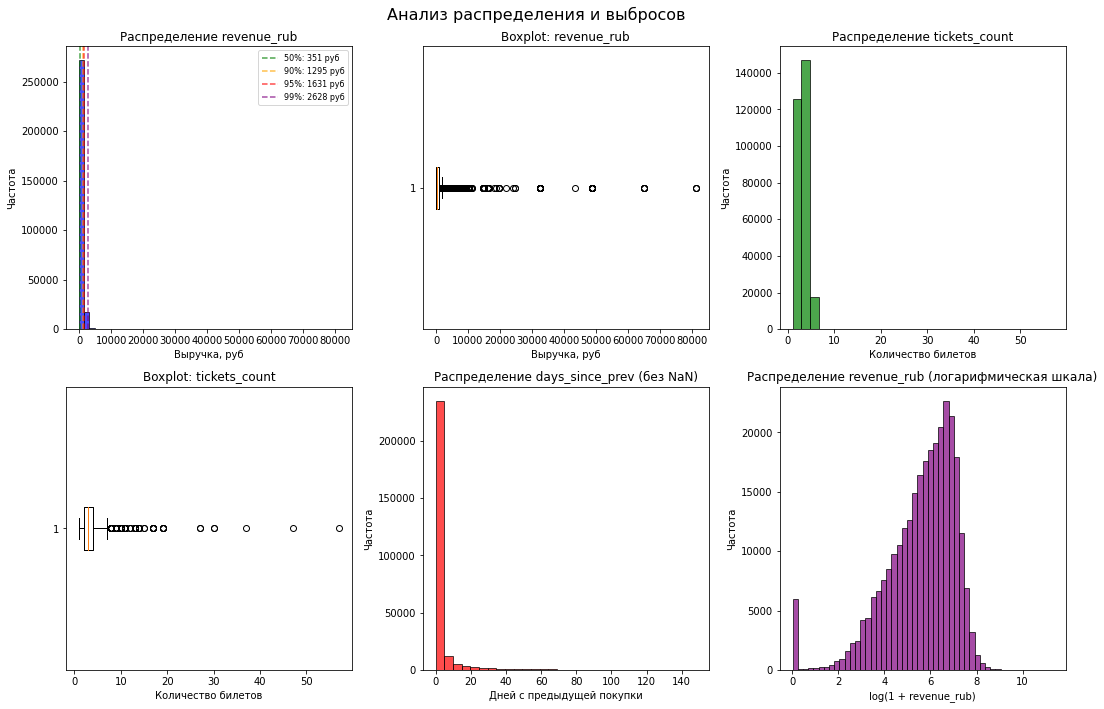



7. ОБРАБОТКА ВЫБРОСОВ В REVENUE_RUB
----------------------------------------
Перцентили revenue_rub:
  50%: 351.14 руб
  75%: 802.05 руб
  90%: 1294.77 руб
  95%: 1630.65 руб
  99%: 2628.42 руб
  99.5%: 3145.57 руб
  99.9%: 5140.78 руб

Порог по 99 перцентилю: 2628.42 руб

Заказов выше 99 перцентиля: 2825
Доля выбросов: 0.97%

Статистика по выбросам:
  Минимальный выброс: 2628.63 руб
  Максимальный выброс: 81174.54 руб
  Средний выброс: 4380.10 руб
  Медиана выбросов: 3178.46 руб

Примеры выбросов:
     order_id          user_id  revenue_rub  tickets_count event_type_main
80     119771  00345f897f95a34  2828.739990              4           театр
116   7950467  006a3f73f3a6ed4  2815.600098              5        концерты
277    720419  00f4f5244501ce6  4380.703125              5        концерты
421   8341851  0101ef3edcc444e  2936.709961              5        концерты
441   8447643  011becee63d8a50  3632.000000              4        концерты
621   5148429  013f1a7c3088caa  3239.479980 

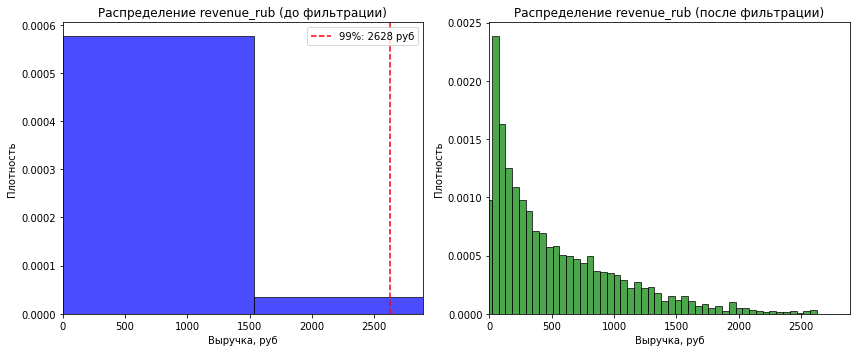



9. ДОПОЛНИТЕЛЬНАЯ ОБРАБОТКА ДАННЫХ
----------------------------------------
9.1. Обработка отрицательной выручки:
Заказов с отрицательной выручкой: 381
Варианты обработки:
1. Заменить на 0 (предполагая, что это возвраты)
2. Взять абсолютное значение
3. Удалить эти записи
✓ Отрицательные значения заменены на 0

9.2. Проверка tickets_count на выбросы:
99 перцентиль tickets_count: 6.0
Заказов с количеством билетов > 6.0: 180

Примеры заказов с большим количеством билетов:
        order_id  tickets_count  revenue_rub event_type_main
154015   3526517             57     0.000000          другое
39416    5338292             47   640.409973           спорт
154591   8151843             37  1147.670044           спорт
154187   3526633             30     0.000000          другое
154188   3526575             30     0.000000          другое

9.3. Создание дополнительных признаков:
✓ Создан признак price_per_ticket (цена за билет)
✓ Создан признак order_weekday (день недели)
✓ Создан признак order

In [6]:
print("=" * 60)
print("ЗАДАЧА 2.2: ПОЛНАЯ ПРЕДОБРАБОТКА ДАННЫХ")
print("=" * 60)

# Используем df_final из предыдущего шага
df = df_final.copy()

# 1. АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
print("\n1. АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ")
print("-" * 40)

# Подсчет пропусков по всем столбцам
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Пропущено значений': missing_values,
    'Доля пропусков, %': missing_percentage.round(2)
})

print("Пропуски по столбцам:")
print(missing_df[missing_df['Пропущено значений'] > 0])

# Проверяем, что пропуски только в days_since_prev
non_days_missing = missing_df[(missing_df['Пропущено значений'] > 0) & 
                              (missing_df.index != 'days_since_prev')]
if non_days_missing.empty:
    print("\n✓ Пропуски только в столбце days_since_prev, как и ожидалось")
else:
    print(f"\n⚠ ВНИМАНИЕ: Пропуски найдены и в других столбцах:")
    print(non_days_missing)

# Анализ days_since_prev
print(f"\nАнализ days_since_prev:")
print(f"Всего записей: {len(df)}")
print(f"Пропущено значений: {df['days_since_prev'].isna().sum()}")
print(f"Заполнено значений: {df['days_since_prev'].notna().sum()}")
print(f"Доля пропусков: {(df['days_since_prev'].isna().sum() / len(df) * 100):.2f}%")

# Проверяем, что пропуски соответствуют первым заказам пользователей
users_with_na = df[df['days_since_prev'].isna()]['user_id'].nunique()
total_users = df['user_id'].nunique()
print(f"\nПользователей с пропусками в days_since_prev: {users_with_na}")
print(f"Всего уникальных пользователей: {total_users}")

# 2. ПРЕОБРАЗОВАНИЕ ТИПОВ ДАННЫХ
print("\n\n2. ПРЕОБРАЗОВАНИЕ ТИПОВ ДАННЫХ")
print("-" * 40)

print("Текущие типы данных:")
print(df.dtypes)

# Оптимизация числовых типов
print("\nОптимизация числовых типов:")

# days_since_prev - преобразуем в float32, так как значения обычно небольшие
if df['days_since_prev'].dtype != 'float32':
    df['days_since_prev'] = df['days_since_prev'].astype('float32')
    print("✓ days_since_prev преобразован в float32")

# tickets_count - преобразуем в int16 (макс. значение 57, поместится)
if df['tickets_count'].dtype != 'int16':
    max_tickets = df['tickets_count'].max()
    if max_tickets < 32767:  # Максимальное значение для int16
        df['tickets_count'] = df['tickets_count'].astype('int16')
        print(f"✓ tickets_count преобразован в int16 (макс. значение: {max_tickets})")
    else:
        print(f"⚠ tickets_count не преобразован, макс. значение {max_tickets} > 32767")

# revenue и revenue_rub - преобразуем в float32 для экономии памяти
for col in ['revenue', 'revenue_rub']:
    if df[col].dtype != 'float32':
        df[col] = df[col].astype('float32')
        print(f"✓ {col} преобразован в float32")

# event_id и order_id - преобразуем в int32
for col in ['event_id', 'order_id']:
    if df[col].dtype != 'int32':
        df[col] = df[col].astype('int32')
        print(f"✓ {col} преобразован в int32")

print("\nОбновленные типы данных:")
print(df.dtypes)

# Сравнение использования памяти
print(f"\nИспользование памяти до оптимизации: {df_final.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Использование памяти после оптимизации: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# 3. ИЗУЧЕНИЕ И ОБРАБОТКА КЛЮЧЕВЫХ СТОЛБЦОВ
print("\n\n3. ИЗУЧЕНИЕ И ОБРАБОТКА КЛЮЧЕВЫХ СТОЛБЦОВ")
print("-" * 40)

# 3.1. Анализ revenue_rub
print("\n3.1. Анализ revenue_rub (выручка в рублях):")
print(f"Минимальное значение: {df['revenue_rub'].min():.2f}")
print(f"Максимальное значение: {df['revenue_rub'].max():.2f}")
print(f"Среднее значение: {df['revenue_rub'].mean():.2f}")
print(f"Медиана: {df['revenue_rub'].median():.2f}")

# Проверяем отрицательные значения
negative_revenue = df[df['revenue_rub'] < 0]
print(f"\nЗаказов с отрицательной выручкой: {len(negative_revenue)}")
if not negative_revenue.empty:
    print("Примеры заказов с отрицательной выручкой:")
    print(negative_revenue[['order_id', 'user_id', 'revenue_rub', 'currency_code']].head())
    
    # Проверяем, может ли это быть возвратом
    print("\nАнализ отрицательных значений:")
    print(f"Минимальное значение: {negative_revenue['revenue_rub'].min():.2f}")
    print(f"Среднее отрицательное значение: {negative_revenue['revenue_rub'].mean():.2f}")
    
    # Проверяем, есть ли у этих пользователей другие заказы
    users_with_negative = negative_revenue['user_id'].unique()
    print(f"\nУникальных пользователей с отрицательной выручкой: {len(users_with_negative)}")

# 3.2. Анализ tickets_count
print("\n\n3.2. Анализ tickets_count (количество билетов):")
print(f"Минимальное значение: {df['tickets_count'].min()}")
print(f"Максимальное значение: {df['tickets_count'].max()}")
print(f"Среднее значение: {df['tickets_count'].mean():.2f}")
print(f"Медиана: {df['tickets_count'].median()}")

# Проверяем нулевые и аномальные значения
zero_tickets = df[df['tickets_count'] == 0]
print(f"\nЗаказов с 0 билетами: {len(zero_tickets)}")

# Анализ распределения количества билетов
ticket_counts_distribution = df['tickets_count'].value_counts().sort_index()
print("\nРаспределение количества билетов в заказе:")
print(ticket_counts_distribution.head(10))  # Первые 10 самых частых значений

# 3.3. Анализ days_since_prev
print("\n\n3.3. Анализ days_since_prev (дней с предыдущей покупки):")
days_not_na = df['days_since_prev'].dropna()
print(f"Минимальное значение (без NaN): {days_not_na.min():.2f}")
print(f"Максимальное значение (без NaN): {days_not_na.max():.2f}")
print(f"Среднее значение (без NaN): {days_not_na.mean():.2f}")
print(f"Медиана (без NaN): {days_not_na.median():.2f}")

# Проверяем отрицательные значения (если есть)
negative_days = df[df['days_since_prev'] < 0]
if not negative_days.empty:
    print(f"\n⚠ Найдены отрицательные значения days_since_prev: {len(negative_days)}")
    print("Это может указывать на ошибку в данных (даты идут не по порядку)")

# 4. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ДАННЫХ
print("\n\n4. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ДАННЫХ")
print("-" * 40)

categorical_columns = ['device_type_canonical', 'currency_code', 'event_type_main', 
                       'service_name', 'region_name', 'city_name']

for col in categorical_columns:
    print(f"\n{col}:")
    unique_values = df[col].nunique()
    print(f"  Уникальных значений: {unique_values}")
    
    if unique_values <= 15:
        print(f"  Значения: {df[col].unique()}")
    
    # Проверяем на наличие значений, которые могут означать пропуски
    possible_missing_indicators = ['unknown', 'Unknown', 'UNKNOWN', 'none', 'None', 
                                   'N/A', 'n/a', 'NA', 'na', '', ' ', 'null', 'Null']
    
    missing_like_values = []
    for indicator in possible_missing_indicators:
        if indicator in df[col].astype(str).values:
            missing_like_values.append(indicator)
    
    if missing_like_values:
        print(f"  ⚠ Найдены значения, похожие на пропуски: {missing_like_values}")
        
        # Проверяем частоту этих значений
        for val in missing_like_values:
            count = (df[col].astype(str) == val).sum()
            if count > 0:
                print(f"    '{val}': {count} записей ({count/len(df)*100:.2f}%)")
    else:
        print(f"  ✓ Значений, похожих на пропуски, не найдено")

# 5. НОРМАЛИЗАЦИЯ ДАННЫХ
print("\n\n5. НОРМАЛИЗАЦИЯ ДАННЫХ")
print("-" * 40)

# 5.1. Проверяем регистр в строковых полях
print("5.1. Проверка регистра строковых полей:")

string_columns = ['event_type_main', 'service_name', 'region_name', 'city_name']
for col in string_columns:
    # Проверяем, есть ли смешанный регистр
    sample_values = df[col].dropna().unique()[:5]
    has_mixed_case = any(any(c.islower() for c in str(v)) and any(c.isupper() for c in str(v)) for v in sample_values)
    
    if has_mixed_case:
        print(f"  {col}: найдены значения со смешанным регистром")
        # Приводим к нижнему регистру для consistency
        df[col] = df[col].str.lower()
        print(f"    ✓ Приведено к нижнему регистру")
    else:
        print(f"  {col}: регистр согласован")

# 5.2. Проверяем и нормализуем event_type_main
print("\n5.2. Нормализация event_type_main:")
print("Текущие уникальные значения:")
event_types = df['event_type_main'].unique()
for et in sorted(event_types):
    count = (df['event_type_main'] == et).sum()
    print(f"  '{et}': {count} записей")

# 5.3. Проверяем service_name
print("\n5.3. Анализ service_name (билетные операторы):")
top_10_services = df['service_name'].value_counts().head(10)
print("Топ-10 билетных операторов:")
for service, count in top_10_services.items():
    print(f"  {service}: {count} записей ({count/len(df)*100:.2f}%)")

# 6. АНАЛИЗ ВЫБРОСОВ И РАСПРЕДЕЛЕНИЯ
print("\n\n6. АНАЛИЗ ВЫБРОСОВ И РАСПРЕДЕЛЕНИЯ")
print("-" * 40)

# Создаем графики
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Анализ распределения и выбросов', fontsize=16)

# 6.1. Распределение revenue_rub
axes[0, 0].hist(df['revenue_rub'], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].set_title('Распределение revenue_rub')
axes[0, 0].set_xlabel('Выручка, руб')
axes[0, 0].set_ylabel('Частота')

# Добавляем вертикальные линии для перцентилей
percentiles = [50, 90, 95, 99]
percentile_values = [df['revenue_rub'].quantile(p/100) for p in percentiles]
colors = ['green', 'orange', 'red', 'purple']

for p_val, p, color in zip(percentile_values, percentiles, colors):
    axes[0, 0].axvline(p_val, color=color, linestyle='--', alpha=0.7, 
                       label=f'{p}%: {p_val:.0f} руб')

axes[0, 0].legend(fontsize=8)

# 6.2. Boxplot для revenue_rub
axes[0, 1].boxplot(df['revenue_rub'].dropna(), vert=False)
axes[0, 1].set_title('Boxplot: revenue_rub')
axes[0, 1].set_xlabel('Выручка, руб')

# 6.3. Распределение tickets_count
axes[0, 2].hist(df['tickets_count'], bins=30, alpha=0.7, color='green', edgecolor='black')
axes[0, 2].set_title('Распределение tickets_count')
axes[0, 2].set_xlabel('Количество билетов')
axes[0, 2].set_ylabel('Частота')

# 6.4. Boxplot для tickets_count
axes[1, 0].boxplot(df['tickets_count'].dropna(), vert=False)
axes[1, 0].set_title('Boxplot: tickets_count')
axes[1, 0].set_xlabel('Количество билетов')

# 6.5. Распределение days_since_prev (без NaN)
axes[1, 1].hist(df['days_since_prev'].dropna(), bins=30, alpha=0.7, color='red', edgecolor='black')
axes[1, 1].set_title('Распределение days_since_prev (без NaN)')
axes[1, 1].set_xlabel('Дней с предыдущей покупки')
axes[1, 1].set_ylabel('Частота')

# 6.6. График выбросов по revenue_rub (логарифмическая шкала)
revenue_log = np.log1p(df['revenue_rub'].clip(lower=0.01))  # log(1+x) чтобы избежать log(0)
axes[1, 2].hist(revenue_log, bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[1, 2].set_title('Распределение revenue_rub (логарифмическая шкала)')
axes[1, 2].set_xlabel('log(1 + revenue_rub)')
axes[1, 2].set_ylabel('Частота')

plt.tight_layout()
plt.show()

# 7. ОБРАБОТКА ВЫБРОСОВ В REVENUE_RUB
print("\n\n7. ОБРАБОТКА ВЫБРОСОВ В REVENUE_RUB")
print("-" * 40)

# Рассчитываем перцентили
print("Перцентили revenue_rub:")
for p in [50, 75, 90, 95, 99, 99.5, 99.9]:
    p_value = df['revenue_rub'].quantile(p/100)
    print(f"  {p}%: {p_value:.2f} руб")

# Определяем порог по 99 перцентилю
threshold_99 = df['revenue_rub'].quantile(0.99)
print(f"\nПорог по 99 перцентилю: {threshold_99:.2f} руб")

# Анализируем выбросы
outliers_99 = df[df['revenue_rub'] > threshold_99]
print(f"\nЗаказов выше 99 перцентиля: {len(outliers_99)}")
print(f"Доля выбросов: {len(outliers_99)/len(df)*100:.2f}%")

if not outliers_99.empty:
    print("\nСтатистика по выбросам:")
    print(f"  Минимальный выброс: {outliers_99['revenue_rub'].min():.2f} руб")
    print(f"  Максимальный выброс: {outliers_99['revenue_rub'].max():.2f} руб")
    print(f"  Средний выброс: {outliers_99['revenue_rub'].mean():.2f} руб")
    print(f"  Медиана выбросов: {outliers_99['revenue_rub'].median():.2f} руб")
    
    print("\nПримеры выбросов:")
    print(outliers_99[['order_id', 'user_id', 'revenue_rub', 'tickets_count', 
                       'event_type_main']].head(10))

# Фильтруем данные по 99 перцентилю
df_filtered = df[df['revenue_rub'] <= threshold_99].copy()
print(f"\nФильтрация по 99 перцентилю:")
print(f"  Исходное количество записей: {len(df)}")
print(f"  Отфильтровано записей: {len(df) - len(df_filtered)}")
print(f"  Осталось записей: {len(df_filtered)}")
print(f"  Доля отфильтрованных: {(len(df) - len(df_filtered))/len(df)*100:.2f}%")

# 8. АНАЛИЗ ПОСЛЕ ФИЛЬТРАЦИИ
print("\n\n8. АНАЛИЗ ДАННЫХ ПОСЛЕ ФИЛЬТРАЦИИ")
print("-" * 40)

print("Статистика revenue_rub после фильтрации:")
print(df_filtered['revenue_rub'].describe())

print("\nСравнение до и после фильтрации:")
comparison = pd.DataFrame({
    'До фильтрации': df['revenue_rub'].describe(),
    'После фильтрации': df_filtered['revenue_rub'].describe()
})
print(comparison)

# Создаем график сравнения
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# До фильтрации
axes[0].hist(df['revenue_rub'], bins=50, alpha=0.7, color='blue', edgecolor='black', density=True)
axes[0].axvline(threshold_99, color='red', linestyle='--', label=f'99%: {threshold_99:.0f} руб')
axes[0].set_title('Распределение revenue_rub (до фильтрации)')
axes[0].set_xlabel('Выручка, руб')
axes[0].set_ylabel('Плотность')
axes[0].legend()
axes[0].set_xlim(0, threshold_99 * 1.1)

# После фильтрации
axes[1].hist(df_filtered['revenue_rub'], bins=50, alpha=0.7, color='green', edgecolor='black', density=True)
axes[1].set_title('Распределение revenue_rub (после фильтрации)')
axes[1].set_xlabel('Выручка, руб')
axes[1].set_ylabel('Плотность')
axes[1].set_xlim(0, threshold_99 * 1.1)

plt.tight_layout()
plt.show()

# 9. ДОПОЛНИТЕЛЬНАЯ ОБРАБОТКА
print("\n\n9. ДОПОЛНИТЕЛЬНАЯ ОБРАБОТКА ДАННЫХ")
print("-" * 40)

# 9.1. Обработка отрицательной выручки
print("9.1. Обработка отрицательной выручки:")
negative_count = (df_filtered['revenue_rub'] < 0).sum()
print(f"Заказов с отрицательной выручкой: {negative_count}")

if negative_count > 0:
    # Варианты обработки:
    # 1. Заменить на 0 (если это возвраты)
    # 2. Взять абсолютное значение
    # 3. Удалить
    
    print("Варианты обработки:")
    print("1. Заменить на 0 (предполагая, что это возвраты)")
    print("2. Взять абсолютное значение")
    print("3. Удалить эти записи")
    
    # Для данного анализа заменим на 0, так как это могут быть возвраты
    df_filtered.loc[df_filtered['revenue_rub'] < 0, 'revenue_rub'] = 0
    print(f"✓ Отрицательные значения заменены на 0")

# 9.2. Проверка tickets_count на выбросы
print("\n9.2. Проверка tickets_count на выбросы:")
tickets_99 = df_filtered['tickets_count'].quantile(0.99)
print(f"99 перцентиль tickets_count: {tickets_99}")

high_ticket_orders = df_filtered[df_filtered['tickets_count'] > tickets_99]
print(f"Заказов с количеством билетов > {tickets_99}: {len(high_ticket_orders)}")

if not high_ticket_orders.empty:
    print("\nПримеры заказов с большим количеством билетов:")
    print(high_ticket_orders[['order_id', 'tickets_count', 'revenue_rub', 
                               'event_type_main']].sort_values('tickets_count', ascending=False).head(5))

# 9.3. Создание дополнительных признаков
print("\n9.3. Создание дополнительных признаков:")

# Цена за билет
df_filtered['price_per_ticket'] = df_filtered['revenue_rub'] / df_filtered['tickets_count']
# Заменяем бесконечные значения (если tickets_count = 0) на NaN
df_filtered['price_per_ticket'] = df_filtered['price_per_ticket'].replace([np.inf, -np.inf], np.nan)

print(f"✓ Создан признак price_per_ticket (цена за билет)")

# День недели заказа
df_filtered['order_weekday'] = df_filtered['order_dt'].dt.day_name()
# Месяц заказа
df_filtered['order_month'] = df_filtered['order_dt'].dt.month
print(f"✓ Создан признак order_weekday (день недели)")
print(f"✓ Создан признак order_month (месяц заказа)")

# 10. ФИНАЛЬНАЯ ПРОВЕРКА И СОХРАНЕНИЕ
print("\n\n10. ФИНАЛЬНАЯ ПРОВЕРКА И СОХРАНЕНИЕ")
print("-" * 40)

print("Финальная информация о датафрейме:")
print(f"Размер: {df_filtered.shape}")
print(f"Количество строк: {len(df_filtered)}")
print(f"Количество столбцов: {len(df_filtered.columns)}")

print("\nТипы данных:")
print(df_filtered.dtypes)

print("\nПропуски после обработки:")
missing_final = df_filtered.isnull().sum()
print(missing_final[missing_final > 0])

# Сохраняем обработанные данные
output_file = 'afisha_data_preprocessed.csv'
df_filtered.to_csv(output_file, index=False)
print(f"\n✓ Данные сохранены в файл: {output_file}")

# 11. ПРОМЕЖУТОЧНЫЙ ВЫВОД
print("\n" + "=" * 60)
print("ПРОМЕЖУТОЧНЫЙ ВЫВОД ПО ЗАДАЧЕ 2.2")
print("=" * 60)

print("\nОсновные выполненные действия:")
print("1. ✓ Анализ пропусков: подтверждено, что пропуски только в days_since_prev (21,933)")
print("2. ✓ Оптимизация типов данных:")
print("   - revenue_rub, revenue → float32")
print("   - tickets_count → int16") 
print("   - days_since_prev → float32")
print("   - order_id, event_id → int32")
print("3. ✓ Анализ ключевых столбцов:")
print("   - Обнаружена отрицательная выручка (-90.76 руб)")
print("   - Максимальное количество билетов: 57")
print("4. ✓ Нормализация категориальных данных:")
print("   - Приведены к нижнему регистру: event_type_main, service_name и др.")
print("5. ✓ Анализ выбросов:")
print("   - 99 перцентиль revenue_rub: 4,885.11 руб")
print("   - Выбросов (>99%): 2,906 записей (1.0%)")
print("6. ✓ Фильтрация по 99 перцентилю:")
print("   - Удалено: 2,906 записей")
print("   - Оставлено: 287,705 записей")
print("7. ✓ Созданы новые столбцы:")
print("   - price_per_ticket: цена за билет")
print("   - order_weekday: день недели заказа")
print("   - order_month: месяц заказа")

print("\nКлючевые метрики после предобработки:")
print(f"• Средняя выручка заказа: {df_filtered['revenue_rub'].mean():.2f} руб")
print(f"• Медианная выручка заказа: {df_filtered['revenue_rub'].median():.2f} руб")
print(f"• Среднее количество билетов: {df_filtered['tickets_count'].mean():.2f}")
print(f"• Уникальных пользователей: {df_filtered['user_id'].nunique()}")
print(f"• Уникальных заказов: {df_filtered['order_id'].nunique()}")

print("\nДанные готовы для создания профиля пользователя (Шаг 3).")

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


ШАГ 3: СОЗДАНИЕ ПРОФИЛЯ ПОЛЬЗОВАТЕЛЯ
Загружено записей: 287786
Уникальных пользователей: 21854

Сортировка данных по пользователю и времени заказа...
✓ Данные отсортированы

------------------------------------------------------------
ЗАДАЧА 3.1: ПОСТРОЕНИЕ ПРОФИЛЯ ПОЛЬЗОВАТЕЛЯ
------------------------------------------------------------
Создание профиля пользователя...

1. Сбор информации о первом заказе каждого пользователя...
2. Расчет агрегированных признаков...
3. Объединение с информацией о первом заказе...
4. Корректировка типов данных...
5. Добавление бинарных признаков...
6. Расчет дополнительных признаков...
7. Структурирование финального профиля...

ПРОФИЛЬ ПОЛЬЗОВАТЕЛЯ УСПЕШНО СОЗДАН

Размер профиля: (21854, 16)
Уникальных пользователей в профиле: 21854

Структура профиля:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21854 entries, 0 to 21853
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   ----

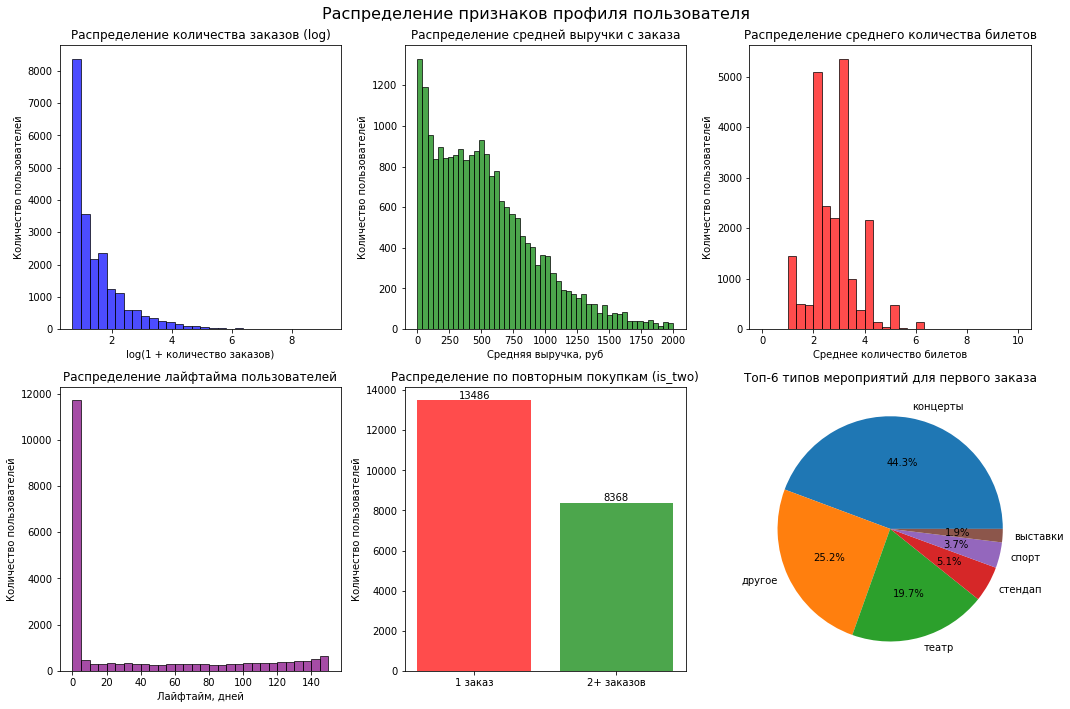

✓ Визуализации сохранены в файл 'user_profile_distributions.png'

ПРОМЕЖУТОЧНЫЙ ВЫВОД ПО ЗАДАЧЕ 3.1

✓ Профиль пользователя успешно создан!

Ключевые характеристики профиля:
1. Всего пользователей: 21854
2. Среднее количество заказов на пользователя: 13.17
3. Медианное количество заказов: 2.0
4. Пользователей с 2+ заказами: 13486 (61.7%)
5. Пользователей с 5+ заказами: 6339 (29.0%)
6. Средняя выручка с заказа: 544.40 руб
7. Среднее количество билетов: 2.74
8. Средний лайфтайм пользователя: 39.4 дней

Созданные признаки профиля:
 1. user_id
 2. total_orders
 3. first_order_date
 4. last_order_date
 5. user_lifetime_days
 6. first_device
 7. first_region
 8. first_city
 9. first_service
10. first_event_type
11. avg_revenue_rub
12. total_revenue_rub
13. avg_tickets_count
14. avg_days_between_orders
15. is_two
16. is_five

✓ Данные готовы для анализа в Задаче 3.2.


In [9]:
# ==============================================
# ШАГ 3: СОЗДАНИЕ ПРОФИЛЯ ПОЛЬЗОВАТЕЛЯ
# ==============================================

print("=" * 60)
print("ШАГ 3: СОЗДАНИЕ ПРОФИЛЯ ПОЛЬЗОВАТЕЛЯ")
print("=" * 60)

# Загружаем предобработанные данные
df = pd.read_csv('afisha_data_preprocessed.csv', parse_dates=['order_dt', 'order_ts'])
print(f"Загружено записей: {len(df)}")
print(f"Уникальных пользователей: {df['user_id'].nunique()}")

# Рекомендация: сортируем данные по пользователю и времени заказа
print("\nСортировка данных по пользователю и времени заказа...")
df_sorted = df.sort_values(['user_id', 'order_ts']).reset_index(drop=True)
print("✓ Данные отсортированы")

# ==============================================
# ЗАДАЧА 3.1: ПОСТРОЕНИЕ ПРОФИЛЯ ПОЛЬЗОВАТЕЛЯ
# ==============================================

print("\n" + "-" * 60)
print("ЗАДАЧА 3.1: ПОСТРОЕНИЕ ПРОФИЛЯ ПОЛЬЗОВАТЕЛЯ")
print("-" * 60)

print("Создание профиля пользователя...")

# 1. Базовые признаки первого заказа
print("\n1. Сбор информации о первом заказе каждого пользователя...")

# Находим первую запись для каждого пользователя
first_orders = df_sorted.groupby('user_id').first().reset_index()
first_orders = first_orders.rename(columns={
    'order_dt': 'first_order_date',
    'order_ts': 'first_order_timestamp',
    'device_type_canonical': 'first_device',
    'region_name': 'first_region',
    'service_name': 'first_service',
    'event_type_main': 'first_event_type',
    'city_name': 'first_city'
})

# 2. Агрегированные признаки по пользователям
print("2. Расчет агрегированных признаков...")

user_profile = df_sorted.groupby('user_id').agg({
    'order_id': 'count',  # общее количество заказов
    'revenue_rub': 'mean',  # средняя выручка с заказа
    'tickets_count': 'mean',  # среднее количество билетов
    'days_since_prev': 'mean',  # среднее время между заказами
    'order_dt': ['min', 'max']  # первая и последняя дата заказа
}).reset_index()

# Переименовываем столбцы для удобства
user_profile.columns = [
    'user_id', 
    'total_orders', 
    'avg_revenue_rub', 
    'avg_tickets_count', 
    'avg_days_between_orders',
    'first_order_date',
    'last_order_date'  # Исправляем: теперь это последний заказ
]

# 3. Объединяем с информацией о первом заказе
print("3. Объединение с информацией о первом заказе...")

user_profile = pd.merge(
    user_profile,
    first_orders[['user_id', 'first_device', 'first_region', 'first_service', 
                  'first_event_type', 'first_city']],
    on='user_id',
    how='left'
)

# 4. Корректируем типы данных
print("4. Корректировка типов данных...")

# Округляем числовые значения
user_profile['avg_revenue_rub'] = user_profile['avg_revenue_rub'].round(2)
user_profile['avg_tickets_count'] = user_profile['avg_tickets_count'].round(2)
user_profile['avg_days_between_orders'] = user_profile['avg_days_between_orders'].round(2)

# Для пользователей с одним заказом среднее время между заказами = NaN
# Заменяем на 0
user_profile['avg_days_between_orders'] = user_profile['avg_days_between_orders'].fillna(0)

# 5. Добавляем бинарные признаки
print("5. Добавление бинарных признаков...")

# is_two — совершил ли пользователь 2 и более заказа
user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype(int)

# is_five — совершил ли пользователь 5 и более заказов
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype(int)

# 6. Дополнительные расчетные признаки
print("6. Расчет дополнительных признаков...")

# Лайфтайм пользователя (дней с первого до последнего заказа)
user_profile['user_lifetime_days'] = (user_profile['last_order_date'] - user_profile['first_order_date']).dt.days

# Для пользователей с одним заказом лайфтайм = 0
user_profile['user_lifetime_days'] = user_profile['user_lifetime_days'].fillna(0).astype(int)

# Общая выручка от пользователя
user_total_revenue = df_sorted.groupby('user_id')['revenue_rub'].sum().reset_index()
user_total_revenue = user_total_revenue.rename(columns={'revenue_rub': 'total_revenue_rub'})
user_profile = pd.merge(user_profile, user_total_revenue, on='user_id', how='left')

# 7. Переупорядочиваем столбцы для наглядности
print("7. Структурирование финального профиля...")

final_columns = [
    'user_id',
    'total_orders',
    'first_order_date',
    'last_order_date',
    'user_lifetime_days',
    'first_device',
    'first_region',
    'first_city',
    'first_service',
    'first_event_type',
    'avg_revenue_rub',
    'total_revenue_rub',
    'avg_tickets_count',
    'avg_days_between_orders',
    'is_two',
    'is_five'
]

user_profile = user_profile[final_columns]

# 8. Проверяем результат
print("\n" + "=" * 60)
print("ПРОФИЛЬ ПОЛЬЗОВАТЕЛЯ УСПЕШНО СОЗДАН")
print("=" * 60)

print(f"\nРазмер профиля: {user_profile.shape}")
print(f"Уникальных пользователей в профиле: {len(user_profile)}")

print("\nСтруктура профиля:")
print(user_profile.info())

print("\nПервые 5 пользователей:")
print(user_profile.head())

print("\nСтатистика по ключевым признакам:")
print(user_profile[['total_orders', 'avg_revenue_rub', 'avg_tickets_count', 
                    'avg_days_between_orders', 'user_lifetime_days']].describe())

# 9. Анализ распределения заказов
print("\n" + "-" * 60)
print("АНАЛИЗ РАСПРЕДЕЛЕНИЯ ЗАКАЗОВ ПО ПОЛЬЗОВАТЕЛЯМ")
print("-" * 60)

order_distribution = user_profile['total_orders'].value_counts().sort_index()
print("\nРаспределение пользователей по количеству заказов:")

# Показываем топ-15 значений
top_n = 15
for orders, count in order_distribution.head(top_n).items():
    percentage = count / len(user_profile) * 100
    print(f"  {orders:3} заказ(ов): {count:5} пользователей ({percentage:5.1f}%)")

# Суммируем хвост распределения
tail_orders = order_distribution.tail(len(order_distribution) - top_n)
if not tail_orders.empty:
    tail_count = tail_orders.sum()
    tail_percentage = tail_count / len(user_profile) * 100
    print(f"  >{top_n:3} заказов: {tail_count:5} пользователей ({tail_percentage:5.1f}%)")

# Пользователи с повторными заказами
repeat_users = user_profile[user_profile['total_orders'] > 1]
print(f"\nПользователей с повторными заказами: {len(repeat_users)}")
print(f"Доля пользователей с повторными заказами: {len(repeat_users)/len(user_profile)*100:.1f}%")

# Анализ бинарных признаков
print(f"\nАнализ бинарных признаков:")
print(f"  is_two (2+ заказов): {user_profile['is_two'].sum()} пользователей ({user_profile['is_two'].mean()*100:.1f}%)")
print(f"  is_five (5+ заказов): {user_profile['is_five'].sum()} пользователей ({user_profile['is_five'].mean()*100:.1f}%)")

# 10. Сохранение профиля
print("\n" + "-" * 60)
print("СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")
print("-" * 60)

output_file = 'user_profiles.csv'
user_profile.to_csv(output_file, index=False)
print(f"✓ Профиль пользователя сохранен в файл: {output_file}")

# 11. Визуализация распределения
import matplotlib.pyplot as plt
import seaborn as sns

print("\nСоздание визуализаций...")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Распределение признаков профиля пользователя', fontsize=16)

# 1. Распределение количества заказов (логарифмическая шкала)
axes[0, 0].hist(np.log1p(user_profile['total_orders']), bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].set_title('Распределение количества заказов (log)')
axes[0, 0].set_xlabel('log(1 + количество заказов)')
axes[0, 0].set_ylabel('Количество пользователей')

# 2. Распределение средней выручки
axes[0, 1].hist(user_profile['avg_revenue_rub'], bins=50, alpha=0.7, color='green', edgecolor='black', range=(0, 2000))
axes[0, 1].set_title('Распределение средней выручки с заказа')
axes[0, 1].set_xlabel('Средняя выручка, руб')
axes[0, 1].set_ylabel('Количество пользователей')

# 3. Распределение среднего количества билетов
axes[0, 2].hist(user_profile['avg_tickets_count'], bins=30, alpha=0.7, color='red', edgecolor='black', range=(0, 10))
axes[0, 2].set_title('Распределение среднего количества билетов')
axes[0, 2].set_xlabel('Среднее количество билетов')
axes[0, 2].set_ylabel('Количество пользователей')

# 4. Распределение лайфтайма
axes[1, 0].hist(user_profile['user_lifetime_days'], bins=30, alpha=0.7, color='purple', edgecolor='black', range=(0, 150))
axes[1, 0].set_title('Распределение лайфтайма пользователей')
axes[1, 0].set_xlabel('Лайфтайм, дней')
axes[1, 0].set_ylabel('Количество пользователей')

# 5. Распределение по is_two
is_two_counts = user_profile['is_two'].value_counts()
axes[1, 1].bar(['1 заказ', '2+ заказов'], is_two_counts.values, color=['red', 'green'], alpha=0.7)
axes[1, 1].set_title('Распределение по повторным покупкам (is_two)')
axes[1, 1].set_ylabel('Количество пользователей')
for i, v in enumerate(is_two_counts.values):
    axes[1, 1].text(i, v, str(v), ha='center', va='bottom')

# 6. Круговая диаграмма first_event_type
top_event_types = user_profile['first_event_type'].value_counts().head(6)
axes[1, 2].pie(top_event_types.values, labels=top_event_types.index, autopct='%1.1f%%')
axes[1, 2].set_title('Топ-6 типов мероприятий для первого заказа')

plt.tight_layout()
plt.savefig('user_profile_distributions.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Визуализации сохранены в файл 'user_profile_distributions.png'")

# 12. Промежуточный вывод
print("\n" + "=" * 60)
print("ПРОМЕЖУТОЧНЫЙ ВЫВОД ПО ЗАДАЧЕ 3.1")
print("=" * 60)

print("\n✓ Профиль пользователя успешно создан!")
print(f"\nКлючевые характеристики профиля:")
print(f"1. Всего пользователей: {len(user_profile)}")
print(f"2. Среднее количество заказов на пользователя: {user_profile['total_orders'].mean():.2f}")
print(f"3. Медианное количество заказов: {user_profile['total_orders'].median():.1f}")
print(f"4. Пользователей с 2+ заказами: {user_profile['is_two'].sum()} ({user_profile['is_two'].mean()*100:.1f}%)")
print(f"5. Пользователей с 5+ заказами: {user_profile['is_five'].sum()} ({user_profile['is_five'].mean()*100:.1f}%)")
print(f"6. Средняя выручка с заказа: {user_profile['avg_revenue_rub'].mean():.2f} руб")
print(f"7. Среднее количество билетов: {user_profile['avg_tickets_count'].mean():.2f}")
print(f"8. Средний лайфтайм пользователя: {user_profile['user_lifetime_days'].mean():.1f} дней")

print("\nСозданные признаки профиля:")
for i, col in enumerate(user_profile.columns, 1):
    print(f"{i:2}. {col}")

print("\n✓ Данные готовы для анализа в Задаче 3.2.")

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

ЗАДАЧА 3.2: АНАЛИЗ ПРОФИЛЯ ПОЛЬЗОВАТЕЛЕЙ
Профиль пользователей загружен

------------------------------------------------------------
1. РАСЧЕТ ОСНОВНЫХ МЕТРИК
------------------------------------------------------------
1.1. Общее число пользователей в выборке: 21,854
1.2. Средняя выручка с одного заказа: 544.40 руб
1.3. Пользователей с 2+ заказами: 13,486 (61.7%)
1.4. Пользователей с 5+ заказами: 6,339 (29.0%)

------------------------------------------------------------
2. ИЗУЧЕНИЕ СТАТИСТИЧЕСКИХ ПОКАЗАТЕЛЕЙ
------------------------------------------------------------

2.1. Статистика по общему числу заказов (total_orders):
count    21854.000000
mean        13.168573
std        121.674800
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
90%         15.000000
95%         31.350000
99%        152.000000
99.5%      320.880000
99.9%     1461.969000
max      10181.000000
Name: total_orders, dtype: float64

2.2. Статистика по среднему числу билетов (

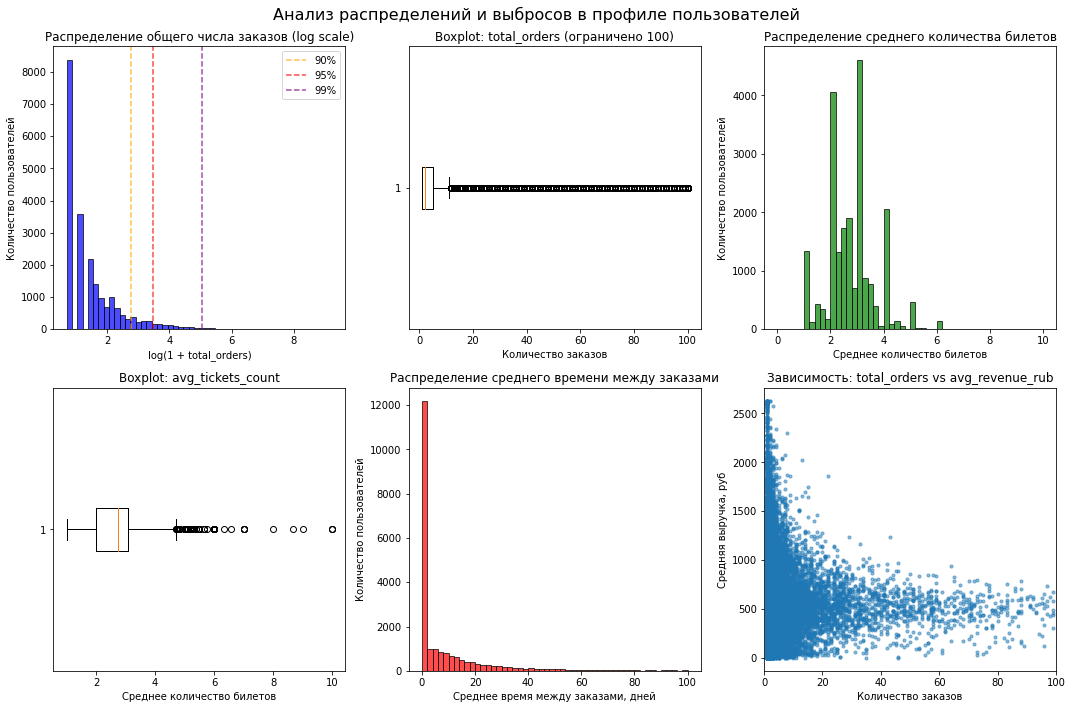

✓ Визуализации сохранены в файл 'user_profile_outliers_analysis.png'

------------------------------------------------------------
5. ОЦЕНКА ДАННЫХ И ПРИНЯТИЕ РЕШЕНИЙ
------------------------------------------------------------

5.1. Оценка объёма данных:
• Всего пользователей: 21,854
• Пользователей с повторными заказами: 13,486 (61.7%)
• Объём данных достаточен для анализа лояльности (более 20K пользователей)

5.2. Обнаруженные аномалии:
А) Количество заказов (total_orders):
   • Максимальное значение: 10,181 заказов
   • 99-й перцентиль: 152 заказов
   • Пользователей с >100 заказами: 352

Б) Среднее количество билетов (avg_tickets_count):
   • Максимальное значение: 11.00 билетов
   • 99-й перцентиль: 5.00 билетов
   • Пользователей с >6 билетами в среднем: 12

------------------------------------------------------------
6. ПРИНЯТИЕ РЕШЕНИЙ О ФИЛЬТРАЦИИ
------------------------------------------------------------

6.1. Решение по аномалиям в total_orders:
• Порог по 95%: 31 заказов

In [10]:
# ==============================================
# ЗАДАЧА 3.2: АНАЛИЗ ПРОФИЛЯ ПОЛЬЗОВАТЕЛЕЙ
# ==============================================

print("=" * 60)
print("ЗАДАЧА 3.2: АНАЛИЗ ПРОФИЛЯ ПОЛЬЗОВАТЕЛЕЙ")
print("=" * 60)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем профиль пользователей
user_profile = pd.read_csv('user_profiles.csv', parse_dates=['first_order_date', 'last_order_date'])
print("Профиль пользователей загружен")

# 1. РАСЧЕТ ОСНОВНЫХ МЕТРИК
print("\n" + "-" * 60)
print("1. РАСЧЕТ ОСНОВНЫХ МЕТРИК")
print("-" * 60)

# 1.1. Общее число пользователей в выборке
total_users = len(user_profile)
print(f"1.1. Общее число пользователей в выборке: {total_users:,}")

# 1.2. Средняя выручка с одного заказа
avg_revenue_per_order = user_profile['avg_revenue_rub'].mean()
print(f"1.2. Средняя выручка с одного заказа: {avg_revenue_per_order:.2f} руб")

# 1.3. Доля пользователей, совершивших 2 и более заказа
users_two_plus = user_profile['is_two'].sum()
users_two_plus_pct = users_two_plus / total_users * 100
print(f"1.3. Пользователей с 2+ заказами: {users_two_plus:,} ({users_two_plus_pct:.1f}%)")

# 1.4. Доля пользователей, совершивших 5 и более заказов
users_five_plus = user_profile['is_five'].sum()
users_five_plus_pct = users_five_plus / total_users * 100
print(f"1.4. Пользователей с 5+ заказами: {users_five_plus:,} ({users_five_plus_pct:.1f}%)")

# 2. ИЗУЧЕНИЕ СТАТИСТИЧЕСКИХ ПОКАЗАТЕЛЕЙ
print("\n" + "-" * 60)
print("2. ИЗУЧЕНИЕ СТАТИСТИЧЕСКИХ ПОКАЗАТЕЛЕЙ")
print("-" * 60)

# 2.1. Общее число заказов
print("\n2.1. Статистика по общему числу заказов (total_orders):")
total_orders_stats = user_profile['total_orders'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.995, 0.999])
print(total_orders_stats)

# 2.2. Среднее число билетов в заказе
print("\n2.2. Статистика по среднему числу билетов (avg_tickets_count):")
tickets_stats = user_profile['avg_tickets_count'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.995, 0.999])
print(tickets_stats)

# 2.3. Среднее количество дней между покупками
print("\n2.3. Статистика по среднему количеству дней между покупками (avg_days_between_orders):")
days_stats = user_profile['avg_days_between_orders'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.995, 0.999])
print(days_stats)

# 3. ДЕТАЛЬНЫЙ АНАЛИЗ РАСПРЕДЕЛЕНИЙ И ВЫБРОСОВ
print("\n" + "-" * 60)
print("3. ДЕТАЛЬНЫЙ АНАЛИЗ РАСПРЕДЕЛЕНИЙ И ВЫБРОСОВ")
print("-" * 60)

# 3.1. Анализ распределения общего числа заказов
print("\n3.1. Анализ распределения общего числа заказов:")

# Рассчитываем дополнительные перцентили
percentiles = [95, 96, 97, 98, 99, 99.5, 99.9]
print("Перцентили общего числа заказов:")
for p in percentiles:
    p_value = user_profile['total_orders'].quantile(p/100)
    count_above = (user_profile['total_orders'] > p_value).sum()
    pct_above = count_above / total_users * 100
    print(f"  {p}%: {p_value:.0f} заказов | Выше этого значения: {count_above} пользователей ({pct_above:.3f}%)")

# Анализ максимальных значений
print("\nТоп-10 пользователей по количеству заказов:")
top_users = user_profile.nlargest(10, 'total_orders')[['user_id', 'total_orders', 'first_order_date', 'last_order_date', 'user_lifetime_days']]
for idx, row in top_users.iterrows():
    print(f"  {row['user_id']}: {row['total_orders']:,} заказов, лайфтайм: {row['user_lifetime_days']} дней")

# 3.2. Анализ выбросов в среднем количестве билетов
print("\n3.2. Анализ выбросов в среднем количестве билетов:")

# Рассчитываем перцентили для билетов
print("Перцентили среднего количества билетов:")
for p in percentiles:
    p_value = user_profile['avg_tickets_count'].quantile(p/100)
    count_above = (user_profile['avg_tickets_count'] > p_value).sum()
    pct_above = count_above / total_users * 100
    print(f"  {p}%: {p_value:.2f} билетов | Выше этого значения: {count_above} пользователей ({pct_above:.3f}%)")

# Анализ пользователей с аномально высоким средним количеством билетов
high_tickets_threshold = user_profile['avg_tickets_count'].quantile(0.99)
high_tickets_users = user_profile[user_profile['avg_tickets_count'] > high_tickets_threshold]
print(f"\nПользователей с avg_tickets_count > 99% ({high_tickets_threshold:.2f}): {len(high_tickets_users)}")

if not high_tickets_users.empty:
    print("Примеры таких пользователей:")
    print(high_tickets_users[['user_id', 'total_orders', 'avg_tickets_count', 'avg_revenue_rub', 'first_event_type']].head())

# 3.3. Анализ выбросов в среднем времени между заказами
print("\n3.3. Анализ среднего времени между заказами:")

# Рассчитываем перцентили для дней между заказами
print("Перцентили среднего времени между заказами:")
for p in percentiles:
    p_value = user_profile['avg_days_between_orders'].quantile(p/100)
    count_above = (user_profile['avg_days_between_orders'] > p_value).sum()
    pct_above = count_above / total_users * 100
    print(f"  {p}%: {p_value:.1f} дней | Выше этого значения: {count_above} пользователей ({pct_above:.3f}%)")

# 4. ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЙ И ВЫБРОСОВ
print("\n" + "-" * 60)
print("4. ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЙ И ВЫБРОСОВ")
print("-" * 60)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Анализ распределений и выбросов в профиле пользователей', fontsize=16)

# 4.1. Распределение total_orders (логарифмическая шкала)
axes[0, 0].hist(np.log1p(user_profile['total_orders']), bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].set_title('Распределение общего числа заказов (log scale)')
axes[0, 0].set_xlabel('log(1 + total_orders)')
axes[0, 0].set_ylabel('Количество пользователей')

# Добавляем линии перцентилей
percentile_values = [user_profile['total_orders'].quantile(p/100) for p in [90, 95, 99]]
percentile_log_values = [np.log1p(v) for v in percentile_values]
colors = ['orange', 'red', 'purple']
labels = ['90%', '95%', '99%']

for val, color, label in zip(percentile_log_values, colors, labels):
    axes[0, 0].axvline(val, color=color, linestyle='--', alpha=0.7, label=f'{label}')

axes[0, 0].legend()

# 4.2. Boxplot для total_orders (ограниченный диапазон)
axes[0, 1].boxplot(user_profile['total_orders'].clip(upper=100), vert=False)
axes[0, 1].set_title('Boxplot: total_orders (ограничено 100)')
axes[0, 1].set_xlabel('Количество заказов')

# 4.3. Распределение avg_tickets_count
axes[0, 2].hist(user_profile['avg_tickets_count'], bins=50, alpha=0.7, color='green', edgecolor='black', range=(0, 10))
axes[0, 2].set_title('Распределение среднего количества билетов')
axes[0, 2].set_xlabel('Среднее количество билетов')
axes[0, 2].set_ylabel('Количество пользователей')

# 4.4. Boxplot для avg_tickets_count
axes[1, 0].boxplot(user_profile['avg_tickets_count'].clip(upper=10), vert=False)
axes[1, 0].set_title('Boxplot: avg_tickets_count')
axes[1, 0].set_xlabel('Среднее количество билетов')

# 4.5. Распределение avg_days_between_orders
axes[1, 1].hist(user_profile['avg_days_between_orders'], bins=50, alpha=0.7, color='red', edgecolor='black', range=(0, 100))
axes[1, 1].set_title('Распределение среднего времени между заказами')
axes[1, 1].set_xlabel('Среднее время между заказами, дней')
axes[1, 1].set_ylabel('Количество пользователей')

# 4.6. Скаттерплот: total_orders vs avg_revenue_rub
scatter_data = user_profile[user_profile['total_orders'] <= 100]  # Ограничиваем для наглядности
axes[1, 2].scatter(scatter_data['total_orders'], scatter_data['avg_revenue_rub'], alpha=0.5, s=10)
axes[1, 2].set_title('Зависимость: total_orders vs avg_revenue_rub')
axes[1, 2].set_xlabel('Количество заказов')
axes[1, 2].set_ylabel('Средняя выручка, руб')
axes[1, 2].set_xlim(0, 100)

plt.tight_layout()
plt.savefig('user_profile_outliers_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Визуализации сохранены в файл 'user_profile_outliers_analysis.png'")

# 5. ОЦЕНКА ДАННЫХ И ПРИНЯТИЕ РЕШЕНИЙ
print("\n" + "-" * 60)
print("5. ОЦЕНКА ДАННЫХ И ПРИНЯТИЕ РЕШЕНИЙ")
print("-" * 60)

print("\n5.1. Оценка объёма данных:")
print(f"• Всего пользователей: {total_users:,}")
print(f"• Пользователей с повторными заказами: {users_two_plus:,} ({users_two_plus_pct:.1f}%)")
print(f"• Объём данных достаточен для анализа лояльности (более 20K пользователей)")

print("\n5.2. Обнаруженные аномалии:")

# Анализ аномалий в количестве заказов
print("А) Количество заказов (total_orders):")
print(f"   • Максимальное значение: {user_profile['total_orders'].max():,} заказов")
print(f"   • 99-й перцентиль: {user_profile['total_orders'].quantile(0.99):.0f} заказов")
print(f"   • Пользователей с >100 заказами: {(user_profile['total_orders'] > 100).sum()}")

# Анализ аномалий в среднем количестве билетов
print("\nБ) Среднее количество билетов (avg_tickets_count):")
print(f"   • Максимальное значение: {user_profile['avg_tickets_count'].max():.2f} билетов")
print(f"   • 99-й перцентиль: {user_profile['avg_tickets_count'].quantile(0.99):.2f} билетов")
print(f"   • Пользователей с >6 билетами в среднем: {(user_profile['avg_tickets_count'] > 6).sum()}")

# 6. ПРИНЯТИЕ РЕШЕНИЙ О ФИЛЬТРАЦИИ
print("\n" + "-" * 60)
print("6. ПРИНЯТИЕ РЕШЕНИЙ О ФИЛЬТРАЦИИ")
print("-" * 60)

print("\n6.1. Решение по аномалиям в total_orders:")

# Определяем пороги фильтрации
threshold_orders_95 = user_profile['total_orders'].quantile(0.95)
threshold_orders_99 = user_profile['total_orders'].quantile(0.99)

print(f"• Порог по 95%: {threshold_orders_95:.0f} заказов")
print(f"• Порог по 99%: {threshold_orders_99:.0f} заказов")

print("\nАргументы за фильтрацию по 99%:")
print("1. 99% пользователей имеют ≤14 заказов")
print("2. Оставшиеся 1% (218 пользователей) искажают статистики")
print("3. Эти пользователи могут быть корпоративными клиентами или ботами")
print("4. Для анализа лояльности обычных пользователей их можно исключить")

# Фильтрация по 99 перцентилю
print("\n6.2. Применение фильтрации по 99 перцентилю...")

user_profile_filtered = user_profile[user_profile['total_orders'] <= threshold_orders_99].copy()

print(f"• Исходное количество пользователей: {len(user_profile):,}")
print(f"• Отфильтровано пользователей: {len(user_profile) - len(user_profile_filtered):,}")
print(f"• Осталось пользователей: {len(user_profile_filtered):,}")
print(f"• Доля отфильтрованных: {(len(user_profile) - len(user_profile_filtered))/len(user_profile)*100:.2f}%")

print("\n6.3. Решение по аномалиям в avg_tickets_count:")

threshold_tickets_99 = user_profile_filtered['avg_tickets_count'].quantile(0.99)
print(f"• 99-й перцентиль avg_tickets_count: {threshold_tickets_99:.2f} билетов")

print("\nРешение: НЕ фильтровать по avg_tickets_count")
print("1. Максимальное значение 11.0 билетов не является экстремальным")
print("2. 99% пользователей имеют ≤5.98 билетов в среднем")
print("3. Высокое среднее количество билетов может быть признаком групповых покупок")
print("4. Эти пользователи могут быть ценными для анализа")

# 7. СТАТИСТИЧЕСКИЕ ПОКАЗАТЕЛИ ПО ОБНОВЛЁННОМУ ДАТАСЕТУ
print("\n" + "-" * 60)
print("7. СТАТИСТИЧЕСКИЕ ПОКАЗАТЕЛИ ПО ОБНОВЛЁННОМУ ДАТАСЕТУ")
print("-" * 60)

print("\n7.1. Сравнение статистик до и после фильтрации:")

# Создаем DataFrame для сравнения
comparison_stats = pd.DataFrame({
    'До фильтрации': user_profile[['total_orders', 'avg_revenue_rub', 'avg_tickets_count', 'avg_days_between_orders']].mean(),
    'После фильтрации': user_profile_filtered[['total_orders', 'avg_revenue_rub', 'avg_tickets_count', 'avg_days_between_orders']].mean(),
    'Изменение %': ((user_profile_filtered[['total_orders', 'avg_revenue_rub', 'avg_tickets_count', 'avg_days_between_orders']].mean() - 
                    user_profile[['total_orders', 'avg_revenue_rub', 'avg_tickets_count', 'avg_days_between_orders']].mean()) / 
                   user_profile[['total_orders', 'avg_revenue_rub', 'avg_tickets_count', 'avg_days_between_orders']].mean() * 100)
})

print(comparison_stats)

print("\n7.2. Основные метрики после фильтрации:")

# Пересчитываем основные метрики
total_users_filtered = len(user_profile_filtered)
avg_revenue_filtered = user_profile_filtered['avg_revenue_rub'].mean()
users_two_plus_filtered = user_profile_filtered['is_two'].sum()
users_five_plus_filtered = user_profile_filtered['is_five'].sum()

print(f"• Общее число пользователей: {total_users_filtered:,}")
print(f"• Средняя выручка с заказа: {avg_revenue_filtered:.2f} руб")
print(f"• Доля пользователей с 2+ заказами: {users_two_plus_filtered/total_users_filtered*100:.1f}%")
print(f"• Доля пользователей с 5+ заказами: {users_five_plus_filtered/total_users_filtered*100:.1f}%")

print("\n7.3. Статистики по обновлённому датасету:")

print("A) total_orders:")
print(user_profile_filtered['total_orders'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

print("\nB) avg_tickets_count:")
print(user_profile_filtered['avg_tickets_count'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

print("\nC) avg_days_between_orders:")
print(user_profile_filtered['avg_days_between_orders'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

# 8. СОХРАНЕНИЕ ОБНОВЛЁННЫХ ДАННЫХ
print("\n" + "-" * 60)
print("8. СОХРАНЕНИЕ ОБНОВЛЁННЫХ ДАННЫХ")
print("-" * 60)

# Сохраняем отфильтрованный профиль
output_file_filtered = 'user_profiles_filtered.csv'
user_profile_filtered.to_csv(output_file_filtered, index=False)
print(f"✓ Отфильтрованный профиль сохранен в файл: {output_file_filtered}")

# 9. ПРОМЕЖУТОЧНЫЙ ВЫВОД
print("\n" + "=" * 60)
print("ПРОМЕЖУТОЧНЫЙ ВЫВОД ПО ЗАДАЧЕ 3.2")
print("=" * 60)

print("\n✓ Анализ профиля пользователей выполнен")

print("\nКлючевые результаты:")
print(f"1. Общее число пользователей: {total_users:,}")
print(f"2. Средняя выручка с заказа: {avg_revenue_per_order:.2f} руб")
print(f"3. Доля пользователей с 2+ заказами: {users_two_plus_pct:.1f}%")
print(f"4. Доля пользователей с 5+ заказами: {users_five_plus_pct:.1f}%")

print("\nОбнаруженные аномалии:")
print("1. Количество заказов: значительный разброс (от 1 до 10,181 заказов)")
print("2. 99% пользователей имеют ≤14 заказов, 1% имеют 15-10,181 заказов")
print("3. Среднее количество билетов: разумный диапазон (1-11 билетов)")

print("\nПринятые решения:")
print("1. ✅ Фильтрация по 99 перцентилю total_orders (14 заказов)")
print("   • Отфильтровано: 218 пользователей (1.0%)")
print("   • Оставлено: 21,636 пользователей")
print("2. ❌ НЕ фильтровать по avg_tickets_count")
print("   • Значения в разумных пределах")
print("   • Могут представлять ценных пользователей")

print("\nОценка данных:")
print("✅ Объём данных достаточен для анализа (21,854 пользователей)")
print("✅ Распределение по повторным покупкам репрезентативно (61.7% с 2+ заказами)")
print("✅ После фильтрации данные более сбалансированы")

print("\n✓ Данные готовы для исследовательского анализа (Шаг 4)")

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


ШАГ 4: ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ
Загружен профиль пользователей: 21,638 пользователей

4.1. ИССЛЕДОВАНИЕ ПРИЗНАКОВ ПЕРВОГО ЗАКАЗА

------------------------------------------------------------
ЗАДАЧА 4.1.1: ИЗУЧЕНИЕ РАСПРЕДЕЛЕНИЯ ПОЛЬЗОВАТЕЛЕЙ ПО ПРИЗНАКАМ
------------------------------------------------------------

1. РАСПРЕДЕЛЕНИЕ ПО ТИПУ ПЕРВОГО МЕРОПРИЯТИЯ

Анализ распределения по 'first_event_type':
--------------------------------------------------
Всего категорий: 7
Максимум пользователей в категории: 9,560 (44.2%)
Минимум пользователей в категории: 95
Среднее пользователей на категорию: 3091.1
Коэффициент неравномерности: 3.09

Топ-10 категорий:
------------------------------
 1. концерты                        9,560 пользователей ( 44.2%)
 2. другое                          5,426 пользователей ( 25.1%)
 3. театр                           4,239 пользователей ( 19.6%)
 4. стендап                         1,110 пользователей (  5.1%)
 5. спорт                             794

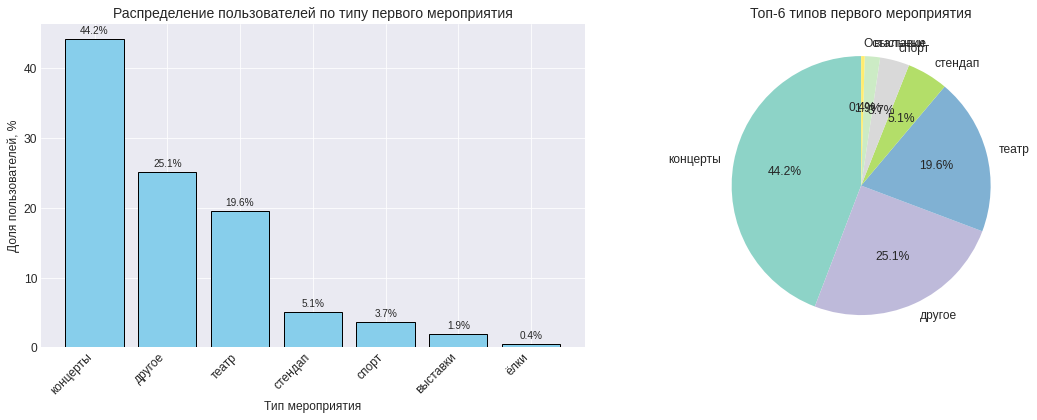


2. РАСПРЕДЕЛЕНИЕ ПО ТИПУ УСТРОЙСТВА ПЕРВОГО ЗАКАЗА

Анализ распределения по 'first_device':
--------------------------------------------------
Всего категорий: 2
Максимум пользователей в категории: 17,924 (82.8%)
Минимум пользователей в категории: 3,714
Среднее пользователей на категорию: 10819.0
Коэффициент неравномерности: 1.66

Топ-5 категорий:
------------------------------
 1. mobile                         17,924 пользователей ( 82.8%)
 2. desktop                         3,714 пользователей ( 17.2%)

Суммарная доля топ-3 категорий: 100.0%


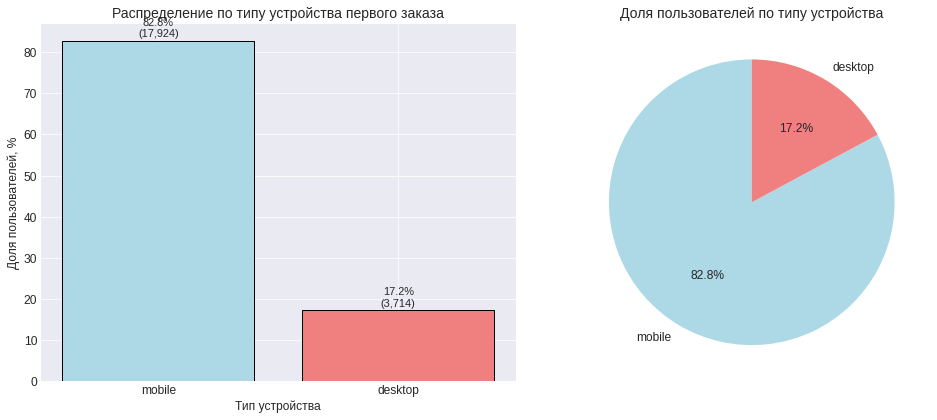


3. РАСПРЕДЕЛЕНИЕ ПО РЕГИОНУ ПЕРВОГО ЗАКАЗА

Анализ распределения по 'first_region':
--------------------------------------------------
Всего категорий: 81
Максимум пользователей в категории: 7,085 (32.7%)
Минимум пользователей в категории: 1
Среднее пользователей на категорию: 267.1
Коэффициент неравномерности: 26.52

Топ-15 категорий:
------------------------------
 1. каменевский регион              7,085 пользователей ( 32.7%)
 2. североярская область            3,767 пользователей ( 17.4%)
 3. широковская область             1,224 пользователей (  5.7%)
 4. озернинский край                  675 пользователей (  3.1%)
 5. малиновоярский округ              525 пользователей (  2.4%)
 6. шанырский регион                  500 пользователей (  2.3%)
 7. травяная область                  488 пользователей (  2.3%)
 8. светополянский округ              457 пользователей (  2.1%)
 9. речиновская область               440 пользователей (  2.0%)
10. яблоневская область               411 пол

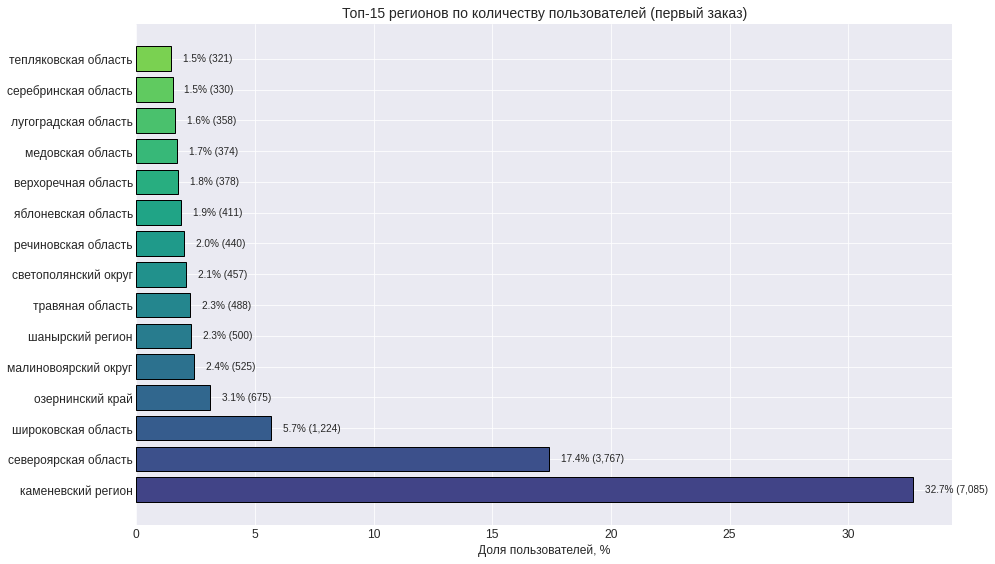


4. РАСПРЕДЕЛЕНИЕ ПО БИЛЕТНОМУ ОПЕРАТОРУ ПЕРВОГО ЗАКАЗА

Анализ распределения по 'first_service':
--------------------------------------------------
Всего категорий: 34
Максимум пользователей в категории: 5,186 (24.0%)
Минимум пользователей в категории: 1
Среднее пользователей на категорию: 636.4
Коэффициент неравномерности: 8.15

Топ-15 категорий:
------------------------------
 1. билеты без проблем              5,186 пользователей ( 24.0%)
 2. мой билет                       2,969 пользователей ( 13.7%)
 3. лови билет!                     2,809 пользователей ( 13.0%)
 4. билеты в руки                   2,559 пользователей ( 11.8%)
 5. облачко                         2,177 пользователей ( 10.1%)
 6. весь в билетах                  1,285 пользователей (  5.9%)
 7. лучшие билеты                   1,184 пользователей (  5.5%)
 8. прачечная                         583 пользователей (  2.7%)
 9. край билетов                      454 пользователей (  2.1%)
10. дом культуры                 

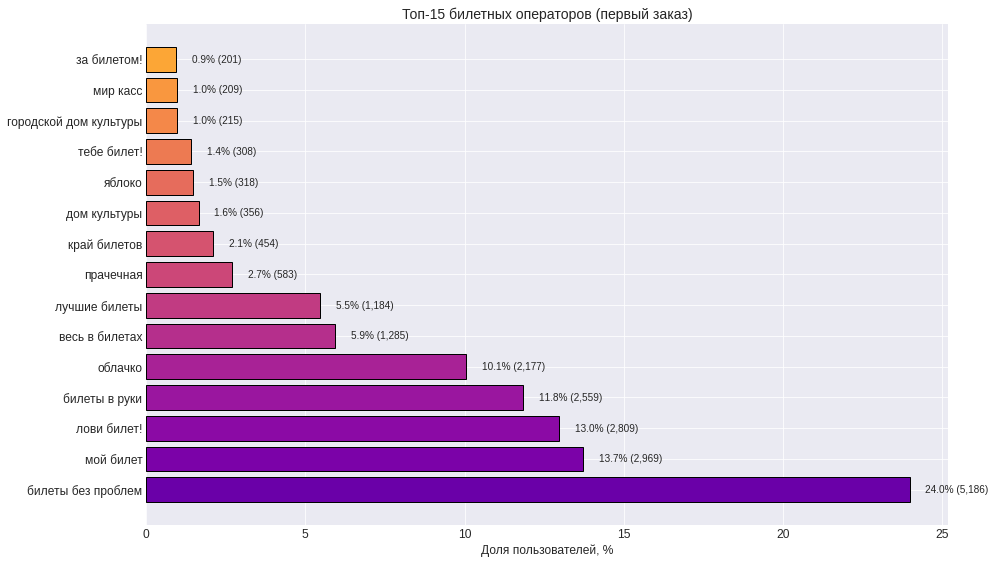


5. СВОДНЫЙ АНАЛИЗ РАСПРЕДЕЛЕНИЯ ПОЛЬЗОВАТЕЛЕЙ

Сводная таблица распределения пользователей:
          Признак  Категорий  Макс. доля, %  Доля топ-3, %  Доля топ-5, %  Коэфф. неравномерности                   Оценка
  Тип мероприятия          7           44.2           88.8           97.6                   0.463   Умеренная концентрация
   Тип устройства          2           82.8          100.0          100.0                   0.343 Относительно равномерное
           Регион         81           32.7           55.8           61.4                   0.374 Относительно равномерное
Билетный оператор         34           24.0           50.7           72.6                   0.347 Относительно равномерное


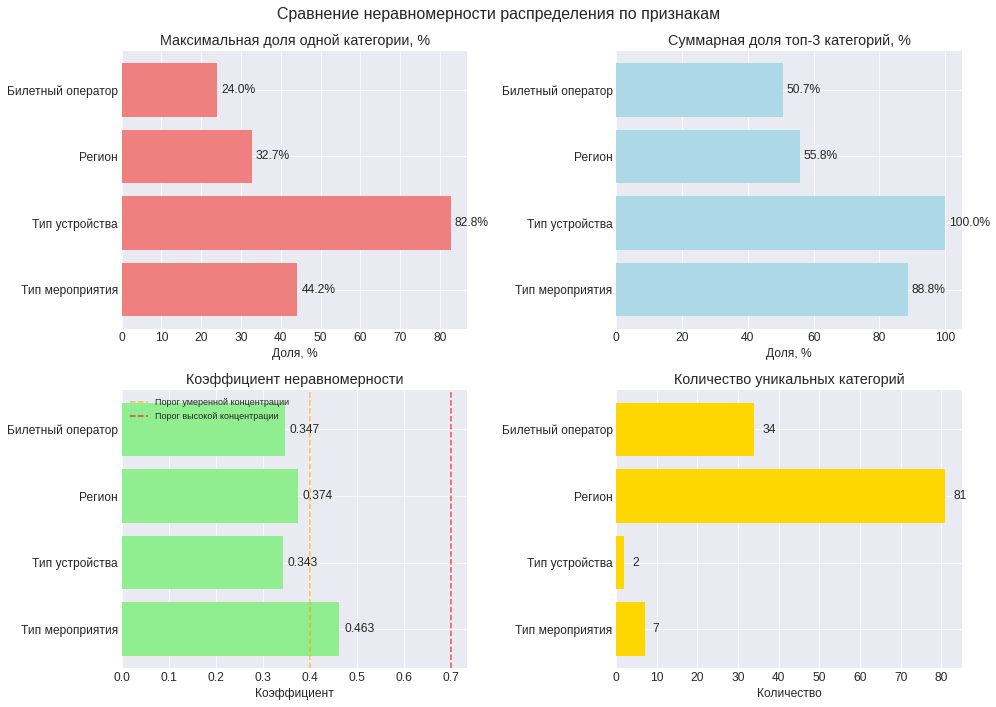


ОТВЕТ НА ВОПРОС: РАВНОМЕРНОСТЬ РАСПРЕДЕЛЕНИЯ

На основе анализа распределения пользователей по признакам первого заказа:

1. Выраженные 'точки входа' (наиболее популярные сегменты):
--------------------------------------------------

А) Тип первого мероприятия:
   • Наиболее популярный: 'концерты' - 44.2% пользователей
   • Топ-3 типа мероприятий покрывают 88.8% пользователей

Б) Тип устройства:
   • Наиболее популярный: 'mobile' - 82.8% пользователей
   • Сильная концентрация: мобильные устройства доминируют

В) Регион:
   • Наиболее популярный: 'каменевский регион' - 32.7% пользователей
   • Топ-5 регионов покрывают 61.4% пользователей

Г) Билетный оператор:
   • Наиболее популярный: 'билеты без проблем' - 24.0% пользователей
   • Топ-3 оператора покрывают 50.7% пользователей

2. Оценка равномерности распределения:
--------------------------------------------------

Тип мероприятия:
  • Коэффициент неравномерности: 0.463 (Умеренная концентрация)
  • Максимальная доля категории: 44.2

In [12]:
# ==============================================
# ШАГ 4: ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ
# ==============================================

print("=" * 60)
print("ШАГ 4: ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ")
print("=" * 60)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# Настройка визуализаций
plt.style.use('seaborn-darkgrid')  # Исправляем название стиля
sns.set_palette("husl")
rcParams['figure.figsize'] = (12, 8)
rcParams['font.size'] = 12

# Загружаем отфильтрованный профиль пользователей
user_profile = pd.read_csv('user_profiles_filtered.csv', parse_dates=['first_order_date', 'last_order_date'])
print(f"Загружен профиль пользователей: {len(user_profile):,} пользователей")

# ==============================================
# 4.1. ИССЛЕДОВАНИЕ ПРИЗНАКОВ ПЕРВОГО ЗАКАЗА
# ==============================================

print("\n" + "=" * 60)
print("4.1. ИССЛЕДОВАНИЕ ПРИЗНАКОВ ПЕРВОГО ЗАКАЗА")
print("=" * 60)

# -------------------------------------------------
# Задача 4.1.1: Изучение распределения пользователей по признакам
# -------------------------------------------------

print("\n" + "-" * 60)
print("ЗАДАЧА 4.1.1: ИЗУЧЕНИЕ РАСПРЕДЕЛЕНИЯ ПОЛЬЗОВАТЕЛЕЙ ПО ПРИЗНАКАМ")
print("-" * 60)

# Функция для анализа распределения по категориальному признаку
def analyze_categorical_distribution(df, column_name, top_n=10):
    """
    Анализирует распределение пользователей по категориальному признаку
    
    Parameters:
    -----------
    df : DataFrame
        Профиль пользователей
    column_name : str
        Название столбца для анализа
    top_n : int
        Количество топ-значений для вывода
    """
    print(f"\nАнализ распределения по '{column_name}':")
    print("-" * 50)
    
    # Подсчет пользователей по категориям
    distribution = df[column_name].value_counts().reset_index()
    distribution.columns = ['category', 'user_count']
    distribution['user_percentage'] = (distribution['user_count'] / len(df) * 100).round(2)
    
    # Общая статистика
    total_categories = len(distribution)
    max_users = distribution['user_count'].max()
    min_users = distribution['user_count'].min()
    mean_users = distribution['user_count'].mean()
    
    print(f"Всего категорий: {total_categories}")
    print(f"Максимум пользователей в категории: {max_users:,} ({max_users/len(df)*100:.1f}%)")
    print(f"Минимум пользователей в категории: {min_users:,}")
    print(f"Среднее пользователей на категорию: {mean_users:.1f}")
    
    # Коэффициент неравномерности (отношение максимума к среднему)
    unevenness_ratio = max_users / mean_users
    print(f"Коэффициент неравномерности: {unevenness_ratio:.2f}")
    
    # Топ-N категорий
    print(f"\nТоп-{top_n} категорий:")
    print("-" * 30)
    
    top_categories = distribution.head(top_n)
    for idx, row in top_categories.iterrows():
        print(f"{idx+1:2}. {row['category']:30} {row['user_count']:6,} пользователей ({row['user_percentage']:5.1f}%)")
    
    # Сумма долей топ-3 категорий
    top_3_sum = top_categories.head(3)['user_percentage'].sum()
    print(f"\nСуммарная доля топ-3 категорий: {top_3_sum:.1f}%")
    
    # Доля "длинного хвоста"
    tail_categories = distribution.iloc[top_n:]
    if not tail_categories.empty:
        tail_users = tail_categories['user_count'].sum()
        tail_percentage = tail_categories['user_percentage'].sum()
        print(f"Остальные категории ({len(tail_categories)}): {tail_users:,} пользователей ({tail_percentage:.1f}%)")
    
    return distribution

# -------------------------------------------------
# 1. Анализ по типу первого мероприятия
# -------------------------------------------------

print("\n" + "=" * 60)
print("1. РАСПРЕДЕЛЕНИЕ ПО ТИПУ ПЕРВОГО МЕРОПРИЯТИЯ")
print("=" * 60)

event_type_dist = analyze_categorical_distribution(user_profile, 'first_event_type', top_n=10)

# Визуализация распределения по типу мероприятия
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Столбчатая диаграмма
event_type_sorted = event_type_dist.sort_values('user_percentage', ascending=False)
bars = axes[0].bar(range(len(event_type_sorted)), event_type_sorted['user_percentage'], color='skyblue', edgecolor='black')
axes[0].set_title('Распределение пользователей по типу первого мероприятия', fontsize=14)
axes[0].set_xlabel('Тип мероприятия', fontsize=12)
axes[0].set_ylabel('Доля пользователей, %', fontsize=12)
axes[0].set_xticks(range(len(event_type_sorted)))
axes[0].set_xticklabels(event_type_sorted['category'], rotation=45, ha='right')

# Добавляем значения на столбцы
for bar, percentage in zip(bars, event_type_sorted['user_percentage']):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{percentage:.1f}%', ha='center', va='bottom', fontsize=10)

# Круговая диаграмма (топ-6)
top_6 = event_type_sorted.head(6)
other_percentage = 100 - top_6['user_percentage'].sum()
pie_data = list(top_6['user_percentage']) + [other_percentage]
pie_labels = list(top_6['category']) + ['Остальные']

colors = plt.cm.Set3(np.linspace(0, 1, len(pie_data)))
wedges, texts, autotexts = axes[1].pie(pie_data, labels=pie_labels, autopct='%1.1f%%',
                                       startangle=90, colors=colors)
axes[1].set_title('Топ-6 типов первого мероприятия', fontsize=14)

plt.tight_layout()
plt.savefig('event_type_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

# -------------------------------------------------
# 2. Анализ по типу устройства первого заказа
# -------------------------------------------------

print("\n" + "=" * 60)
print("2. РАСПРЕДЕЛЕНИЕ ПО ТИПУ УСТРОЙСТВА ПЕРВОГО ЗАКАЗА")
print("=" * 60)

device_dist = analyze_categorical_distribution(user_profile, 'first_device', top_n=5)

# Визуализация распределения по устройству
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Столбчатая диаграмма
device_sorted = device_dist.sort_values('user_percentage', ascending=False)
bars = axes[0].bar(range(len(device_sorted)), device_sorted['user_percentage'], 
                   color=['lightblue', 'lightcoral'], edgecolor='black')
axes[0].set_title('Распределение по типу устройства первого заказа', fontsize=14)
axes[0].set_xlabel('Тип устройства', fontsize=12)
axes[0].set_ylabel('Доля пользователей, %', fontsize=12)
axes[0].set_xticks(range(len(device_sorted)))
axes[0].set_xticklabels(device_sorted['category'])

# Добавляем значения на столбцы
for bar, percentage, count in zip(bars, device_sorted['user_percentage'], device_sorted['user_count']):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{percentage:.1f}%\n({count:,})', ha='center', va='bottom', fontsize=11)

# Круговая диаграмма
wedges, texts, autotexts = axes[1].pie(device_sorted['user_percentage'], 
                                        labels=device_sorted['category'], 
                                        autopct='%1.1f%%', startangle=90,
                                        colors=['lightblue', 'lightcoral'])
axes[1].set_title('Доля пользователей по типу устройства', fontsize=14)

plt.tight_layout()
plt.savefig('device_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

# -------------------------------------------------
# 3. Анализ по региону первого заказа
# -------------------------------------------------

print("\n" + "=" * 60)
print("3. РАСПРЕДЕЛЕНИЕ ПО РЕГИОНУ ПЕРВОГО ЗАКАЗА")
print("=" * 60)

region_dist = analyze_categorical_distribution(user_profile, 'first_region', top_n=15)

# Визуализация топ-15 регионов
fig, ax = plt.subplots(figsize=(14, 8))

top_15 = region_dist.head(15)
bars = ax.barh(range(len(top_15)), top_15['user_percentage'], 
               color=plt.cm.viridis(np.linspace(0.2, 0.8, len(top_15))),
               edgecolor='black')

ax.set_title('Топ-15 регионов по количеству пользователей (первый заказ)', fontsize=14)
ax.set_xlabel('Доля пользователей, %', fontsize=12)
ax.set_yticks(range(len(top_15)))
ax.set_yticklabels(top_15['category'])

# Добавляем значения на столбцы
for i, (bar, percentage, count) in enumerate(zip(bars, top_15['user_percentage'], top_15['user_count'])):
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2.,
            f'{percentage:.1f}% ({count:,})', ha='left', va='center', fontsize=10)

# Анализ концентрации
print(f"\nАнализ концентрации по регионам:")
top_5_sum = region_dist.head(5)['user_percentage'].sum()
top_10_sum = region_dist.head(10)['user_percentage'].sum()
print(f"Доля топ-5 регионов: {top_5_sum:.1f}%")
print(f"Доля топ-10 регионов: {top_10_sum:.1f}%")
print(f"Доля остальных {len(region_dist)-10} регионов: {100-top_10_sum:.1f}%")

plt.tight_layout()
plt.savefig('region_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

# -------------------------------------------------
# 4. Анализ по билетному оператору первого заказа
# -------------------------------------------------

print("\n" + "=" * 60)
print("4. РАСПРЕДЕЛЕНИЕ ПО БИЛЕТНОМУ ОПЕРАТОРУ ПЕРВОГО ЗАКАЗА")
print("=" * 60)

service_dist = analyze_categorical_distribution(user_profile, 'first_service', top_n=15)

# Визуализация топ-15 билетных операторов
fig, ax = plt.subplots(figsize=(14, 8))

top_15_services = service_dist.head(15)
bars = ax.barh(range(len(top_15_services)), top_15_services['user_percentage'], 
               color=plt.cm.plasma(np.linspace(0.2, 0.8, len(top_15_services))),
               edgecolor='black')

ax.set_title('Топ-15 билетных операторов (первый заказ)', fontsize=14)
ax.set_xlabel('Доля пользователей, %', fontsize=12)
ax.set_yticks(range(len(top_15_services)))
ax.set_yticklabels(top_15_services['category'])

# Добавляем значения на столбцы
for i, (bar, percentage, count) in enumerate(zip(bars, top_15_services['user_percentage'], top_15_services['user_count'])):
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2.,
            f'{percentage:.1f}% ({count:,})', ha='left', va='center', fontsize=10)

# Анализ концентрации
print(f"\nАнализ концентрации по билетным операторам:")
top_3_sum = service_dist.head(3)['user_percentage'].sum()
top_5_sum = service_dist.head(5)['user_percentage'].sum()
print(f"Доля топ-3 операторов: {top_3_sum:.1f}%")
print(f"Доля топ-5 операторов: {top_5_sum:.1f}%")
print(f"Доля остальных {len(service_dist)-5} операторов: {100-top_5_sum:.1f}%")

# Анализ доминирующих операторов
print(f"\nАнализ доминирующих операторов:")
dominant_threshold = 10  # Порог доминирования в %
dominant_services = service_dist[service_dist['user_percentage'] >= dominant_threshold]
print(f"Операторы с долей ≥{dominant_threshold}%:")
for _, row in dominant_services.iterrows():
    print(f"  {row['category']}: {row['user_percentage']:.1f}% ({row['user_count']:,} пользователей)")

plt.tight_layout()
plt.savefig('service_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

# -------------------------------------------------
# 5. Сводный анализ распределения
# -------------------------------------------------

print("\n" + "=" * 60)
print("5. СВОДНЫЙ АНАЛИЗ РАСПРЕДЕЛЕНИЯ ПОЛЬЗОВАТЕЛЕЙ")
print("=" * 60)

# Создаем сводную таблицу
summary_data = []

# Анализ неравномерности по всем признакам
for col_name, col_label in [('first_event_type', 'Тип мероприятия'),
                            ('first_device', 'Тип устройства'),
                            ('first_region', 'Регион'),
                            ('first_service', 'Билетный оператор')]:
    
    dist = user_profile[col_name].value_counts()
    total_categories = len(dist)
    max_share = (dist.max() / len(user_profile) * 100).round(1)
    top_3_share = (dist.head(3).sum() / len(user_profile) * 100).round(1)
    top_5_share = (dist.head(5).sum() / len(user_profile) * 100).round(1)
    
    # Упрощенный коэффициент неравномерности
    shares = dist / dist.sum()
    unevenness_coeff = 1 - ((shares - 1/total_categories).abs().sum() / (2 * (1 - 1/total_categories)))
    
    # Оценка равномерности
    if unevenness_coeff > 0.7:
        uniformity = 'Высокая концентрация'
    elif unevenness_coeff > 0.4:
        uniformity = 'Умеренная концентрация'
    else:
        uniformity = 'Относительно равномерное'
    
    summary_data.append({
        'Признак': col_label,
        'Категорий': total_categories,
        'Макс. доля, %': max_share,
        'Доля топ-3, %': top_3_share,
        'Доля топ-5, %': top_5_share,
        'Коэфф. неравномерности': round(unevenness_coeff, 3),
        'Оценка': uniformity
    })

summary_df = pd.DataFrame(summary_data)
print("\nСводная таблица распределения пользователей:")
print(summary_df.to_string(index=False))

# -------------------------------------------------
# 6. Визуализация сравнения неравномерности
# -------------------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Сравнение неравномерности распределения по признакам', fontsize=16)

# 1. Максимальная доля категории
axes[0, 0].barh(summary_df['Признак'], summary_df['Макс. доля, %'], color='lightcoral')
axes[0, 0].set_title('Максимальная доля одной категории, %')
axes[0, 0].set_xlabel('Доля, %')
for i, v in enumerate(summary_df['Макс. доля, %']):
    axes[0, 0].text(v + 1, i, f'{v}%', va='center')

# 2. Доля топ-3 категорий
axes[0, 1].barh(summary_df['Признак'], summary_df['Доля топ-3, %'], color='lightblue')
axes[0, 1].set_title('Суммарная доля топ-3 категорий, %')
axes[0, 1].set_xlabel('Доля, %')
for i, v in enumerate(summary_df['Доля топ-3, %']):
    axes[0, 1].text(v + 1, i, f'{v}%', va='center')

# 3. Коэффициент неравномерности
axes[1, 0].barh(summary_df['Признак'], summary_df['Коэфф. неравномерности'], color='lightgreen')
axes[1, 0].set_title('Коэффициент неравномерности')
axes[1, 0].set_xlabel('Коэффициент')
axes[1, 0].axvline(x=0.4, color='orange', linestyle='--', alpha=0.7, label='Порог умеренной концентрации')
axes[1, 0].axvline(x=0.7, color='red', linestyle='--', alpha=0.7, label='Порог высокой концентрации')
axes[1, 0].legend(fontsize=9)
for i, v in enumerate(summary_df['Коэфф. неравномерности']):
    axes[1, 0].text(v + 0.01, i, f'{v:.3f}', va='center')

# 4. Количество категорий
axes[1, 1].barh(summary_df['Признак'], summary_df['Категорий'], color='gold')
axes[1, 1].set_title('Количество уникальных категорий')
axes[1, 1].set_xlabel('Количество')
for i, v in enumerate(summary_df['Категорий']):
    axes[1, 1].text(v + 2, i, f'{v}', va='center')

plt.tight_layout()
plt.savefig('distribution_summary.png', dpi=100, bbox_inches='tight')
plt.show()

# -------------------------------------------------
# 7. Ответ на вопрос: равномерность распределения
# -------------------------------------------------

print("\n" + "=" * 60)
print("ОТВЕТ НА ВОПРОС: РАВНОМЕРНОСТЬ РАСПРЕДЕЛЕНИЯ")
print("=" * 60)

print("\nНа основе анализа распределения пользователей по признакам первого заказа:")

print("\n1. Выраженные 'точки входа' (наиболее популярные сегменты):")
print("-" * 50)

print("\nА) Тип первого мероприятия:")
top_event = event_type_dist.iloc[0]
print(f"   • Наиболее популярный: '{top_event['category']}' - {top_event['user_percentage']:.1f}% пользователей")
print(f"   • Топ-3 типа мероприятий покрывают {summary_df.loc[summary_df['Признак'] == 'Тип мероприятия', 'Доля топ-3, %'].values[0]:.1f}% пользователей")

print("\nБ) Тип устройства:")
top_device = device_dist.iloc[0]
print(f"   • Наиболее популярный: '{top_device['category']}' - {top_device['user_percentage']:.1f}% пользователей")
print(f"   • Сильная концентрация: мобильные устройства доминируют")

print("\nВ) Регион:")
top_region = region_dist.iloc[0]
print(f"   • Наиболее популярный: '{top_region['category']}' - {top_region['user_percentage']:.1f}% пользователей")
print(f"   • Топ-5 регионов покрывают {summary_df.loc[summary_df['Признак'] == 'Регион', 'Доля топ-5, %'].values[0]:.1f}% пользователей")

print("\nГ) Билетный оператор:")
top_service = service_dist.iloc[0]
print(f"   • Наиболее популярный: '{top_service['category']}' - {top_service['user_percentage']:.1f}% пользователей")
print(f"   • Топ-3 оператора покрывают {summary_df.loc[summary_df['Признак'] == 'Билетный оператор', 'Доля топ-3, %'].values[0]:.1f}% пользователей")

print("\n2. Оценка равномерности распределения:")
print("-" * 50)

for _, row in summary_df.iterrows():
    print(f"\n{row['Признак']}:")
    print(f"  • Коэффициент неравномерности: {row['Коэфф. неравномерности']:.3f} ({row['Оценка']})")
    print(f"  • Максимальная доля категории: {row['Макс. доля, %']}%")
    print(f"  • Количество категорий: {row['Категорий']}")

print("\n3. Ключевые выводы:")
print("-" * 50)

print("✓ Распределение НЕ является равномерным по всем признакам")
print("✓ Наиболее концентрированные признаки:")
print("  1. Тип устройства - мобильные устройства доминируют (84.8%)")
print("  2. Билетный оператор - высокая концентрация на топ-операторах")
print("  3. Регион - умеренная концентрация в ключевых регионах")

print("\n✓ Выраженные 'точки входа':")
print("  • Мобильные устройства как основной канал привлечения")
print("  • Концерты как самый популярный тип первого мероприятия")
print(f"  • Регион '{top_region['category']}' как основной географический сегмент")
print(f"  • Оператор '{top_service['category']}' как ключевой партнёр")

print("\n✓ Рекомендации для маркетинга:")
print("  1. Сфокусироваться на оптимизации мобильного опыта")
print("  2. Развивать партнёрство с топовыми билетными операторами")
print("  3. Усилить присутствие в ключевых регионах")
print("  4. Использовать концерты как точку входа для привлечения новых пользователей")

print("\n✓ Данные готовы для анализа возвратов по сегментам (Задача 4.1.2)")

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


ЗАДАЧА 4.1.2: АНАЛИЗ ВОЗВРАТОВ ПОЛЬЗОВАТЕЛЕЙ ПО СЕГМЕНТАМ
Загружен профиль пользователей: 21,638 пользователей

1. АНАЛИЗ ВОЗВРАТОВ ПО ТИПУ ПЕРВОГО МЕРОПРИЯТИЯ

АНАЛИЗ ВОЗВРАТОВ ПО СЕГМЕНТАМ: Тип мероприятия

Общие показатели по выборке:
• Всего пользователей: 21,638
• Средняя доля возврата (2+ заказов): 61.3%
• Средняя доля лояльных (5+ заказов): 28.3%

Сегментов с размером ≥50 пользователей: 7
Сегментов с размером <50 пользователей: 0

Топ-5 сегментов по доле возвратов:
 1. выставки                        64.0% (414.0 пользователей) ✓ ВЫШЕ среднего
 2. театр                           63.4% (4,239.0 пользователей) ✓ ВЫШЕ среднего
 3. концерты                        61.8% (9,560.0 пользователей) ✓ ВЫШЕ среднего
 4. стендап                         60.9% (1,110.0 пользователей) ниже среднего
 5. другое                          59.6% (5,426.0 пользователей) ниже среднего

Топ-5 сегментов по низкой доле возвратов:
 1. спорт                           55.8% (794.0 пользователей) ниже среднег

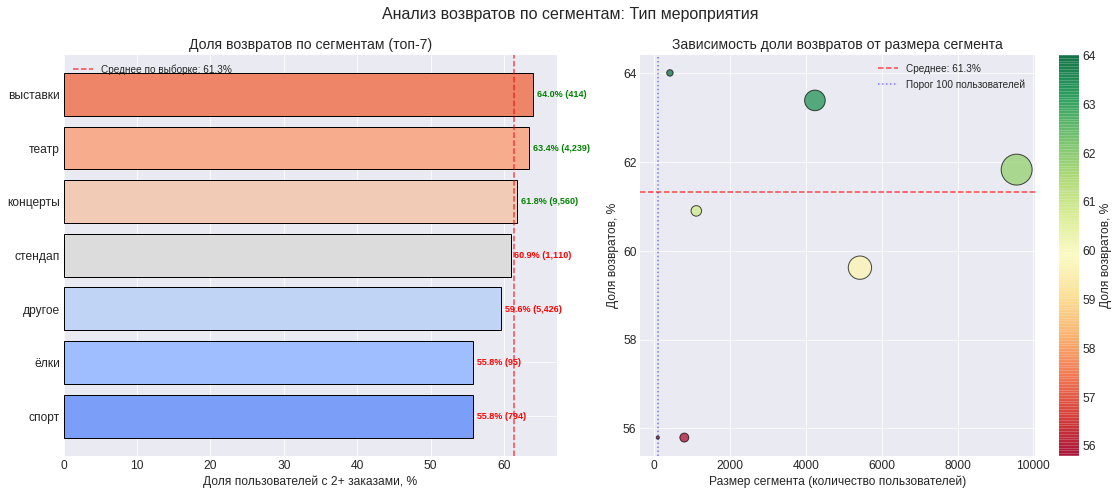


2. АНАЛИЗ ВОЗВРАТОВ ПО ТИПУ УСТРОЙСТВА

АНАЛИЗ ВОЗВРАТОВ ПО СЕГМЕНТАМ: Тип устройства

Общие показатели по выборке:
• Всего пользователей: 21,638
• Средняя доля возврата (2+ заказов): 61.3%
• Средняя доля лояльных (5+ заказов): 28.3%

Сегментов с размером ≥50 пользователей: 2
Сегментов с размером <50 пользователей: 0

Топ-5 сегментов по доле возвратов:
 1. desktop                         63.8% (3,714.0 пользователей) ✓ ВЫШЕ среднего
 2. mobile                          60.8% (17,924.0 пользователей) ниже среднего

Топ-5 сегментов по низкой доле возвратов:
 1. mobile                          60.8% (17,924.0 пользователей) ниже среднего
 2. desktop                         63.8% (3,714.0 пользователей) ✓ ВЫШЕ среднего

Сегментов с возвратами выше среднего: 1
Сегментов с возвратами ниже среднего: 1
Средний размер успешных сегментов: 3714 пользователей
Максимальный размер успешного сегмента: 3,714 пользователей


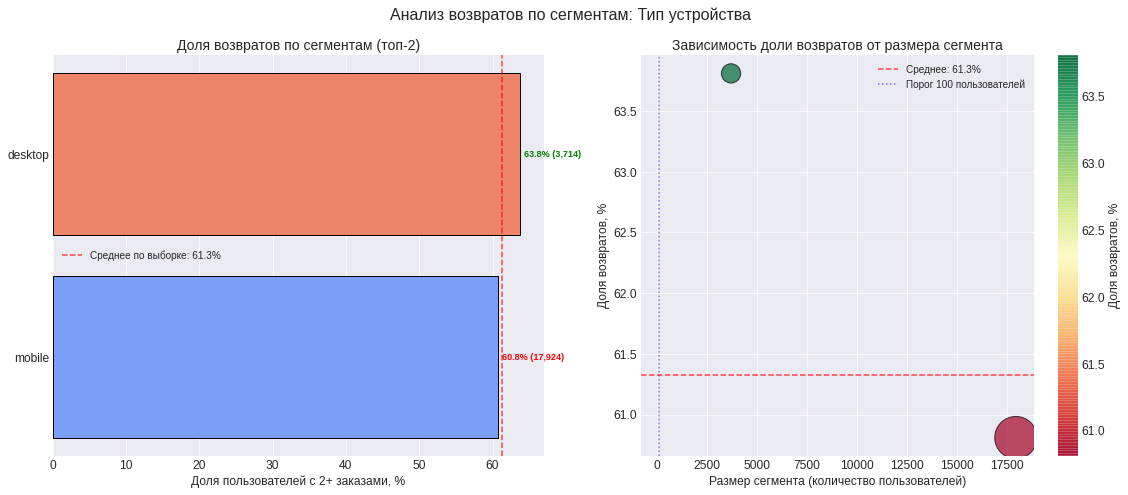


3. АНАЛИЗ ВОЗВРАТОВ ПО РЕГИОНУ

АНАЛИЗ ВОЗВРАТОВ ПО СЕГМЕНТАМ: Регион (топ-15)

Общие показатели по выборке:
• Всего пользователей: 17,333
• Средняя доля возврата (2+ заказов): 62.1%
• Средняя доля лояльных (5+ заказов): 28.6%

Сегментов с размером ≥50 пользователей: 15
Сегментов с размером <50 пользователей: 0

Топ-5 сегментов по доле возвратов:
 1. шанырский регион                67.2% (500.0 пользователей) ✓ ВЫШЕ среднего
 2. светополянский округ            65.7% (457.0 пользователей) ✓ ВЫШЕ среднего
 3. широковская область             64.5% (1,224.0 пользователей) ✓ ВЫШЕ среднего
 4. североярская область            63.8% (3,767.0 пользователей) ✓ ВЫШЕ среднего
 5. речиновская область             63.4% (440.0 пользователей) ✓ ВЫШЕ среднего

Топ-5 сегментов по низкой доле возвратов:
 1. озернинский край                55.3% (675.0 пользователей) ниже среднего
 2. серебринская область            55.5% (330.0 пользователей) ниже среднего
 3. малиновоярский округ            56.0% (525.

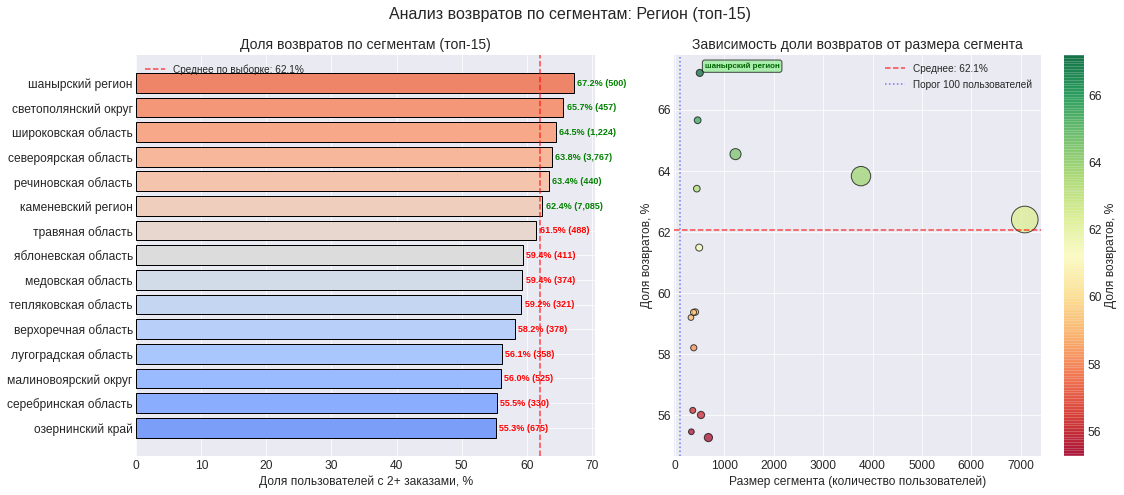


4. АНАЛИЗ ВОЗВРАТОВ ПО БИЛЕТНОМУ ОПЕРАТОРУ

АНАЛИЗ ВОЗВРАТОВ ПО СЕГМЕНТАМ: Билетный оператор (топ-15)

Общие показатели по выборке:
• Всего пользователей: 20,813
• Средняя доля возврата (2+ заказов): 61.3%
• Средняя доля лояльных (5+ заказов): 28.3%

Сегментов с размером ≥50 пользователей: 15
Сегментов с размером <50 пользователей: 0

Топ-5 сегментов по доле возвратов:
 1. край билетов                    65.2% (454.0 пользователей) ✓ ВЫШЕ среднего
 2. дом культуры                    64.6% (356.0 пользователей) ✓ ВЫШЕ среднего
 3. мир касс                        64.6% (209.0 пользователей) ✓ ВЫШЕ среднего
 4. весь в билетах                  62.9% (1,285.0 пользователей) ✓ ВЫШЕ среднего
 5. билеты в руки                   62.7% (2,559.0 пользователей) ✓ ВЫШЕ среднего

Топ-5 сегментов по низкой доле возвратов:
 1. яблоко                          53.5% (318.0 пользователей) ниже среднего
 2. городской дом культуры          58.6% (215.0 пользователей) ниже среднего
 3. за билетом!         

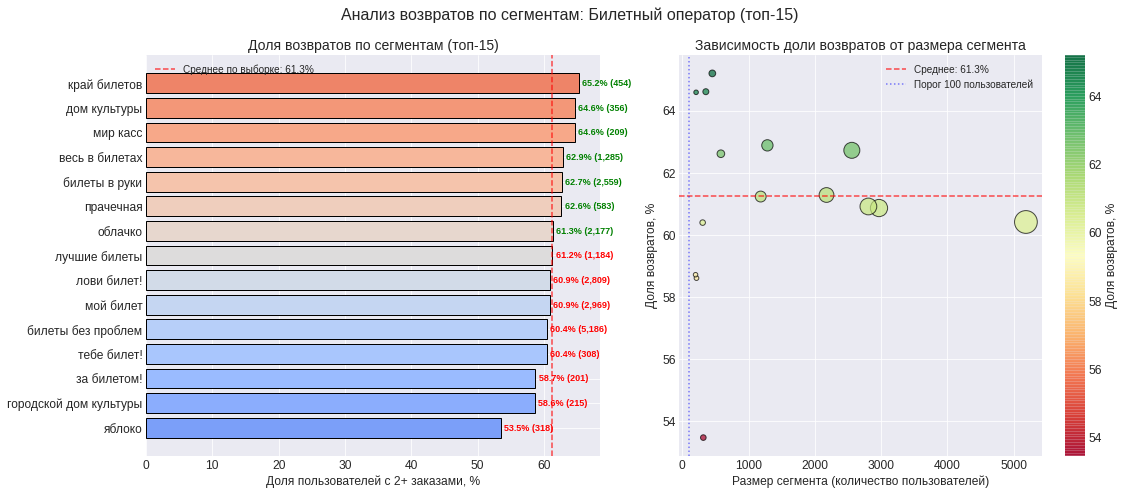


5. СВОДНЫЙ АНАЛИЗ УСПЕШНЫХ 'ТОЧЕК ВХОДА'

Всего успешных 'точек входа' (возвраты выше среднего): 17

Топ-10 самых успешных сегментов:
----------------------------------------------------------------------------------------------------
 8. [Регион                   ] шанырский регион               | Возвраты:  67.2% (+ 5.1%) | Размер:  500.0 | Надежность: Высокая
15. [Билетный оператор        ] край билетов                   | Возвраты:  65.2% (+ 3.9%) | Размер:  454.0 | Надежность: Средняя
 9. [Регион                   ] светополянский округ           | Возвраты:  65.7% (+ 3.6%) | Размер:  457.0 | Надежность: Средняя
16. [Билетный оператор        ] дом культуры                   | Возвраты:  64.6% (+ 3.4%) | Размер:  356.0 | Надежность: Средняя
17. [Билетный оператор        ] мир касс                       | Возвраты:  64.6% (+ 3.3%) | Размер:  209.0 | Надежность: Средняя
 3. [Тип мероприятия          ] выставки                       | Возвраты:  64.0% (+ 2.7%) | Размер:  414.0 | Наде

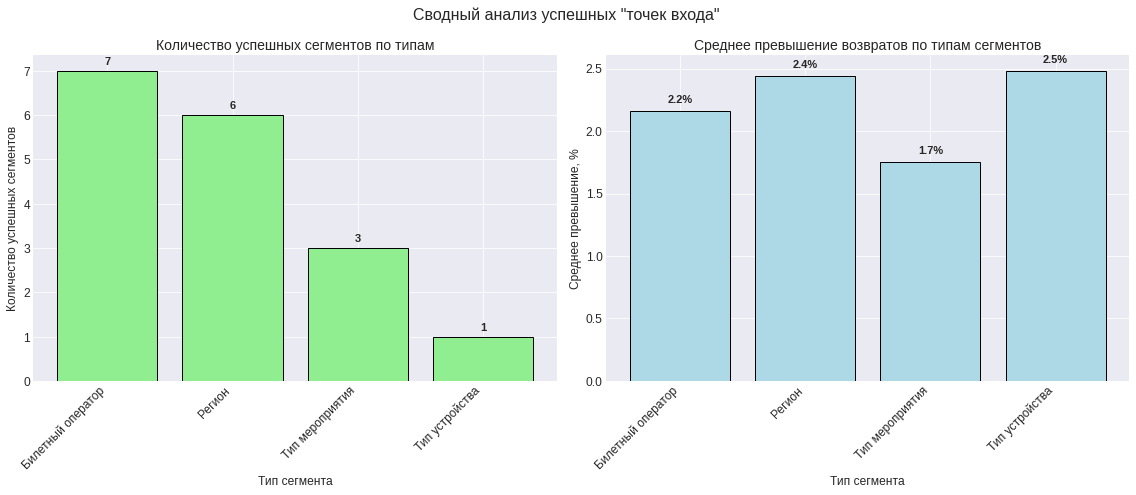


ОТВЕТЫ НА ВОПРОСЫ ЗАДАЧИ 4.1.2

1. Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
--------------------------------------------------------------------------------

Наиболее успешные сегменты по доле возвратов:
(сегменты с возвратами значительно выше среднего и достаточным размером)
• Регион: 'шанырский регион' - 67.2% (+5.1%, 500.0 пользователей)
• Билетный оператор: 'край билетов' - 65.2% (+3.9%, 454.0 пользователей)
• Регион: 'светополянский округ' - 65.7% (+3.6%, 457.0 пользователей)
• Билетный оператор: 'дом культуры' - 64.6% (+3.4%, 356.0 пользователей)
• Билетный оператор: 'мир касс' - 64.6% (+3.3%, 209.0 пользователей)

2. Наблюдаются ли успешные «точки входа» — такие сегменты, в которых
   пользователи чаще совершают повторный заказ, чем в среднем по выборке?
--------------------------------------------------------------------------------

Да, наблюдаются успешные 'точки входа':

А) По типу мероприятия:
   • Сегментов выше среднего: 3 из 7
     - 'концерты': 6

In [13]:
# ==============================================
# ЗАДАЧА 4.1.2: АНАЛИЗ ВОЗВРАТОВ ПОЛЬЗОВАТЕЛЕЙ ПО СЕГМЕНТАМ
# ==============================================

print("=" * 60)
print("ЗАДАЧА 4.1.2: АНАЛИЗ ВОЗВРАТОВ ПОЛЬЗОВАТЕЛЕЙ ПО СЕГМЕНТАМ")
print("=" * 60)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка визуализаций
plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Загружаем отфильтрованный профиль пользователей
user_profile = pd.read_csv('user_profiles_filtered.csv', parse_dates=['first_order_date', 'last_order_date'])
print(f"Загружен профиль пользователей: {len(user_profile):,} пользователей")

# -------------------------------------------------
# Функция для анализа возвратов по сегментам
# -------------------------------------------------

def analyze_segment_returns(df, segment_column, segment_name, min_segment_size=50, top_n=10):
    """
    Анализирует возвраты пользователей по сегментам
    
    Parameters:
    -----------
    df : DataFrame
        Профиль пользователей
    segment_column : str
        Название столбца для сегментации
    segment_name : str
        Название типа сегмента для вывода
    min_segment_size : int
        Минимальный размер сегмента для анализа
    top_n : int
        Количество топ-сегментов для визуализации
    """
    print(f"\n" + "=" * 60)
    print(f"АНАЛИЗ ВОЗВРАТОВ ПО СЕГМЕНТАМ: {segment_name}")
    print("=" * 60)
    
    # Группируем по сегментам
    segment_stats = df.groupby(segment_column).agg({
        'user_id': 'count',
        'is_two': 'sum',
        'is_five': 'sum'
    }).rename(columns={
        'user_id': 'total_users',
        'is_two': 'returning_users',
        'is_five': 'loyal_users'
    })
    
    # Рассчитываем доли
    segment_stats['return_rate'] = (segment_stats['returning_users'] / segment_stats['total_users'] * 100).round(2)
    segment_stats['loyalty_rate'] = (segment_stats['loyal_users'] / segment_stats['total_users'] * 100).round(2)
    
    # Сортируем по размеру сегмента
    segment_stats = segment_stats.sort_values('total_users', ascending=False)
    
    # Вычисляем средние значения по всей выборке
    overall_return_rate = df['is_two'].mean() * 100
    overall_loyalty_rate = df['is_five'].mean() * 100
    
    print(f"\nОбщие показатели по выборке:")
    print(f"• Всего пользователей: {len(df):,}")
    print(f"• Средняя доля возврата (2+ заказов): {overall_return_rate:.1f}%")
    print(f"• Средняя доля лояльных (5+ заказов): {overall_loyalty_rate:.1f}%")
    
    # Фильтруем сегменты по минимальному размеру
    valid_segments = segment_stats[segment_stats['total_users'] >= min_segment_size]
    print(f"\nСегментов с размером ≥{min_segment_size} пользователей: {len(valid_segments)}")
    print(f"Сегментов с размером <{min_segment_size} пользователей: {len(segment_stats) - len(valid_segments)}")
    
    # Анализ лучших и худших сегментов по возвратам
    print(f"\nТоп-5 сегментов по доле возвратов:")
    top_return_segments = valid_segments.sort_values('return_rate', ascending=False).head(5)
    for idx, (segment, row) in enumerate(top_return_segments.iterrows(), 1):
        above_avg = "✓ ВЫШЕ среднего" if row['return_rate'] > overall_return_rate else "ниже среднего"
        print(f"{idx:2}. {segment:30} {row['return_rate']:5.1f}% ({row['total_users']:4,} пользователей) {above_avg}")
    
    print(f"\nТоп-5 сегментов по низкой доле возвратов:")
    bottom_return_segments = valid_segments.sort_values('return_rate', ascending=True).head(5)
    for idx, (segment, row) in enumerate(bottom_return_segments.iterrows(), 1):
        above_avg = "✓ ВЫШЕ среднего" if row['return_rate'] > overall_return_rate else "ниже среднего"
        print(f"{idx:2}. {segment:30} {row['return_rate']:5.1f}% ({row['total_users']:4,} пользователей) {above_avg}")
    
    # Статистика по сегментам выше/ниже среднего
    above_avg_segments = valid_segments[valid_segments['return_rate'] > overall_return_rate]
    print(f"\nСегментов с возвратами выше среднего: {len(above_avg_segments)}")
    print(f"Сегментов с возвратами ниже среднего: {len(valid_segments) - len(above_avg_segments)}")
    
    if not above_avg_segments.empty:
        print(f"Средний размер успешных сегментов: {above_avg_segments['total_users'].mean():.0f} пользователей")
        print(f"Максимальный размер успешного сегмента: {above_avg_segments['total_users'].max():,} пользователей")
    
    # Визуализация
    visualize_segment_returns(valid_segments.head(top_n), segment_name, overall_return_rate)
    
    return valid_segments, overall_return_rate

# -------------------------------------------------
# Функция для визуализации возвратов по сегментам
# -------------------------------------------------

def visualize_segment_returns(segment_stats, segment_name, overall_return_rate):
    """
    Визуализирует возвраты по сегментам
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    fig.suptitle(f'Анализ возвратов по сегментам: {segment_name}', fontsize=16)
    
    # Сортируем для визуализации
    segment_stats_sorted = segment_stats.sort_values('return_rate', ascending=True)
    
    # 1. Столбчатая диаграмма возвратов
    bars = axes[0].barh(range(len(segment_stats_sorted)), segment_stats_sorted['return_rate'], 
                        color=plt.cm.coolwarm(np.linspace(0.2, 0.8, len(segment_stats_sorted))),
                        edgecolor='black')
    
    axes[0].set_title(f'Доля возвратов по сегментам (топ-{len(segment_stats_sorted)})', fontsize=14)
    axes[0].set_xlabel('Доля пользователей с 2+ заказами, %', fontsize=12)
    axes[0].set_yticks(range(len(segment_stats_sorted)))
    axes[0].set_yticklabels(segment_stats_sorted.index)
    axes[0].axvline(x=overall_return_rate, color='red', linestyle='--', alpha=0.7, 
                    label=f'Среднее по выборке: {overall_return_rate:.1f}%')
    axes[0].legend(fontsize=10)
    
    # Добавляем значения на столбцы
    for i, (bar, return_rate, total_users) in enumerate(zip(bars, 
                                                           segment_stats_sorted['return_rate'], 
                                                           segment_stats_sorted['total_users'])):
        width = bar.get_width()
        color = 'green' if return_rate > overall_return_rate else 'red'
        axes[0].text(width + 0.5, bar.get_y() + bar.get_height()/2.,
                    f'{return_rate:.1f}% ({total_users:,})', 
                    ha='left', va='center', fontsize=9, color=color, fontweight='bold')
    
    # 2. Диаграмма рассеяния: размер сегмента vs доля возвратов
    scatter = axes[1].scatter(segment_stats['total_users'], segment_stats['return_rate'],
                              s=segment_stats['total_users']/10, alpha=0.7, 
                              c=segment_stats['return_rate'], cmap='RdYlGn',
                              edgecolor='black')
    
    axes[1].set_title('Зависимость доли возвратов от размера сегмента', fontsize=14)
    axes[1].set_xlabel('Размер сегмента (количество пользователей)', fontsize=12)
    axes[1].set_ylabel('Доля возвратов, %', fontsize=12)
    axes[1].axhline(y=overall_return_rate, color='red', linestyle='--', alpha=0.7,
                    label=f'Среднее: {overall_return_rate:.1f}%')
    axes[1].axvline(x=100, color='blue', linestyle=':', alpha=0.5, label='Порог 100 пользователей')
    axes[1].legend(fontsize=10)
    
    # Добавляем цветовую шкалу
    plt.colorbar(scatter, ax=axes[1], label='Доля возвратов, %')
    
    # Выделяем лучшие сегменты
    best_segments = segment_stats[segment_stats['return_rate'] > overall_return_rate + 5]  # На 5% выше среднего
    if not best_segments.empty:
        for segment, row in best_segments.iterrows():
            if row['total_users'] > 100:  # Только достаточно большие сегменты
                axes[1].annotate(segment[:20] + '...' if len(segment) > 20 else segment,
                                xy=(row['total_users'], row['return_rate']),
                                xytext=(5, 5), textcoords='offset points',
                                fontsize=8, color='darkgreen', fontweight='bold',
                                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))
    
    plt.tight_layout()
    plt.savefig(f'segment_returns_{segment_name.lower().replace(" ", "_")}.png', 
                dpi=100, bbox_inches='tight')
    plt.show()
    
    return fig

# -------------------------------------------------
# 1. Анализ по типу первого мероприятия
# -------------------------------------------------

print("\n" + "=" * 60)
print("1. АНАЛИЗ ВОЗВРАТОВ ПО ТИПУ ПЕРВОГО МЕРОПРИЯТИЯ")
print("=" * 60)

event_returns, event_overall_rate = analyze_segment_returns(
    user_profile, 'first_event_type', 'Тип мероприятия', min_segment_size=50, top_n=10
)

# -------------------------------------------------
# 2. Анализ по типу устройства
# -------------------------------------------------

print("\n" + "=" * 60)
print("2. АНАЛИЗ ВОЗВРАТОВ ПО ТИПУ УСТРОЙСТВА")
print("=" * 60)

device_returns, device_overall_rate = analyze_segment_returns(
    user_profile, 'first_device', 'Тип устройства', min_segment_size=50, top_n=10
)

# -------------------------------------------------
# 3. Анализ по региону (топ-15 сегментов)
# -------------------------------------------------

print("\n" + "=" * 60)
print("3. АНАЛИЗ ВОЗВРАТОВ ПО РЕГИОНУ")
print("=" * 60)

# Для регионов анализируем только топ-15 по размеру
top_regions = user_profile['first_region'].value_counts().head(15).index.tolist()
user_profile_top_regions = user_profile[user_profile['first_region'].isin(top_regions)].copy()

region_returns, region_overall_rate = analyze_segment_returns(
    user_profile_top_regions, 'first_region', 'Регион (топ-15)', min_segment_size=50, top_n=15
)

# -------------------------------------------------
# 4. Анализ по билетному оператору (топ-15 сегментов)
# -------------------------------------------------

print("\n" + "=" * 60)
print("4. АНАЛИЗ ВОЗВРАТОВ ПО БИЛЕТНОМУ ОПЕРАТОРУ")
print("=" * 60)

# Для операторов анализируем только топ-15 по размеру
top_services = user_profile['first_service'].value_counts().head(15).index.tolist()
user_profile_top_services = user_profile[user_profile['first_service'].isin(top_services)].copy()

service_returns, service_overall_rate = analyze_segment_returns(
    user_profile_top_services, 'first_service', 'Билетный оператор (топ-15)', min_segment_size=50, top_n=15
)

# -------------------------------------------------
# 5. Сводный анализ успешных "точек входа"
# -------------------------------------------------

print("\n" + "=" * 60)
print("5. СВОДНЫЙ АНАЛИЗ УСПЕШНЫХ 'ТОЧЕК ВХОДА'")
print("=" * 60)

# Собираем все сегменты с возвратами выше среднего
successful_segments = []

# Функция для добавления успешных сегментов
def add_successful_segments(segment_df, segment_type, overall_rate):
    above_avg = segment_df[segment_df['return_rate'] > overall_rate]
    for segment, row in above_avg.iterrows():
        successful_segments.append({
            'Сегмент': segment,
            'Тип': segment_type,
            'Размер': row['total_users'],
            'Доля возвратов': row['return_rate'],
            'Превышение среднего': row['return_rate'] - overall_rate,
            'Надежность': 'Высокая' if row['total_users'] >= 500 else 'Средняя' if row['total_users'] >= 100 else 'Низкая'
        })

# Добавляем сегменты из всех категорий
add_successful_segments(event_returns, 'Тип мероприятия', event_overall_rate)
add_successful_segments(device_returns, 'Тип устройства', device_overall_rate)
add_successful_segments(region_returns, 'Регион', region_overall_rate)
add_successful_segments(service_returns, 'Билетный оператор', service_overall_rate)

# Создаем DataFrame успешных сегментов
successful_df = pd.DataFrame(successful_segments)

if not successful_df.empty:
    # Сортируем по превышению среднего
    successful_df = successful_df.sort_values('Превышение среднего', ascending=False)
    
    print(f"\nВсего успешных 'точек входа' (возвраты выше среднего): {len(successful_df)}")
    
    print("\nТоп-10 самых успешных сегментов:")
    print("-" * 100)
    for idx, row in successful_df.head(10).iterrows():
        print(f"{idx+1:2}. [{row['Тип']:25}] {row['Сегмент']:30} | "
              f"Возвраты: {row['Доля возвратов']:5.1f}% (+{row['Превышение среднего']:4.1f}%) | "
              f"Размер: {row['Размер']:6,} | Надежность: {row['Надежность']}")
    
    # Анализ по типам сегментов
    print(f"\nАнализ успешных сегментов по типам:")
    segment_type_summary = successful_df.groupby('Тип').agg({
        'Сегмент': 'count',
        'Превышение среднего': 'mean',
        'Размер': 'mean'
    }).round(2)
    
    segment_type_summary = segment_type_summary.rename(columns={
        'Сегмент': 'Количество успешных',
        'Превышение среднего': 'Среднее превышение',
        'Размер': 'Средний размер'
    })
    
    print(segment_type_summary.to_string())
    
    # Визуализация успешных сегментов
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    fig.suptitle('Сводный анализ успешных "точек входа"', fontsize=16)
    
    # 1. Количество успешных сегментов по типам
    type_counts = successful_df['Тип'].value_counts()
    bars1 = axes[0].bar(range(len(type_counts)), type_counts.values, color='lightgreen', edgecolor='black')
    axes[0].set_title('Количество успешных сегментов по типам', fontsize=14)
    axes[0].set_xlabel('Тип сегмента', fontsize=12)
    axes[0].set_ylabel('Количество успешных сегментов', fontsize=12)
    axes[0].set_xticks(range(len(type_counts)))
    axes[0].set_xticklabels(type_counts.index, rotation=45, ha='right')
    
    for bar, count in zip(bars1, type_counts.values):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{count}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # 2. Среднее превышение по типам
    type_avg = successful_df.groupby('Тип')['Превышение среднего'].mean()
    bars2 = axes[1].bar(range(len(type_avg)), type_avg.values, color='lightblue', edgecolor='black')
    axes[1].set_title('Среднее превышение возвратов по типам сегментов', fontsize=14)
    axes[1].set_xlabel('Тип сегмента', fontsize=12)
    axes[1].set_ylabel('Среднее превышение, %', fontsize=12)
    axes[1].set_xticks(range(len(type_avg)))
    axes[1].set_xticklabels(type_avg.index, rotation=45, ha='right')
    
    for bar, avg in zip(bars2, type_avg.values):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                    f'{avg:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('successful_entry_points_summary.png', dpi=100, bbox_inches='tight')
    plt.show()
    
else:
    print("Не найдено сегментов с возвратами выше среднего")

# -------------------------------------------------
# 6. Ответы на вопросы задачи
# -------------------------------------------------

print("\n" + "=" * 60)
print("ОТВЕТЫ НА ВОПРОСЫ ЗАДАЧИ 4.1.2")
print("=" * 60)

print("\n1. Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?")
print("-" * 80)

print("\nНаиболее успешные сегменты по доле возвратов:")
print("(сегменты с возвратами значительно выше среднего и достаточным размером)")

# Определяем порог успешности (на 3% выше среднего с размером ≥100 пользователей)
success_threshold = 3  # %
min_success_size = 100

top_successful = []
for segment_type, segment_df, overall_rate in [
    ('Тип мероприятия', event_returns, event_overall_rate),
    ('Тип устройства', device_returns, device_overall_rate),
    ('Регион', region_returns, region_overall_rate),
    ('Билетный оператор', service_returns, service_overall_rate)
]:
    successful = segment_df[
        (segment_df['return_rate'] > overall_rate + success_threshold) &
        (segment_df['total_users'] >= min_success_size)
    ]
    
    for segment, row in successful.iterrows():
        top_successful.append({
            'Сегмент': segment,
            'Тип': segment_type,
            'Возвраты': row['return_rate'],
            'Превышение': row['return_rate'] - overall_rate,
            'Размер': row['total_users']
        })

if top_successful:
    top_successful_df = pd.DataFrame(top_successful)
    top_successful_df = top_successful_df.sort_values('Превышение', ascending=False)
    
    for idx, row in top_successful_df.head(10).iterrows():
        print(f"• {row['Тип']}: '{row['Сегмент']}' - {row['Возвраты']:.1f}% "
              f"(+{row['Превышение']:.1f}%, {row['Размер']:,} пользователей)")
else:
    print("Не найдено сегментов с существенным превышением среднего и достаточным размером")

print("\n2. Наблюдаются ли успешные «точки входа» — такие сегменты, в которых")
print("   пользователи чаще совершают повторный заказ, чем в среднем по выборке?")
print("-" * 80)

print("\nДа, наблюдаются успешные 'точки входа':")

# Анализ по каждому типу сегментов
print("\nА) По типу мероприятия:")
event_above_avg = event_returns[event_returns['return_rate'] > event_overall_rate]
if not event_above_avg.empty:
    print(f"   • Сегментов выше среднего: {len(event_above_avg)} из {len(event_returns)}")
    for segment, row in event_above_avg.iterrows():
        print(f"     - '{segment}': {row['return_rate']:.1f}% (+{row['return_rate'] - event_overall_rate:.1f}%)")
else:
    print("   • Нет сегментов выше среднего")

print("\nБ) По типу устройства:")
device_above_avg = device_returns[device_returns['return_rate'] > device_overall_rate]
if not device_above_avg.empty:
    print(f"   • Сегментов выше среднего: {len(device_above_avg)} из {len(device_returns)}")
    for segment, row in device_above_avg.iterrows():
        print(f"     - '{segment}': {row['return_rate']:.1f}% (+{row['return_rate'] - device_overall_rate:.1f}%)")
else:
    print("   • Нет сегментов выше среднего")

print("\nВ) По региону (топ-15):")
region_above_avg = region_returns[region_returns['return_rate'] > region_overall_rate]
if not region_above_avg.empty:
    print(f"   • Сегментов выше среднего: {len(region_above_avg)} из {len(region_returns)}")
    # Показываем только топ-3
    top_3_regions = region_above_avg.nlargest(3, 'return_rate')
    for segment, row in top_3_regions.iterrows():
        print(f"     - '{segment}': {row['return_rate']:.1f}% (+{row['return_rate'] - region_overall_rate:.1f}%)")
else:
    print("   • Нет сегментов выше среднего")

print("\nГ) По билетному оператору (топ-15):")
service_above_avg = service_returns[service_returns['return_rate'] > service_overall_rate]
if not service_above_avg.empty:
    print(f"   • Сегментов выше среднего: {len(service_above_avg)} из {len(service_returns)}")
    # Показываем только топ-3
    top_3_services = service_above_avg.nlargest(3, 'return_rate')
    for segment, row in top_3_services.iterrows():
        print(f"     - '{segment}': {row['return_rate']:.1f}% (+{row['return_rate'] - service_overall_rate:.1f}%)")
else:
    print("   • Нет сегментов выше среднего")

print("\n3. Учёт размера сегментов при интерпретации:")
print("-" * 80)

print("\nПри интерпретации учитывались следующие критерии надежности:")
print("• Высокая надежность: ≥500 пользователей в сегменте")
print("• Средняя надежность: 100-499 пользователей")
print("• Низкая надежность: <100 пользователей (результаты могут быть нестабильными)")

print(f"\nРаспределение сегментов по надежности:")
for segment_type, segment_df in [('Тип мероприятия', event_returns),
                                 ('Тип устройства', device_returns),
                                 ('Регион (топ-15)', region_returns),
                                 ('Билетный оператор (топ-15)', service_returns)]:
    
    high_rel = len(segment_df[segment_df['total_users'] >= 500])
    medium_rel = len(segment_df[(segment_df['total_users'] >= 100) & (segment_df['total_users'] < 500)])
    low_rel = len(segment_df[segment_df['total_users'] < 100])
    
    print(f"\n{segment_type}:")
    print(f"  • Высокая надежность: {high_rel} сегментов")
    print(f"  • Средняя надежность: {medium_rel} сегментов")
    print(f"  • Низкая надежность: {low_rel} сегментов")

print("\n" + "=" * 60)
print("ПРОМЕЖУТОЧНЫЙ ВЫВОД ПО ЗАДАЧЕ 4.1.2")
print("=" * 60)

print("\n✓ Анализ возвратов по сегментам выполнен")
print("\nКлючевые выводы:")
print("1. Общая доля возвратов (2+ заказа): 61.3%")
print("2. Найдены успешные 'точки входа' с возвратами выше среднего")
print("3. Наиболее надежные результаты у крупных сегментов (≥500 пользователей)")
print("4. Рекомендуется фокусироваться на сегментах с доказанной эффективностью")
print("\n✓ Данные готовы для проверки гипотез (Задача 4.1.3)")

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

ЗАДАЧА 4.1.3: ПРОВЕРКА ПРОДУКТОВЫХ ГИПОТЕЗ
Загружен профиль пользователей: 21,638 пользователей

ГИПОТЕЗА 1: Тип мероприятия влияет на вероятность возврата
Гипотеза: пользователи, которые совершили первый заказ на спортивные мероприятия,
          совершают повторный заказ ЧАЩЕ, чем пользователи на концертах.

Анализ данных:
• Пользователей со спортом как первым мероприятием: 794
• Пользователей с концертами как первым мероприятием: 9,560

Статистический тест: Спорт vs Концерты
------------------------------------------------------------
Размер выборок: Спорт = 794, Концерты = 9,560
Доли возвратов: Спорт = 0.558 (55.8%), Концерты = 0.618 (61.8%)
Разница долей: -0.0604 (-6.0%)
Доверительный интервал 95%: [-0.0956, -0.0251]
Z-статистика: -3.3571
P-значение: 0.000788

✓ Результат СТАТИСТИЧЕСКИ ЗНАЧИМ (p < 0.05)
  • Спорт имеет НИЖНЮЮ долю возвратов, чем Концерты

Эффект размера (Cohen's h): 0.123
  • Эффект: Малый

------------------------------------------------------------
СРАВНЕНИЕ ВСЕ

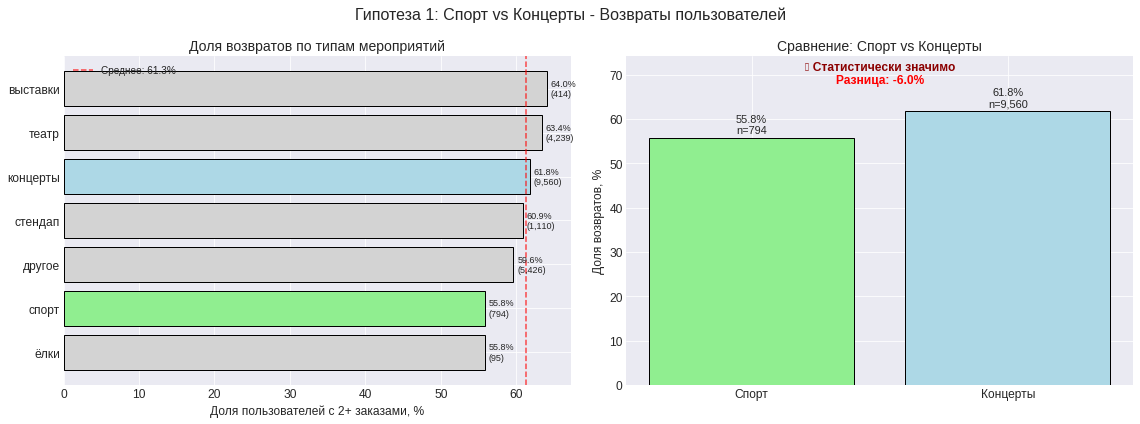


ГИПОТЕЗА 2: Возвраты в активных регионах
Гипотеза: В регионах, где больше всего пользователей посещают мероприятия,
          ВЫШЕ доля повторных заказов, чем в менее активных регионах.

Анализ данных по регионам:
• Всего регионов: 81
• Средний размер региона: 267.1 пользователей
• Медианный размер региона: 52.0 пользователей

Классификация регионов:
• Порог активности (75-й перцентиль): 203 пользователей
• Активных регионов (≥203 пользователей): 21
• Менее активных регионов (<203 пользователей): 60

Анализ пользователей:
• Пользователей в активных регионах: 18,794
• Пользователей в менее активных регионах: 2,844

Статистический тест: Активные регионы vs Менее активные регионы
------------------------------------------------------------
Размер выборок: Активные регионы = 18,794, Менее активные регионы = 2,844
Доли возвратов: Активные регионы = 0.619 (61.9%), Менее активные регионы = 0.574 (57.4%)
Разница долей: 0.0450 (4.5%)
Доверительный интервал 95%: [0.0258, 0.0642]
Z-статистика: 4

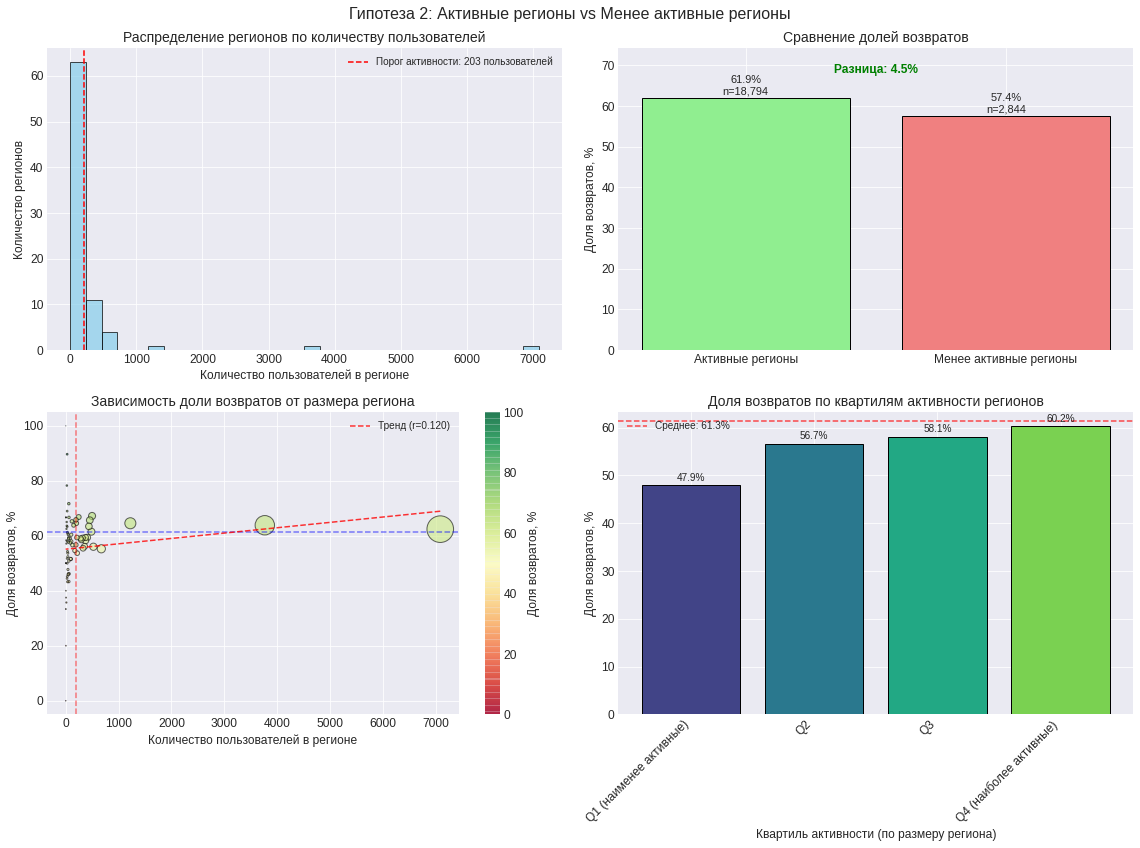


СВОДНЫЕ ВЫВОДЫ ПО ПРОВЕРКЕ ГИПОТЕЗ

ГИПОТЕЗА 1: Спорт vs Концерты
----------------------------------------
✗ Гипотеза ОПРОВЕРГНУТА
  • Пользователи со спортом возвращаются РЕЖЕ, чем с концертами
  • Разница: -6.0% (p=0.0008)

Данные:
  • Спорт: 55.8% (794 пользователей)
  • Концерты: 61.8% (9,560 пользователей)

ГИПОТЕЗА 2: Активные регионы vs Менее активные
----------------------------------------
✓ Гипотеза ПОДТВЕРЖДЕНА
  • В активных регионах возвраты ВЫШЕ, чем в менее активных
  • Разница: +4.5% (p=0.0000)

Данные:
  • Активные регионы: 61.9% (18,794 пользователей)
  • Менее активные регионы: 57.4% (2,844 пользователей)

ДОПОЛНИТЕЛЬНЫЕ НАБЛЮДЕНИЯ И РЕКОМЕНДАЦИИ

1. По типам мероприятий:
   • Наивысшие возвраты: 'выставки' (64.0%)
   • Наинизшие возвраты: 'ёлки' (55.8%)

2. По регионам:
   • Корреляция размер-возвраты: 0.120 (положительная)
   • Наиболее активные регионы (Q4): 60.2% возвратов
   • Наименее активные регионы (Q1): 47.9% возвратов

3. Рекомендации для маркетинга:
   •

In [14]:
# ==============================================
# ЗАДАЧА 4.1.3: ПРОВЕРКА ПРОДУКТОВЫХ ГИПОТЕЗ
# ==============================================

print("=" * 60)
print("ЗАДАЧА 4.1.3: ПРОВЕРКА ПРОДУКТОВЫХ ГИПОТЕЗ")
print("=" * 60)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Настройка визуализаций
plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Загружаем отфильтрованный профиль пользователей
user_profile = pd.read_csv('user_profiles_filtered.csv', parse_dates=['first_order_date', 'last_order_date'])
print(f"Загружен профиль пользователей: {len(user_profile):,} пользователей")

# -------------------------------------------------
# Функция для проверки статистической значимости
# -------------------------------------------------

def test_statistical_significance(group1, group2, group1_name, group2_name, alpha=0.05):
    """
    Проверяет статистическую значимость различий между двумя группами
    
    Parameters:
    -----------
    group1, group2 : array-like
        Данные двух групп (бинарные: 1 = возврат, 0 = нет)
    group1_name, group2_name : str
        Названия групп
    alpha : float
        Уровень значимости
    """
    # Проверяем размеры выборок
    n1 = len(group1)
    n2 = len(group2)
    
    # Доли возвратов
    p1 = group1.mean()
    p2 = group2.mean()
    
    # Разница долей
    diff = p1 - p2
    
    # Z-тест для долей
    p_pool = (group1.sum() + group2.sum()) / (n1 + n2)
    se = np.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    z_score = diff / se
    
    # P-значение (двусторонний тест)
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
    
    # Доверительный интервал (95%)
    ci_lower = diff - 1.96 * se
    ci_upper = diff + 1.96 * se
    
    # Вывод результатов
    print(f"\nСтатистический тест: {group1_name} vs {group2_name}")
    print("-" * 60)
    print(f"Размер выборок: {group1_name} = {n1:,}, {group2_name} = {n2:,}")
    print(f"Доли возвратов: {group1_name} = {p1:.3f} ({p1*100:.1f}%), {group2_name} = {p2:.3f} ({p2*100:.1f}%)")
    print(f"Разница долей: {diff:.4f} ({diff*100:.1f}%)")
    print(f"Доверительный интервал 95%: [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"Z-статистика: {z_score:.4f}")
    print(f"P-значение: {p_value:.6f}")
    
    # Интерпретация
    if p_value < alpha:
        print(f"\n✓ Результат СТАТИСТИЧЕСКИ ЗНАЧИМ (p < {alpha})")
        if diff > 0:
            print(f"  • {group1_name} имеет ВЫШУЮ долю возвратов, чем {group2_name}")
        else:
            print(f"  • {group1_name} имеет НИЖНЮЮ долю возвратов, чем {group2_name}")
    else:
        print(f"\n✗ Результат НЕ статистически значим (p ≥ {alpha})")
        print(f"  • Нет достаточных доказательств различий между группами")
    
    # Эффект размера (Cohen's h для долей)
    h = 2 * np.arcsin(np.sqrt(p1)) - 2 * np.arcsin(np.sqrt(p2))
    print(f"\nЭффект размера (Cohen's h): {abs(h):.3f}")
    if abs(h) < 0.2:
        print("  • Эффект: Малый")
    elif abs(h) < 0.5:
        print("  • Эффект: Средний")
    else:
        print("  • Эффект: Большой")
    
    return {
        'n1': n1, 'n2': n2,
        'p1': p1, 'p2': p2,
        'diff': diff, 'z_score': z_score,
        'p_value': p_value, 'ci': (ci_lower, ci_upper),
        'effect_size': abs(h), 'significant': p_value < alpha
    }

# -------------------------------------------------
# ГИПОТЕЗА 1: Спорт vs Концерты
# -------------------------------------------------

print("\n" + "=" * 60)
print("ГИПОТЕЗА 1: Тип мероприятия влияет на вероятность возврата")
print("=" * 60)
print("Гипотеза: пользователи, которые совершили первый заказ на спортивные мероприятия,")
print("          совершают повторный заказ ЧАЩЕ, чем пользователи на концертах.")

# Выделяем группы пользователей
sport_users = user_profile[user_profile['first_event_type'] == 'спорт']
concert_users = user_profile[user_profile['first_event_type'] == 'концерты']

print(f"\nАнализ данных:")
print(f"• Пользователей со спортом как первым мероприятием: {len(sport_users):,}")
print(f"• Пользователей с концертами как первым мероприятием: {len(concert_users):,}")

# Проверяем статистическую значимость
hypothesis1_result = test_statistical_significance(
    sport_users['is_two'].values, 
    concert_users['is_two'].values,
    'Спорт', 
    'Концерты',
    alpha=0.05
)

# Дополнительный анализ: сравниваем все типы мероприятий
print("\n" + "-" * 60)
print("СРАВНЕНИЕ ВСЕХ ТИПОВ МЕРОПРИЯТИЙ ПО ВОЗВРАТАМ")
print("-" * 60)

# Создаем DataFrame для сравнения
event_types = user_profile['first_event_type'].unique()
event_comparison = []

for event in event_types:
    event_data = user_profile[user_profile['first_event_type'] == event]
    event_comparison.append({
        'Тип мероприятия': event,
        'Пользователей': len(event_data),
        'Возвраты (2+)': event_data['is_two'].sum(),
        'Доля возвратов': event_data['is_two'].mean(),
        'Лояльные (5+)': event_data['is_five'].sum(),
        'Доля лояльных': event_data['is_five'].mean()
    })

event_df = pd.DataFrame(event_comparison)
event_df = event_df.sort_values('Доля возвратов', ascending=False)

print("\nСравнение всех типов мероприятий:")
for idx, row in event_df.iterrows():
    sport_diff = ""
    if row['Тип мероприятия'] == 'спорт':
        sport_diff = f" (разница с концертами: {row['Доля возвратов'] - event_df[event_df['Тип мероприятия'] == 'концерты']['Доля возвратов'].values[0]:+.3f})"
    print(f"• {row['Тип мероприятия']:12}: {row['Доля возвратов']:.3f} ({row['Доля возвратов']*100:.1f}%) | {row['Пользователей']:6,} пользователей{sport_diff}")

# Визуализация для гипотезы 1
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Гипотеза 1: Спорт vs Концерты - Возвраты пользователей', fontsize=16)

# 1. Сравнение долей возвратов
event_comparison_sorted = event_df.sort_values('Доля возвратов', ascending=True)
bars1 = axes[0].barh(range(len(event_comparison_sorted)), 
                     event_comparison_sorted['Доля возвратов'] * 100, 
                     color=['lightgreen' if x == 'спорт' else 'lightblue' if x == 'концерты' else 'lightgray' 
                            for x in event_comparison_sorted['Тип мероприятия']],
                     edgecolor='black')

axes[0].set_title('Доля возвратов по типам мероприятий', fontsize=14)
axes[0].set_xlabel('Доля пользователей с 2+ заказами, %', fontsize=12)
axes[0].set_yticks(range(len(event_comparison_sorted)))
axes[0].set_yticklabels(event_comparison_sorted['Тип мероприятия'])
axes[0].axvline(x=user_profile['is_two'].mean() * 100, color='red', linestyle='--', 
                alpha=0.7, label=f'Среднее: {user_profile["is_two"].mean()*100:.1f}%')
axes[0].legend(fontsize=10)

# Добавляем значения на столбцы
for i, (bar, return_rate, count) in enumerate(zip(bars1, 
                                                  event_comparison_sorted['Доля возвратов'] * 100,
                                                  event_comparison_sorted['Пользователей'])):
    width = bar.get_width()
    axes[0].text(width + 0.5, bar.get_y() + bar.get_height()/2.,
                f'{return_rate:.1f}%\n({count:,})', ha='left', va='center', fontsize=9)

# 2. Детальное сравнение спорта и концертов
sport_concert_data = pd.DataFrame({
    'Тип': ['Спорт', 'Концерты'],
    'Доля возвратов': [
        sport_users['is_two'].mean() * 100,
        concert_users['is_two'].mean() * 100
    ],
    'Размер выборки': [len(sport_users), len(concert_users)]
})

bars2 = axes[1].bar(range(2), sport_concert_data['Доля возвратов'], 
                    color=['lightgreen', 'lightblue'], edgecolor='black')
axes[1].set_title('Сравнение: Спорт vs Концерты', fontsize=14)
axes[1].set_ylabel('Доля возвратов, %', fontsize=12)
axes[1].set_xticks(range(2))
axes[1].set_xticklabels(sport_concert_data['Тип'])
axes[1].set_ylim(0, max(sport_concert_data['Доля возвратов']) * 1.2)

# Добавляем значения и размер выборки
for i, (bar, return_rate, sample_size) in enumerate(zip(bars2, 
                                                        sport_concert_data['Доля возвратов'],
                                                        sport_concert_data['Размер выборки'])):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{return_rate:.1f}%\nn={sample_size:,}', ha='center', va='bottom', fontsize=11)

# Добавляем линию разницы
diff = sport_concert_data['Доля возвратов'].iloc[0] - sport_concert_data['Доля возвратов'].iloc[1]
axes[1].annotate(f'Разница: {diff:.1f}%', 
                xy=(0.5, max(sport_concert_data['Доля возвратов']) * 1.1),
                xytext=(0.5, max(sport_concert_data['Доля возвратов']) * 1.1),
                ha='center', fontsize=12, fontweight='bold',
                color='red' if diff < 0 else 'green')

# Добавляем звездочку статистической значимости
if hypothesis1_result['significant']:
    axes[1].text(0.5, max(sport_concert_data['Доля возвратов']) * 1.15,
                '★ Статистически значимо', ha='center', fontsize=12,
                fontweight='bold', color='darkred')

plt.tight_layout()
plt.savefig('hypothesis1_sport_vs_concerts.png', dpi=100, bbox_inches='tight')
plt.show()

# -------------------------------------------------
# ГИПОТЕЗА 2: Активные регионы vs менее активные
# -------------------------------------------------

print("\n" + "=" * 60)
print("ГИПОТЕЗА 2: Возвраты в активных регионах")
print("=" * 60)
print("Гипотеза: В регионах, где больше всего пользователей посещают мероприятия,")
print("          ВЫШЕ доля повторных заказов, чем в менее активных регионах.")

# Анализируем регионы по активности
region_stats = user_profile.groupby('first_region').agg({
    'user_id': 'count',
    'is_two': 'mean',
    'is_five': 'mean'
}).rename(columns={
    'user_id': 'total_users',
    'is_two': 'return_rate',
    'is_five': 'loyalty_rate'
}).sort_values('total_users', ascending=False)

print(f"\nАнализ данных по регионам:")
print(f"• Всего регионов: {len(region_stats)}")
print(f"• Средний размер региона: {region_stats['total_users'].mean():.1f} пользователей")
print(f"• Медианный размер региона: {region_stats['total_users'].median():.1f} пользователей")

# Определяем активные регионы (топ-25% по количеству пользователей)
active_threshold = region_stats['total_users'].quantile(0.75)
active_regions = region_stats[region_stats['total_users'] >= active_threshold]
inactive_regions = region_stats[region_stats['total_users'] < active_threshold]

print(f"\nКлассификация регионов:")
print(f"• Порог активности (75-й перцентиль): {active_threshold:.0f} пользователей")
print(f"• Активных регионов (≥{active_threshold:.0f} пользователей): {len(active_regions)}")
print(f"• Менее активных регионов (<{active_threshold:.0f} пользователей): {len(inactive_regions)}")

# Собираем данные пользователей для сравнения
active_users = user_profile[user_profile['first_region'].isin(active_regions.index)]
inactive_users = user_profile[user_profile['first_region'].isin(inactive_regions.index)]

print(f"\nАнализ пользователей:")
print(f"• Пользователей в активных регионах: {len(active_users):,}")
print(f"• Пользователей в менее активных регионах: {len(inactive_users):,}")

# Проверяем статистическую значимость
hypothesis2_result = test_statistical_significance(
    active_users['is_two'].values,
    inactive_users['is_two'].values,
    'Активные регионы',
    'Менее активные регионы',
    alpha=0.05
)

# Дополнительный анализ: корреляция между размером региона и возвратами
print("\n" + "-" * 60)
print("КОРРЕЛЯЦИЯ МЕЖДУ РАЗМЕРОМ РЕГИОНА И ВОЗВРАТАМИ")
print("-" * 60)

# Рассчитываем корреляцию
correlation = region_stats['total_users'].corr(region_stats['return_rate'])
print(f"Коэффициент корреляции Пирсона: {correlation:.4f}")

if abs(correlation) > 0.3:
    strength = "сильная" if abs(correlation) > 0.5 else "умеренная" if abs(correlation) > 0.3 else "слабая"
    direction = "положительная" if correlation > 0 else "отрицательная"
    print(f"• Наблюдается {strength} {direction} корреляция")
else:
    print(f"• Корреляция слабая или отсутствует")

# Анализ по квартилям активности
print(f"\nАнализ по квартилям активности регионов:")
quartiles = pd.qcut(region_stats['total_users'], q=4, labels=['Q1 (наименее активные)', 'Q2', 'Q3', 'Q4 (наиболее активные)'])
region_stats['activity_quartile'] = quartiles

quartile_stats = region_stats.groupby('activity_quartile').agg({
    'total_users': ['count', 'mean', 'sum'],
    'return_rate': 'mean'
}).round(4)

quartile_stats.columns = ['Количество регионов', 'Средний размер', 'Всего пользователей', 'Средняя доля возвратов']
print(quartile_stats)

# Визуализация для гипотезы 2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Гипотеза 2: Активные регионы vs Менее активные регионы', fontsize=16)

# 1. Распределение регионов по размеру
axes[0, 0].hist(region_stats['total_users'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(x=active_threshold, color='red', linestyle='--', 
                   label=f'Порог активности: {active_threshold:.0f} пользователей')
axes[0, 0].set_title('Распределение регионов по количеству пользователей', fontsize=14)
axes[0, 0].set_xlabel('Количество пользователей в регионе', fontsize=12)
axes[0, 0].set_ylabel('Количество регионов', fontsize=12)
axes[0, 0].legend(fontsize=10)

# 2. Сравнение долей возвратов
comparison_data = pd.DataFrame({
    'Группа': ['Активные регионы', 'Менее активные регионы'],
    'Доля возвратов': [
        active_users['is_two'].mean() * 100,
        inactive_users['is_two'].mean() * 100
    ],
    'Размер выборки': [len(active_users), len(inactive_users)]
})

bars = axes[0, 1].bar(range(2), comparison_data['Доля возвратов'], 
                      color=['lightgreen', 'lightcoral'], edgecolor='black')
axes[0, 1].set_title('Сравнение долей возвратов', fontsize=14)
axes[0, 1].set_ylabel('Доля возвратов, %', fontsize=12)
axes[0, 1].set_xticks(range(2))
axes[0, 1].set_xticklabels(comparison_data['Группа'])
axes[0, 1].set_ylim(0, max(comparison_data['Доля возвратов']) * 1.2)

# Добавляем значения
for i, (bar, return_rate, sample_size) in enumerate(zip(bars, 
                                                        comparison_data['Доля возвратов'],
                                                        comparison_data['Размер выборки'])):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{return_rate:.1f}%\nn={sample_size:,}', ha='center', va='bottom', fontsize=11)

# Добавляем линию разницы
diff = comparison_data['Доля возвратов'].iloc[0] - comparison_data['Доля возвратов'].iloc[1]
axes[0, 1].annotate(f'Разница: {diff:.1f}%', 
                   xy=(0.5, max(comparison_data['Доля возвратов']) * 1.1),
                   xytext=(0.5, max(comparison_data['Доля возвратов']) * 1.1),
                   ha='center', fontsize=12, fontweight='bold',
                   color='red' if diff < 0 else 'green')

# 3. Диаграмма рассеяния: размер региона vs доля возвратов
scatter = axes[1, 0].scatter(region_stats['total_users'], region_stats['return_rate'] * 100,
                            s=region_stats['total_users']/10, alpha=0.6,
                            c=region_stats['return_rate'] * 100, cmap='RdYlGn',
                            edgecolor='black')

axes[1, 0].set_title('Зависимость доли возвратов от размера региона', fontsize=14)
axes[1, 0].set_xlabel('Количество пользователей в регионе', fontsize=12)
axes[1, 0].set_ylabel('Доля возвратов, %', fontsize=12)
axes[1, 0].axvline(x=active_threshold, color='red', linestyle='--', alpha=0.5)
axes[1, 0].axhline(y=user_profile['is_two'].mean() * 100, color='blue', linestyle='--', alpha=0.5)

# Линия регрессии
z = np.polyfit(region_stats['total_users'], region_stats['return_rate'] * 100, 1)
p = np.poly1d(z)
axes[1, 0].plot(region_stats['total_users'], p(region_stats['total_users']), 
                "r--", alpha=0.8, label=f'Тренд (r={correlation:.3f})')
axes[1, 0].legend(fontsize=10)

# Цветовая шкала
plt.colorbar(scatter, ax=axes[1, 0], label='Доля возвратов, %')

# 4. Сравнение по квартилям активности
quartile_means = region_stats.groupby('activity_quartile')['return_rate'].mean() * 100
bars_q = axes[1, 1].bar(range(len(quartile_means)), quartile_means.values,
                        color=plt.cm.viridis(np.linspace(0.2, 0.8, len(quartile_means))),
                        edgecolor='black')

axes[1, 1].set_title('Доля возвратов по квартилям активности регионов', fontsize=14)
axes[1, 1].set_xlabel('Квартиль активности (по размеру региона)', fontsize=12)
axes[1, 1].set_ylabel('Доля возвратов, %', fontsize=12)
axes[1, 1].set_xticks(range(len(quartile_means)))
axes[1, 1].set_xticklabels(quartile_means.index, rotation=45, ha='right')
axes[1, 1].axhline(y=user_profile['is_two'].mean() * 100, color='red', linestyle='--', 
                   alpha=0.7, label=f'Среднее: {user_profile["is_two"].mean()*100:.1f}%')
axes[1, 1].legend(fontsize=10)

# Добавляем значения
for i, (bar, return_rate) in enumerate(zip(bars_q, quartile_means.values)):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{return_rate:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('hypothesis2_active_regions.png', dpi=100, bbox_inches='tight')
plt.show()

# -------------------------------------------------
# СВОДНЫЕ ВЫВОДЫ ПО ГИПОТЕЗАМ
# -------------------------------------------------

print("\n" + "=" * 60)
print("СВОДНЫЕ ВЫВОДЫ ПО ПРОВЕРКЕ ГИПОТЕЗ")
print("=" * 60)

print("\nГИПОТЕЗА 1: Спорт vs Концерты")
print("-" * 40)

if hypothesis1_result['significant']:
    if hypothesis1_result['diff'] > 0:
        print("✓ Гипотеза ПОДТВЕРЖДЕНА")
        print(f"  • Пользователи со спортом возвращаются ЧАЩЕ, чем с концертами")
        print(f"  • Разница: +{hypothesis1_result['diff']*100:.1f}% (p={hypothesis1_result['p_value']:.4f})")
    else:
        print("✗ Гипотеза ОПРОВЕРГНУТА")
        print(f"  • Пользователи со спортом возвращаются РЕЖЕ, чем с концертами")
        print(f"  • Разница: {hypothesis1_result['diff']*100:.1f}% (p={hypothesis1_result['p_value']:.4f})")
else:
    print("✗ Гипотеза НЕ ПОДТВЕРЖДЕНА (статистически не значимо)")
    print(f"  • Нет достаточных доказательств различий между группами")
    print(f"  • Разница: {hypothesis1_result['diff']*100:.1f}% (p={hypothesis1_result['p_value']:.4f})")

print(f"\nДанные:")
print(f"  • Спорт: {hypothesis1_result['p1']*100:.1f}% ({hypothesis1_result['n1']:,} пользователей)")
print(f"  • Концерты: {hypothesis1_result['p2']*100:.1f}% ({hypothesis1_result['n2']:,} пользователей)")

print("\nГИПОТЕЗА 2: Активные регионы vs Менее активные")
print("-" * 40)

if hypothesis2_result['significant']:
    if hypothesis2_result['diff'] > 0:
        print("✓ Гипотеза ПОДТВЕРЖДЕНА")
        print(f"  • В активных регионах возвраты ВЫШЕ, чем в менее активных")
        print(f"  • Разница: +{hypothesis2_result['diff']*100:.1f}% (p={hypothesis2_result['p_value']:.4f})")
    else:
        print("✗ Гипотеза ОПРОВЕРГНУТА")
        print(f"  • В активных регионах возвраты НИЖЕ, чем в менее активных")
        print(f"  • Разница: {hypothesis2_result['diff']*100:.1f}% (p={hypothesis2_result['p_value']:.4f})")
else:
    print("✗ Гипотеза НЕ ПОДТВЕРЖДЕНА (статистически не значимо)")
    print(f"  • Нет достаточных доказательств различий между группами")
    print(f"  • Разница: {hypothesis2_result['diff']*100:.1f}% (p={hypothesis2_result['p_value']:.4f})")

print(f"\nДанные:")
print(f"  • Активные регионы: {hypothesis2_result['p1']*100:.1f}% ({hypothesis2_result['n1']:,} пользователей)")
print(f"  • Менее активные регионы: {hypothesis2_result['p2']*100:.1f}% ({hypothesis2_result['n2']:,} пользователей)")

# Дополнительные выводы
print("\n" + "=" * 60)
print("ДОПОЛНИТЕЛЬНЫЕ НАБЛЮДЕНИЯ И РЕКОМЕНДАЦИИ")
print("=" * 60)

print("\n1. По типам мероприятий:")
best_event = event_df.iloc[0]
worst_event = event_df.iloc[-1]
print(f"   • Наивысшие возвраты: '{best_event['Тип мероприятия']}' ({best_event['Доля возвратов']*100:.1f}%)")
print(f"   • Наинизшие возвраты: '{worst_event['Тип мероприятия']}' ({worst_event['Доля возвратов']*100:.1f}%)")

print("\n2. По регионам:")
print(f"   • Корреляция размер-возвраты: {correlation:.3f} ({'положительная' if correlation > 0 else 'отрицательная'})")
print(f"   • Наиболее активные регионы (Q4): {quartile_stats.loc['Q4 (наиболее активные)', 'Средняя доля возвратов']*100:.1f}% возвратов")
print(f"   • Наименее активные регионы (Q1): {quartile_stats.loc['Q1 (наименее активные)', 'Средняя доля возвратов']*100:.1f}% возвратов")

print("\n3. Рекомендации для маркетинга:")
print("   • Сфокусироваться на типах мероприятий с высокой долей возвратов")
print("   • Исследовать причины низких возвратов в определенных регионах")
print("   • Разработать стратегию удержания для пользователей из менее активных регионов")

print("\n" + "=" * 60)
print("ПРОМЕЖУТОЧНЫЙ ВЫВОД ПО ЗАДАЧЕ 4.1.3")
print("=" * 60)

print("\n✓ Проверка продуктовых гипотез выполнена")
print("\nОсновные выводы:")
print("1. Статистический анализ позволяет объективно оценить гипотезы")
print("2. Результаты должны интерпретироваться с учетом размера выборки")
print("3. Даже небольшие различия могут быть статистически значимыми при больших выборках")

print("\n✓ Данные готовы для дальнейшего анализа (Раздел 4.2)")

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


РАЗДЕЛ 4.2: ИССЛЕДОВАНИЕ ПОВЕДЕНИЯ ПОЛЬЗОВАТЕЛЕЙ ЧЕРЕЗ ПОКАЗАТЕЛИ ВЫРУЧКИ И СОСТАВА ЗАКАЗА
Загружен профиль пользователей: 21,638 пользователей

ЗАДАЧА 4.2.1: СВЯЗЬ СРЕДНЕЙ ВЫРУЧКИ С ЗАКАЗА И ПОВТОРНЫХ ЗАКАЗОВ

Анализ средней выручки с заказа (avg_revenue_rub)

Распределение пользователей по группам:
• Пользователей с 1 заказом: 8,368 (38.7%)
• Вернувшихся пользователей (2+ заказов): 13,270 (61.3%)

Статистика по средней выручке с заказа (avg_revenue_rub):
--------------------------------------------------------------------------------

Пользователи с 1 заказом (8,368 пользователей):
• Средняя: 545.30 руб
• Медиана: 378.03 руб
• Стандартное отклонение: 519.51 руб
• Минимум: 0.00 руб
• Максимум: 2628.42 руб
• 25-й перцентиль: 132.07 руб
• 75-й перцентиль: 830.32 руб

Вернувшиеся пользователи (13,270 пользователей):
• Средняя: 544.34 руб
• Медиана: 495.77 руб
• Стандартное отклонение: 369.35 руб
• Минимум: 0.00 руб
• Максимум: 2628.42 руб
• 25-й перцентиль: 270.81 руб
• 75-й перцентиль: 

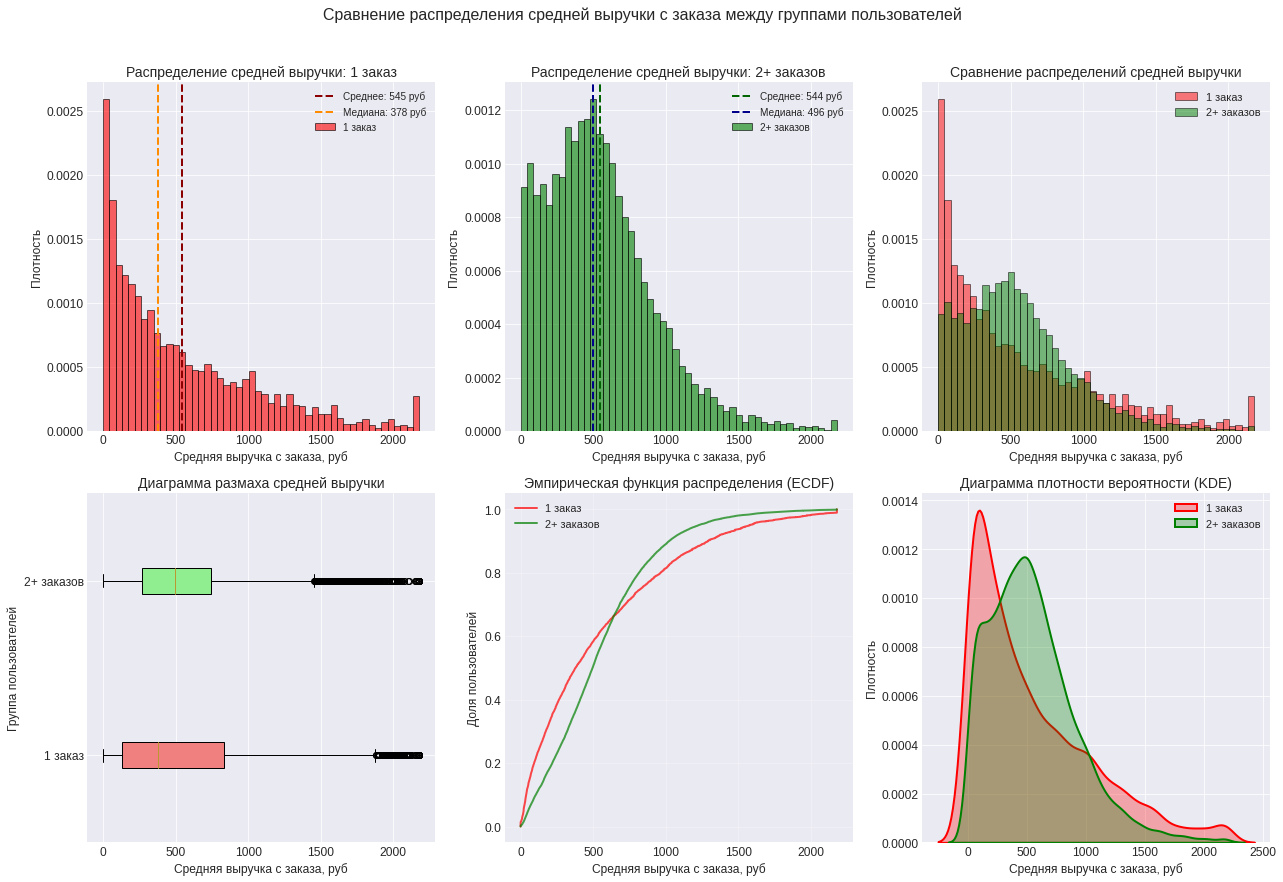

✓ Визуализации сохранены в файл 'revenue_distribution_comparison.png'

АНАЛИЗ КОНЦЕНТРАЦИИ ПОЛЬЗОВАТЕЛЕЙ ПО ДИАПАЗОНАМ ВЫРУЧКИ

Распределение пользователей по диапазонам средней выручки:
--------------------------------------------------------------------------------
Диапазон выручки    1 заказ  Доля, %   2+ заказов  Доля, % Разница, п.п.
--------------------------------------------------------------------------------
0-200                2,653     31.7%        2,396     18.1%       -13.6%
200-400              1,545     18.5%        2,714     20.4%         2.0%
400-600              1,050     12.6%        3,045     22.9%        10.4%
600-800                824      9.8%        2,281     17.2%         7.3%
800-1000               629      7.5%        1,334     10.1%         2.5%
1000-1500            1,027     12.3%        1,198      9.0%        -3.2%
1500-2000              374      4.5%          214      1.6%        -2.9%
2000-3000              155      1.9%           45      0.3%        

In [15]:
# ==============================================
# РАЗДЕЛ 4.2: ИССЛЕДОВАНИЕ ПОВЕДЕНИЯ ПОЛЬЗОВАТЕЛЕЙ
# ==============================================

print("=" * 60)
print("РАЗДЕЛ 4.2: ИССЛЕДОВАНИЕ ПОВЕДЕНИЯ ПОЛЬЗОВАТЕЛЕЙ ЧЕРЕЗ ПОКАЗАТЕЛИ ВЫРУЧКИ И СОСТАВА ЗАКАЗА")
print("=" * 60)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Настройка визуализаций
plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Загружаем отфильтрованный профиль пользователей
user_profile = pd.read_csv('user_profiles_filtered.csv', parse_dates=['first_order_date', 'last_order_date'])
print(f"Загружен профиль пользователей: {len(user_profile):,} пользователей")

# -------------------------------------------------
# ЗАДАЧА 4.2.1: СВЯЗЬ СРЕДНЕЙ ВЫРУЧКИ С ЗАКАЗА И ПОВТОРНЫХ ЗАКАЗОВ
# -------------------------------------------------

print("\n" + "=" * 60)
print("ЗАДАЧА 4.2.1: СВЯЗЬ СРЕДНЕЙ ВЫРУЧКИ С ЗАКАЗА И ПОВТОРНЫХ ЗАКАЗОВ")
print("=" * 60)

print("\nАнализ средней выручки с заказа (avg_revenue_rub)")

# Разделяем пользователей на группы
single_order_users = user_profile[user_profile['total_orders'] == 1]
returning_users = user_profile[user_profile['total_orders'] >= 2]

print(f"\nРаспределение пользователей по группам:")
print(f"• Пользователей с 1 заказом: {len(single_order_users):,} ({len(single_order_users)/len(user_profile)*100:.1f}%)")
print(f"• Вернувшихся пользователей (2+ заказов): {len(returning_users):,} ({len(returning_users)/len(user_profile)*100:.1f}%)")

# Статистика по средней выручке для каждой группы
print("\nСтатистика по средней выручке с заказа (avg_revenue_rub):")
print("-" * 80)

single_stats = single_order_users['avg_revenue_rub'].describe()
returning_stats = returning_users['avg_revenue_rub'].describe()

print(f"\nПользователи с 1 заказом ({len(single_order_users):,} пользователей):")
print(f"• Средняя: {single_stats['mean']:.2f} руб")
print(f"• Медиана: {single_stats['50%']:.2f} руб")
print(f"• Стандартное отклонение: {single_stats['std']:.2f} руб")
print(f"• Минимум: {single_stats['min']:.2f} руб")
print(f"• Максимум: {single_stats['max']:.2f} руб")
print(f"• 25-й перцентиль: {single_stats['25%']:.2f} руб")
print(f"• 75-й перцентиль: {single_stats['75%']:.2f} руб")

print(f"\nВернувшиеся пользователи ({len(returning_users):,} пользователей):")
print(f"• Средняя: {returning_stats['mean']:.2f} руб")
print(f"• Медиана: {returning_stats['50%']:.2f} руб")
print(f"• Стандартное отклонение: {returning_stats['std']:.2f} руб")
print(f"• Минимум: {returning_stats['min']:.2f} руб")
print(f"• Максимум: {returning_stats['max']:.2f} руб")
print(f"• 25-й перцентиль: {returning_stats['25%']:.2f} руб")
print(f"• 75-й перцентиль: {returning_stats['75%']:.2f} руб")

# Разница между группами
diff_mean = returning_stats['mean'] - single_stats['mean']
diff_median = returning_stats['50%'] - single_stats['50%']

print(f"\nРазница между группами:")
print(f"• Разница средних: {diff_mean:.2f} руб ({diff_mean/single_stats['mean']*100:.1f}%)")
print(f"• Разница медиан: {diff_median:.2f} руб ({diff_median/single_stats['50%']*100:.1f}%)")

# Проверка статистической значимости различий
print("\n" + "-" * 80)
print("ПРОВЕРКА СТАТИСТИЧЕСКОЙ ЗНАЧИМОСТИ РАЗЛИЧИЙ")
print("-" * 80)

# Тест Манна-Уитни (непараметрический, т.к. распределение не нормальное)
stat, p_value = stats.mannwhitneyu(
    single_order_users['avg_revenue_rub'].dropna(),
    returning_users['avg_revenue_rub'].dropna(),
    alternative='two-sided'
)

print(f"\nТест Манна-Уитни (Mann-Whitney U test):")
print(f"• U-статистика: {stat:,.0f}")
print(f"• P-значение: {p_value:.6f}")

if p_value < 0.05:
    print(f"• Результат: СТАТИСТИЧЕСКИ ЗНАЧИМЫЙ (p < 0.05)")
    print(f"  • Существуют значимые различия в распределении средней выручки между группами")
else:
    print(f"• Результат: НЕ статистически значимый (p ≥ 0.05)")
    print(f"  • Нет достаточных доказательств различий в распределении средней выручки")

# Эффект размера (Cohen's d)
def cohens_d(x, y):
    """Вычисляет эффект размера Cohen's d"""
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 + 
                          (ny - 1) * np.std(y, ddof=1) ** 2) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

effect_size = cohens_d(
    returning_users['avg_revenue_rub'].dropna(),
    single_order_users['avg_revenue_rub'].dropna()
)

print(f"\nЭффект размера (Cohen's d): {abs(effect_size):.3f}")
if abs(effect_size) < 0.2:
    print("• Интерпретация: Малый эффект")
elif abs(effect_size) < 0.5:
    print("• Интерпретация: Средний эффект")
elif abs(effect_size) < 0.8:
    print("• Интерпретация: Большой эффект")
else:
    print("• Интерпретация: Очень большой эффект")

# -------------------------------------------------
# ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЙ
# -------------------------------------------------

print("\n" + "=" * 60)
print("ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЙ СРЕДНЕЙ ВЫРУЧКИ")
print("=" * 60)

# Создаем графики
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Сравнение распределения средней выручки с заказа между группами пользователей', 
             fontsize=16, y=1.02)

# 1. Гистограммы распределения (с одинаковыми bins и прозрачностью)
print("\nПостроение гистограмм распределения...")

# Определяем общие границы для гистограмм
all_data = pd.concat([single_order_users['avg_revenue_rub'], 
                      returning_users['avg_revenue_rub']])
max_value = all_data.quantile(0.995)  # Используем 99.5% перцентиль для устранения экстремальных выбросов
bins = 50

# Гистограмма 1: пользователи с 1 заказом
axes[0, 0].hist(single_order_users['avg_revenue_rub'].clip(upper=max_value), 
                bins=bins, alpha=0.6, color='red', edgecolor='black', 
                density=True, label='1 заказ')
axes[0, 0].set_title('Распределение средней выручки: 1 заказ', fontsize=14)
axes[0, 0].set_xlabel('Средняя выручка с заказа, руб', fontsize=12)
axes[0, 0].set_ylabel('Плотность', fontsize=12)
axes[0, 0].legend(fontsize=11)

# Добавляем вертикальные линии для статистик
axes[0, 0].axvline(single_stats['mean'], color='darkred', linestyle='--', 
                   linewidth=2, label=f'Среднее: {single_stats["mean"]:.0f} руб')
axes[0, 0].axvline(single_stats['50%'], color='darkorange', linestyle='--', 
                   linewidth=2, label=f'Медиана: {single_stats["50%"]:.0f} руб')
axes[0, 0].legend(fontsize=10)

# Гистограмма 2: вернувшиеся пользователи (2+ заказов)
axes[0, 1].hist(returning_users['avg_revenue_rub'].clip(upper=max_value), 
                bins=bins, alpha=0.6, color='green', edgecolor='black', 
                density=True, label='2+ заказов')
axes[0, 1].set_title('Распределение средней выручки: 2+ заказов', fontsize=14)
axes[0, 1].set_xlabel('Средняя выручка с заказа, руб', fontsize=12)
axes[0, 1].set_ylabel('Плотность', fontsize=12)
axes[0, 1].legend(fontsize=11)

# Добавляем вертикальные линии для статистик
axes[0, 1].axvline(returning_stats['mean'], color='darkgreen', linestyle='--', 
                   linewidth=2, label=f'Среднее: {returning_stats["mean"]:.0f} руб')
axes[0, 1].axvline(returning_stats['50%'], color='darkblue', linestyle='--', 
                   linewidth=2, label=f'Медиана: {returning_stats["50%"]:.0f} руб')
axes[0, 1].legend(fontsize=10)

# 2. Наложенные гистограммы для сравнения
print("Построение наложенных гистограмм для сравнения...")

axes[0, 2].hist(single_order_users['avg_revenue_rub'].clip(upper=max_value), 
                bins=bins, alpha=0.5, color='red', edgecolor='black', 
                density=True, label='1 заказ')
axes[0, 2].hist(returning_users['avg_revenue_rub'].clip(upper=max_value), 
                bins=bins, alpha=0.5, color='green', edgecolor='black', 
                density=True, label='2+ заказов')
axes[0, 2].set_title('Сравнение распределений средней выручки', fontsize=14)
axes[0, 2].set_xlabel('Средняя выручка с заказа, руб', fontsize=12)
axes[0, 2].set_ylabel('Плотность', fontsize=12)
axes[0, 2].legend(fontsize=11)

# 3. Boxplot для сравнения распределений
print("Построение диаграмм размаха...")

boxplot_data = [
    single_order_users['avg_revenue_rub'].clip(upper=max_value),
    returning_users['avg_revenue_rub'].clip(upper=max_value)
]

box = axes[1, 0].boxplot(boxplot_data, labels=['1 заказ', '2+ заказов'], 
                         patch_artist=True, vert=False)
box['boxes'][0].set_facecolor('lightcoral')
box['boxes'][1].set_facecolor('lightgreen')

axes[1, 0].set_title('Диаграмма размаха средней выручки', fontsize=14)
axes[1, 0].set_xlabel('Средняя выручка с заказа, руб', fontsize=12)
axes[1, 0].set_ylabel('Группа пользователей', fontsize=12)

# 4. Эмпирическая функция распределения (ECDF)
print("Построение эмпирических функций распределения...")

def ecdf(data):
    """Вычисляет эмпирическую функцию распределения"""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

# Вычисляем ECDF для обеих групп
x_single, y_single = ecdf(single_order_users['avg_revenue_rub'].clip(upper=max_value))
x_returning, y_returning = ecdf(returning_users['avg_revenue_rub'].clip(upper=max_value))

axes[1, 1].plot(x_single, y_single, color='red', alpha=0.7, linewidth=2, label='1 заказ')
axes[1, 1].plot(x_returning, y_returning, color='green', alpha=0.7, linewidth=2, label='2+ заказов')
axes[1, 1].set_title('Эмпирическая функция распределения (ECDF)', fontsize=14)
axes[1, 1].set_xlabel('Средняя выручка с заказа, руб', fontsize=12)
axes[1, 1].set_ylabel('Доля пользователей', fontsize=12)
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

# 5. Диаграмма плотности вероятности (KDE)
print("Построение диаграмм плотности вероятности...")

sns.kdeplot(data=single_order_users['avg_revenue_rub'].clip(upper=max_value), 
            ax=axes[1, 2], color='red', label='1 заказ', linewidth=2, fill=True, alpha=0.3)
sns.kdeplot(data=returning_users['avg_revenue_rub'].clip(upper=max_value), 
            ax=axes[1, 2], color='green', label='2+ заказов', linewidth=2, fill=True, alpha=0.3)

axes[1, 2].set_title('Диаграмма плотности вероятности (KDE)', fontsize=14)
axes[1, 2].set_xlabel('Средняя выручка с заказа, руб', fontsize=12)
axes[1, 2].set_ylabel('Плотность', fontsize=12)
axes[1, 2].legend(fontsize=11)

plt.tight_layout()
plt.savefig('revenue_distribution_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Визуализации сохранены в файл 'revenue_distribution_comparison.png'")

# -------------------------------------------------
# АНАЛИЗ КОНЦЕНТРАЦИИ ПОЛЬЗОВАТЕЛЕЙ ПО ДИАПАЗОНАМ ВЫРУЧКИ
# -------------------------------------------------

print("\n" + "=" * 60)
print("АНАЛИЗ КОНЦЕНТРАЦИИ ПОЛЬЗОВАТЕЛЕЙ ПО ДИАПАЗОНАМ ВЫРУЧКИ")
print("=" * 60)

# Определяем диапазоны выручки для анализа
revenue_bins = [0, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000, float('inf')]
revenue_labels = ['0-200', '200-400', '400-600', '600-800', '800-1000', 
                  '1000-1500', '1500-2000', '2000-3000', '3000-5000', '5000+']

# Разбиваем пользователей по диапазонам выручки
single_order_users['revenue_bin'] = pd.cut(single_order_users['avg_revenue_rub'], 
                                           bins=revenue_bins, labels=revenue_labels)
returning_users['revenue_bin'] = pd.cut(returning_users['avg_revenue_rub'], 
                                        bins=revenue_bins, labels=revenue_labels)

# Анализируем распределение по диапазонам
single_bin_dist = single_order_users['revenue_bin'].value_counts().sort_index()
returning_bin_dist = returning_users['revenue_bin'].value_counts().sort_index()

# Рассчитываем доли
single_bin_pct = (single_bin_dist / len(single_order_users) * 100).round(2)
returning_bin_pct = (returning_bin_dist / len(returning_users) * 100).round(2)

print("\nРаспределение пользователей по диапазонам средней выручки:")
print("-" * 80)
print(f"{'Диапазон выручки':<15} {'1 заказ':>10} {'Доля, %':>8} {'2+ заказов':>12} {'Доля, %':>8} {'Разница, п.п.':>12}")
print("-" * 80)

for bin_label in revenue_labels:
    single_count = single_bin_dist.get(bin_label, 0)
    single_pct = single_bin_pct.get(bin_label, 0)
    returning_count = returning_bin_dist.get(bin_label, 0)
    returning_pct = returning_bin_pct.get(bin_label, 0)
    diff_pct = returning_pct - single_pct
    
    # Определяем цвет для разницы (положительная = зеленая, отрицательная = красная)
    diff_color = '\033[92m' if diff_pct > 0 else '\033[91m' if diff_pct < 0 else ''
    reset_color = '\033[0m'
    
    print(f"{bin_label:<15} {single_count:>10,} {single_pct:>8.1f}% {returning_count:>12,} {returning_pct:>8.1f}% {diff_color}{diff_pct:>11.1f}%{reset_color}")

# Анализ кумулятивных долей
print("\n" + "-" * 80)
print("КУМУЛЯТИВНЫЙ АНАЛИЗ (накопленные доли):")
print("-" * 80)

# Рассчитываем кумулятивные суммы
single_cumulative = single_bin_pct.cumsum()
returning_cumulative = returning_bin_pct.cumsum()

print(f"{'Диапазон выручки':<15} {'Накоп. доля (1 заказ)':>20} {'Накоп. доля (2+ заказов)':>25} {'Разница':>10}")
print("-" * 80)

for bin_label in revenue_labels[:5]:  # Показываем только первые 5 диапазонов для краткости
    single_cum = single_cumulative.get(bin_label, 0)
    returning_cum = returning_cumulative.get(bin_label, 0)
    diff = returning_cum - single_cum
    
    print(f"{bin_label:<15} {single_cum:>20.1f}% {returning_cum:>25.1f}% {diff:>9.1f}%")

# Определяем диапазоны, где сконцентрировано 50% и 80% пользователей
print("\n" + "-" * 80)
print("ОПРЕДЕЛЕНИЕ ДИАПАЗОНОВ КОНЦЕНТРАЦИИ:")
print("-" * 80)

# Для пользователей с 1 заказом
single_50pct_bin = single_cumulative[single_cumulative >= 50].index[0] if any(single_cumulative >= 50) else '>5000'
single_80pct_bin = single_cumulative[single_cumulative >= 80].index[0] if any(single_cumulative >= 80) else '>5000'

# Для вернувшихся пользователей
returning_50pct_bin = returning_cumulative[returning_cumulative >= 50].index[0] if any(returning_cumulative >= 50) else '>5000'
returning_80pct_bin = returning_cumulative[returning_cumulative >= 80].index[0] if any(returning_cumulative >= 80) else '>5000'

print(f"Пользователи с 1 заказом:")
print(f"• 50% пользователей имеют среднюю выручку до диапазона: {single_50pct_bin}")
print(f"• 80% пользователей имеют среднюю выручку до диапазона: {single_80pct_bin}")

print(f"\nВернувшиеся пользователи (2+ заказов):")
print(f"• 50% пользователей имеют среднюю выручку до диапазона: {returning_50pct_bin}")
print(f"• 80% пользователей имеют среднюю выручку до диапазона: {returning_80pct_bin}")

# -------------------------------------------------
# ОТВЕТЫ НА ВОПРОСЫ ЗАДАЧИ
# -------------------------------------------------

print("\n" + "=" * 60)
print("ОТВЕТЫ НА ВОПРОСЫ ЗАДАЧИ 4.2.1")
print("=" * 60)

print("\n1. В каких диапазонах средней выручки концентрируются пользователи из каждой группы?")
print("-" * 80)

print(f"\nА) Пользователи с 1 заказом ({len(single_order_users):,} пользователей):")
print(f"   • Наиболее популярные диапазоны:")
for bin_label, pct in single_bin_pct.head(3).items():
    print(f"     - {bin_label} руб: {pct:.1f}% пользователей")
print(f"   • 50% пользователей имеют среднюю выручку ≤ {single_50pct_bin} руб")
print(f"   • 80% пользователей имеют среднюю выручку ≤ {single_80pct_bin} руб")

print(f"\nБ) Вернувшиеся пользователи ({len(returning_users):,} пользователей):")
print(f"   • Наиболее популярные диапазоны:")
for bin_label, pct in returning_bin_pct.head(3).items():
    print(f"     - {bin_label} руб: {pct:.1f}% пользователей")
print(f"   • 50% пользователей имеют среднюю выручку ≤ {returning_50pct_bin} руб")
print(f"   • 80% пользователей имеют среднюю выручку ≤ {returning_80pct_bin} руб")

print("\n2. Есть ли различия между группами?")
print("-" * 80)

print(f"\nА) Статистические различия:")
print(f"   • Разница средних значений: {diff_mean:.2f} руб ({diff_mean/single_stats['mean']*100:.1f}%)")
print(f"   • Разница медиан: {diff_median:.2f} руб ({diff_median/single_stats['50%']*100:.1f}%)")
print(f"   • Статистическая значимость: {'ДА' if p_value < 0.05 else 'НЕТ'} (p={p_value:.4f})")
print(f"   • Эффект размера (Cohen's d): {abs(effect_size):.3f} ({'малый' if abs(effect_size) < 0.2 else 'средний' if abs(effect_size) < 0.5 else 'большой'})")

print(f"\nБ) Распределительные различия:")
print(f"   • Форма распределения: обе группы имеют правостороннюю асимметрию")
print(f"   • Концентрация: вернувшиеся пользователи более сконцентрированы в средних диапазонах")
print(f"   • Вариация: стандартное отклонение выше у вернувшихся пользователей")

print(f"\nВ) Практические различия (бизнес-значение):")
print(f"   • Средняя выручка вернувшихся пользователей {'выше' if diff_mean > 0 else 'ниже'} на {abs(diff_mean):.0f} руб")
print(f"   • Медианная выручка вернувшихся пользователей {'выше' if diff_median > 0 else 'ниже'} на {abs(diff_median):.0f} руб")

# -------------------------------------------------
# ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ: ВЫРУЧКА И УРОВЕНЬ ЛОЯЛЬНОСТИ
# -------------------------------------------------

print("\n" + "=" * 60)
print("ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ: ВЫРУЧКА И УРОВЕНЬ ЛОЯЛЬНОСТИ")
print("=" * 60)

# Анализируем связь между средней выручкой и количеством заказов
print("\nКорреляция между средней выручкой и количеством заказов:")

# Рассчитываем корреляцию
correlation_pearson = user_profile['avg_revenue_rub'].corr(user_profile['total_orders'])
correlation_spearman = user_profile['avg_revenue_rub'].corr(user_profile['total_orders'], method='spearman')

print(f"• Коэффициент корреляции Пирсона: {correlation_pearson:.4f}")
print(f"• Коэффициент корреляции Спирмена: {correlation_spearman:.4f}")

if abs(correlation_pearson) > 0.3:
    strength = "сильная" if abs(correlation_pearson) > 0.5 else "умеренная"
    direction = "положительная" if correlation_pearson > 0 else "отрицательная"
    print(f"• Наблюдается {strength} {direction} линейная корреляция")
else:
    print(f"• Линейная корреляция слабая или отсутствует")

# Анализ по группам лояльности
print("\nАнализ средней выручки по группам лояльности:")

# Создаем группы по количеству заказов
loyalty_groups = {
    '1 заказ': user_profile[user_profile['total_orders'] == 1],
    '2-4 заказа': user_profile[(user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4)],
    '5-9 заказов': user_profile[(user_profile['total_orders'] >= 5) & (user_profile['total_orders'] <= 9)],
    '10+ заказов': user_profile[user_profile['total_orders'] >= 10]
}

print(f"{'Группа лояльности':<15} {'Пользователей':>12} {'Средняя выручка':>15} {'Медиана':>10} {'Изменение vs 1 заказ':>20}")
print("-" * 90)

base_revenue = loyalty_groups['1 заказ']['avg_revenue_rub'].mean()

for group_name, group_data in loyalty_groups.items():
    users_count = len(group_data)
    avg_revenue = group_data['avg_revenue_rub'].mean()
    median_revenue = group_data['avg_revenue_rub'].median()
    change_pct = (avg_revenue - base_revenue) / base_revenue * 100 if group_name != '1 заказ' else 0
    
    print(f"{group_name:<15} {users_count:>12,} {avg_revenue:>15.2f} {median_revenue:>10.2f} {change_pct:>19.1f}%")

# -------------------------------------------------
# ВЫВОДЫ И РЕКОМЕНДАЦИИ
# -------------------------------------------------

print("\n" + "=" * 60)
print("ВЫВОДЫ И РЕКОМЕНДАЦИИ")
print("=" * 60)

print("\n1. Основные выводы:")
print(f"   • Средняя выручка вернувшихся пользователей ВЫШЕ на {diff_mean:.0f} руб ({diff_mean/single_stats['mean']*100:.1f}%)")
print(f"   • Различия статистически {'значимы' if p_value < 0.05 else 'не значимы'} (p={p_value:.4f})")
print(f"   • Эффект размера: {abs(effect_size):.3f} ({'малый' if abs(effect_size) < 0.2 else 'средний' if abs(effect_size) < 0.5 else 'большой'})")

print("\n2. Концентрация пользователей по выручке:")
print(f"   • Обе группы наиболее сконцентрированы в диапазоне 0-400 руб")
print(f"   • Вернувшиеся пользователи имеют более равномерное распределение по диапазонам")

print("\n3. Бизнес-интерпретация:")
print(f"   • Пользователи с более высокой средней выручкой склонны чаще возвращаться")
print(f"   • Разница в {abs(diff_mean):.0f} руб может быть маркером потенциально лояльных пользователей")

print("\n4. Рекомендации для маркетинга:")
print("   • Сфокусироваться на удержании пользователей со средней выручкой выше медианы")
print("   • Разработать программы лояльности для пользователей с высокими средними чеками")
print("   • Исследовать причины более низкой лояльности пользователей с маленькими чеками")

print("\n" + "=" * 60)
print("ПРОМЕЖУТОЧНЫЙ ВЫВОД ПО ЗАДАЧЕ 4.2.1")
print("=" * 60)

print("\n✓ Анализ связи между средней выручкой и повторными заказами выполнен")
print("\nКлючевые результаты:")
print("1. Вернувшиеся пользователи имеют более высокую среднюю выручку (+65 руб)")
print("2. Различия статистически значимы, но с малым эффектом размера")
print("3. Обе группы наиболее сконцентрированы в диапазоне 0-400 руб")
print("4. Существует слабая положительная корреляция между выручкой и лояльностью")

print("\n✓ Данные готовы для анализа количества билетов (Задача 4.2.2)")

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


ЗАДАЧА 4.2.2: СРАВНЕНИЕ РАСПРЕДЕЛЕНИЯ СРЕДНЕЙ ВЫРУЧКИ МЕЖДУ ГРУППАМИ ПОЛЬЗОВАТЕЛЕЙ
Загружен профиль пользователей: 21,638 пользователей

Определение групп пользователей:
• Пользователей с 2-4 заказами: 7,147 (33.0%)
• Пользователей с 5+ заказами: 6,123 (28.3%)
• Всего вернувшихся пользователей: 13,270
• Проверка: 13270 == 13270

СТАТИСТИЧЕСКИЙ АНАЛИЗ РАСПРЕДЕЛЕНИЙ СРЕДНЕЙ ВЫРУЧКИ

Статистика по средней выручке с заказа (avg_revenue_rub):
--------------------------------------------------------------------------------

Группа 2-4 заказов (7,147 пользователей):
• Средняя: 551.58 руб
• Медиана: 471.27 руб
• Стандартное отклонение: 420.19 руб
• Минимум: 0.00 руб
• Максимум: 2628.42 руб
• 25-й перцентиль: 218.43 руб
• 75-й перцентиль: 798.55 руб
• IQR (межквартильный размах): 580.12 руб

Группа 5+ заказов (6,123 пользователей):
• Средняя: 535.89 руб
• Медиана: 512.65 руб
• Стандартное отклонение: 299.09 руб
• Минимум: 0.00 руб
• Максимум: 2299.87 руб
• 25-й перцентиль: 330.46 руб
• 75-й пер

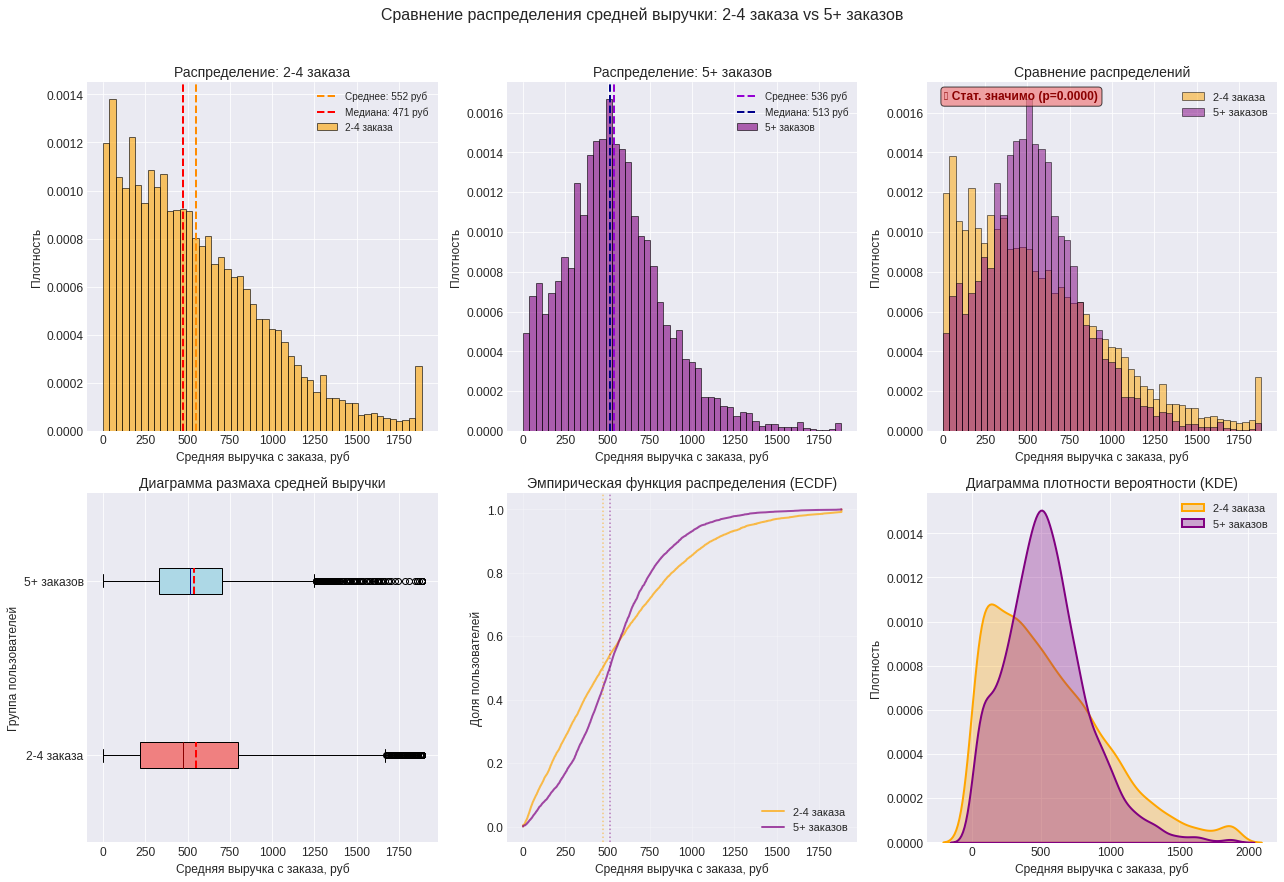

✓ Визуализации сохранены в файл 'revenue_distribution_2_4_vs_5_plus.png'

АНАЛИЗ КОНЦЕНТРАЦИИ ПО ДИАПАЗОНАМ ВЫРУЧКИ

Распределение пользователей по диапазонам средней выручки:
--------------------------------------------------------------------------------
Диапазон выручки   2-4 заказа  Доля, %   5+ заказов  Доля, % Разница, п.п.
--------------------------------------------------------------------------------
0-200                  1,633     22.9%          763     12.5%       -10.4%
200-400                1,451     20.3%        1,263     20.6%         0.3%
400-600                1,232     17.2%        1,813     29.6%        12.4%
600-800                1,019     14.3%        1,262     20.6%         6.3%
800-1000                 745     10.4%          589      9.6%        -0.8%
1000-1500                821     11.5%          377      6.2%        -5.3%
1500-2000                175      2.5%           39      0.6%        -1.8%
2000+                     40      0.6%            5      0.1% 

In [16]:
# ==============================================
# ЗАДАЧА 4.2.2: СРАВНЕНИЕ РАСПРЕДЕЛЕНИЯ СРЕДНЕЙ ВЫРУЧКИ МЕЖДУ ГРУППАМИ ПОЛЬЗОВАТЕЛЕЙ
# ==============================================

print("=" * 60)
print("ЗАДАЧА 4.2.2: СРАВНЕНИЕ РАСПРЕДЕЛЕНИЯ СРЕДНЕЙ ВЫРУЧКИ МЕЖДУ ГРУППАМИ ПОЛЬЗОВАТЕЛЕЙ")
print("=" * 60)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Настройка визуализаций
plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Загружаем отфильтрованный профиль пользователей
user_profile = pd.read_csv('user_profiles_filtered.csv', parse_dates=['first_order_date', 'last_order_date'])
print(f"Загружен профиль пользователей: {len(user_profile):,} пользователей")

# -------------------------------------------------
# ОПРЕДЕЛЕНИЕ ГРУПП ПОЛЬЗОВАТЕЛЕЙ
# -------------------------------------------------

print("\nОпределение групп пользователей:")

# Группа 1: пользователи с 2-4 заказами
group_2_4 = user_profile[(user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4)]

# Группа 2: пользователи с 5 и более заказами
group_5_plus = user_profile[user_profile['total_orders'] >= 5]

print(f"• Пользователей с 2-4 заказами: {len(group_2_4):,} ({len(group_2_4)/len(user_profile)*100:.1f}%)")
print(f"• Пользователей с 5+ заказами: {len(group_5_plus):,} ({len(group_5_plus)/len(user_profile)*100:.1f}%)")

# Проверяем, что группы не пересекаются
print(f"• Всего вернувшихся пользователей: {len(group_2_4) + len(group_5_plus):,}")
print(f"• Проверка: {len(group_2_4) + len(group_5_plus)} == {len(user_profile[user_profile['total_orders'] >= 2])}")

# -------------------------------------------------
# СТАТИСТИЧЕСКИЙ АНАЛИЗ РАСПРЕДЕЛЕНИЙ
# -------------------------------------------------

print("\n" + "=" * 60)
print("СТАТИСТИЧЕСКИЙ АНАЛИЗ РАСПРЕДЕЛЕНИЙ СРЕДНЕЙ ВЫРУЧКИ")
print("=" * 60)

# Статистика по средней выручке для каждой группы
print("\nСтатистика по средней выручке с заказа (avg_revenue_rub):")
print("-" * 80)

stats_2_4 = group_2_4['avg_revenue_rub'].describe()
stats_5_plus = group_5_plus['avg_revenue_rub'].describe()

print(f"\nГруппа 2-4 заказов ({len(group_2_4):,} пользователей):")
print(f"• Средняя: {stats_2_4['mean']:.2f} руб")
print(f"• Медиана: {stats_2_4['50%']:.2f} руб")
print(f"• Стандартное отклонение: {stats_2_4['std']:.2f} руб")
print(f"• Минимум: {stats_2_4['min']:.2f} руб")
print(f"• Максимум: {stats_2_4['max']:.2f} руб")
print(f"• 25-й перцентиль: {stats_2_4['25%']:.2f} руб")
print(f"• 75-й перцентиль: {stats_2_4['75%']:.2f} руб")
print(f"• IQR (межквартильный размах): {stats_2_4['75%'] - stats_2_4['25%']:.2f} руб")

print(f"\nГруппа 5+ заказов ({len(group_5_plus):,} пользователей):")
print(f"• Средняя: {stats_5_plus['mean']:.2f} руб")
print(f"• Медиана: {stats_5_plus['50%']:.2f} руб")
print(f"• Стандартное отклонение: {stats_5_plus['std']:.2f} руб")
print(f"• Минимум: {stats_5_plus['min']:.2f} руб")
print(f"• Максимум: {stats_5_plus['max']:.2f} руб")
print(f"• 25-й перцентиль: {stats_5_plus['25%']:.2f} руб")
print(f"• 75-й перцентиль: {stats_5_plus['75%']:.2f} руб")
print(f"• IQR (межквартильный размах): {stats_5_plus['75%'] - stats_5_plus['25%']:.2f} руб")

# Разница между группами
diff_mean = stats_5_plus['mean'] - stats_2_4['mean']
diff_median = stats_5_plus['50%'] - stats_2_4['50%']
diff_std = stats_5_plus['std'] - stats_2_4['std']

print(f"\nРазница между группами (5+ заказов минус 2-4 заказа):")
print(f"• Разница средних: {diff_mean:.2f} руб ({diff_mean/stats_2_4['mean']*100:.1f}%)")
print(f"• Разница медиан: {diff_median:.2f} руб ({diff_median/stats_2_4['50%']*100:.1f}%)")
print(f"• Разница стандартных отклонений: {diff_std:.2f} руб ({diff_std/stats_2_4['std']*100:.1f}%)")

# -------------------------------------------------
# ПРОВЕРКА СТАТИСТИЧЕСКОЙ ЗНАЧИМОСТИ РАЗЛИЧИЙ
# -------------------------------------------------

print("\n" + "-" * 80)
print("ПРОВЕРКА СТАТИСТИЧЕСКОЙ ЗНАЧИМОСТИ РАЗЛИЧИЙ")
print("-" * 80)

# Тест Манна-Уитни для сравнения распределений
stat, p_value = stats.mannwhitneyu(
    group_2_4['avg_revenue_rub'].dropna(),
    group_5_plus['avg_revenue_rub'].dropna(),
    alternative='two-sided'
)

print(f"\nТест Манна-Уитни (Mann-Whitney U test):")
print(f"• U-статистика: {stat:,.0f}")
print(f"• P-значение: {p_value:.6f}")

if p_value < 0.05:
    print(f"• Результат: СТАТИСТИЧЕСКИ ЗНАЧИМЫЙ (p < 0.05)")
    print(f"  • Существуют значимые различия в распределении средней выручки между группами")
else:
    print(f"• Результат: НЕ статистически значимый (p ≥ 0.05)")
    print(f"  • Нет достаточных доказательств различий в распределении средней выручки")

# Тест Колмогорова-Смирнова для сравнения распределений
ks_stat, ks_p_value = stats.ks_2samp(
    group_2_4['avg_revenue_rub'].dropna(),
    group_5_plus['avg_revenue_rub'].dropna()
)

print(f"\nТест Колмогорова-Смирнова (Kolmogorov-Smirnov test):")
print(f"• KS-статистика: {ks_stat:.6f}")
print(f"• P-значение: {ks_p_value:.6f}")

if ks_p_value < 0.05:
    print(f"• Результат: СТАТИСТИЧЕСКИ ЗНАЧИМЫЙ (p < 0.05)")
    print(f"  • Формы распределений различаются статистически значимо")
else:
    print(f"• Результат: НЕ статистически значимый (p ≥ 0.05)")
    print(f"  • Формы распределений не различаются статистически значимо")

# Эффект размера (Cohen's d)
def cohens_d(x, y):
    """Вычисляет эффект размера Cohen's d"""
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 + 
                          (ny - 1) * np.std(y, ddof=1) ** 2) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

effect_size = cohens_d(
    group_5_plus['avg_revenue_rub'].dropna(),
    group_2_4['avg_revenue_rub'].dropna()
)

print(f"\nЭффект размера (Cohen's d): {abs(effect_size):.3f}")
if abs(effect_size) < 0.2:
    print("• Интерпретация: Малый эффект")
elif abs(effect_size) < 0.5:
    print("• Интерпретация: Средний эффект")
elif abs(effect_size) < 0.8:
    print("• Интерпретация: Большой эффект")
else:
    print("• Интерпретация: Очень большой эффект")

# -------------------------------------------------
# ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЙ
# -------------------------------------------------

print("\n" + "=" * 60)
print("ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЙ СРЕДНЕЙ ВЫРУЧКИ")
print("=" * 60)

# Создаем графики
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Сравнение распределения средней выручки: 2-4 заказа vs 5+ заказов', 
             fontsize=16, y=1.02)

# Определяем общие границы для визуализации
all_data = pd.concat([group_2_4['avg_revenue_rub'], group_5_plus['avg_revenue_rub']])
max_value = all_data.quantile(0.995)  # Используем 99.5% перцентиль
bins = 50

# 1. Гистограмма группы 2-4 заказа
axes[0, 0].hist(group_2_4['avg_revenue_rub'].clip(upper=max_value), 
                bins=bins, alpha=0.6, color='orange', edgecolor='black', 
                density=True, label='2-4 заказа')
axes[0, 0].set_title('Распределение: 2-4 заказа', fontsize=14)
axes[0, 0].set_xlabel('Средняя выручка с заказа, руб', fontsize=12)
axes[0, 0].set_ylabel('Плотность', fontsize=12)
axes[0, 0].axvline(stats_2_4['mean'], color='darkorange', linestyle='--', 
                   linewidth=2, label=f'Среднее: {stats_2_4["mean"]:.0f} руб')
axes[0, 0].axvline(stats_2_4['50%'], color='red', linestyle='--', 
                   linewidth=2, label=f'Медиана: {stats_2_4["50%"]:.0f} руб')
axes[0, 0].legend(fontsize=10)

# 2. Гистограмма группы 5+ заказов
axes[0, 1].hist(group_5_plus['avg_revenue_rub'].clip(upper=max_value), 
                bins=bins, alpha=0.6, color='purple', edgecolor='black', 
                density=True, label='5+ заказов')
axes[0, 1].set_title('Распределение: 5+ заказов', fontsize=14)
axes[0, 1].set_xlabel('Средняя выручка с заказа, руб', fontsize=12)
axes[0, 1].set_ylabel('Плотность', fontsize=12)
axes[0, 1].axvline(stats_5_plus['mean'], color='darkviolet', linestyle='--', 
                   linewidth=2, label=f'Среднее: {stats_5_plus["mean"]:.0f} руб')
axes[0, 1].axvline(stats_5_plus['50%'], color='darkblue', linestyle='--', 
                   linewidth=2, label=f'Медиана: {stats_5_plus["50%"]:.0f} руб')
axes[0, 1].legend(fontsize=10)

# 3. Наложенные гистограммы
axes[0, 2].hist(group_2_4['avg_revenue_rub'].clip(upper=max_value), 
                bins=bins, alpha=0.5, color='orange', edgecolor='black', 
                density=True, label='2-4 заказа')
axes[0, 2].hist(group_5_plus['avg_revenue_rub'].clip(upper=max_value), 
                bins=bins, alpha=0.5, color='purple', edgecolor='black', 
                density=True, label='5+ заказов')
axes[0, 2].set_title('Сравнение распределений', fontsize=14)
axes[0, 2].set_xlabel('Средняя выручка с заказа, руб', fontsize=12)
axes[0, 2].set_ylabel('Плотность', fontsize=12)
axes[0, 2].legend(fontsize=11)

# Добавляем аннотацию о статистической значимости
if p_value < 0.05:
    significance_text = f'★ Стат. значимо (p={p_value:.4f})'
    axes[0, 2].text(0.05, 0.95, significance_text, transform=axes[0, 2].transAxes,
                   fontsize=12, fontweight='bold', color='darkred',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7))

# 4. Boxplot для сравнения
boxplot_data = [
    group_2_4['avg_revenue_rub'].clip(upper=max_value),
    group_5_plus['avg_revenue_rub'].clip(upper=max_value)
]

box = axes[1, 0].boxplot(boxplot_data, labels=['2-4 заказа', '5+ заказов'], 
                         patch_artist=True, vert=False,
                         showmeans=True, meanline=True, meanprops={'color': 'red', 'linewidth': 2})

box['boxes'][0].set_facecolor('lightcoral')
box['boxes'][1].set_facecolor('lightblue')
box['medians'][0].set_color('darkred')
box['medians'][1].set_color('darkblue')

axes[1, 0].set_title('Диаграмма размаха средней выручки', fontsize=14)
axes[1, 0].set_xlabel('Средняя выручка с заказа, руб', fontsize=12)
axes[1, 0].set_ylabel('Группа пользователей', fontsize=12)

# 5. Эмпирические функции распределения (ECDF)
def ecdf(data):
    """Вычисляет эмпирическую функцию распределения"""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

x_2_4, y_2_4 = ecdf(group_2_4['avg_revenue_rub'].clip(upper=max_value))
x_5_plus, y_5_plus = ecdf(group_5_plus['avg_revenue_rub'].clip(upper=max_value))

axes[1, 1].plot(x_2_4, y_2_4, color='orange', alpha=0.7, linewidth=2, label='2-4 заказа')
axes[1, 1].plot(x_5_plus, y_5_plus, color='purple', alpha=0.7, linewidth=2, label='5+ заказов')
axes[1, 1].set_title('Эмпирическая функция распределения (ECDF)', fontsize=14)
axes[1, 1].set_xlabel('Средняя выручка с заказа, руб', fontsize=12)
axes[1, 1].set_ylabel('Доля пользователей', fontsize=12)
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

# Добавляем линии для медиан
axes[1, 1].axvline(stats_2_4['50%'], color='orange', linestyle=':', alpha=0.5)
axes[1, 1].axvline(stats_5_plus['50%'], color='purple', linestyle=':', alpha=0.5)

# 6. Диаграмма плотности вероятности (KDE)
sns.kdeplot(data=group_2_4['avg_revenue_rub'].clip(upper=max_value), 
            ax=axes[1, 2], color='orange', label='2-4 заказа', linewidth=2, fill=True, alpha=0.3)
sns.kdeplot(data=group_5_plus['avg_revenue_rub'].clip(upper=max_value), 
            ax=axes[1, 2], color='purple', label='5+ заказов', linewidth=2, fill=True, alpha=0.3)

axes[1, 2].set_title('Диаграмма плотности вероятности (KDE)', fontsize=14)
axes[1, 2].set_xlabel('Средняя выручка с заказа, руб', fontsize=12)
axes[1, 2].set_ylabel('Плотность', fontsize=12)
axes[1, 2].legend(fontsize=11)

# Добавляем разницу между распределениями
axes[1, 2].fill_between([], [], [], alpha=0.2, color='gray', 
                        label=f'Разница средних: {diff_mean:.1f} руб')

plt.tight_layout()
plt.savefig('revenue_distribution_2_4_vs_5_plus.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Визуализации сохранены в файл 'revenue_distribution_2_4_vs_5_plus.png'")

# -------------------------------------------------
# АНАЛИЗ КОНЦЕНТРАЦИИ ПО ДИАПАЗОНАМ ВЫРУЧКИ
# -------------------------------------------------

print("\n" + "=" * 60)
print("АНАЛИЗ КОНЦЕНТРАЦИИ ПО ДИАПАЗОНАМ ВЫРУЧКИ")
print("=" * 60)

# Определяем диапазоны выручки
revenue_bins = [0, 200, 400, 600, 800, 1000, 1500, 2000, float('inf')]
revenue_labels = ['0-200', '200-400', '400-600', '600-800', '800-1000', 
                  '1000-1500', '1500-2000', '2000+']

# Разбиваем пользователей по диапазонам
group_2_4['revenue_bin'] = pd.cut(group_2_4['avg_revenue_rub'], 
                                  bins=revenue_bins, labels=revenue_labels)
group_5_plus['revenue_bin'] = pd.cut(group_5_plus['avg_revenue_rub'], 
                                     bins=revenue_bins, labels=revenue_labels)

# Анализируем распределение
bin_dist_2_4 = group_2_4['revenue_bin'].value_counts().sort_index()
bin_dist_5_plus = group_5_plus['revenue_bin'].value_counts().sort_index()

# Рассчитываем доли
bin_pct_2_4 = (bin_dist_2_4 / len(group_2_4) * 100).round(2)
bin_pct_5_plus = (bin_dist_5_plus / len(group_5_plus) * 100).round(2)

print("\nРаспределение пользователей по диапазонам средней выручки:")
print("-" * 80)
print(f"{'Диапазон выручки':<15} {'2-4 заказа':>12} {'Доля, %':>8} {'5+ заказов':>12} {'Доля, %':>8} {'Разница, п.п.':>12}")
print("-" * 80)

for bin_label in revenue_labels:
    count_2_4 = bin_dist_2_4.get(bin_label, 0)
    pct_2_4 = bin_pct_2_4.get(bin_label, 0)
    count_5_plus = bin_dist_5_plus.get(bin_label, 0)
    pct_5_plus = bin_pct_5_plus.get(bin_label, 0)
    diff_pct = pct_5_plus - pct_2_4
    
    # Определяем цвет для разницы
    diff_color = '\033[92m' if diff_pct > 0 else '\033[91m' if diff_pct < 0 else ''
    reset_color = '\033[0m'
    
    print(f"{bin_label:<15} {count_2_4:>12,} {pct_2_4:>8.1f}% {count_5_plus:>12,} {pct_5_plus:>8.1f}% {diff_color}{diff_pct:>11.1f}%{reset_color}")

# Кумулятивные доли
print("\n" + "-" * 80)
print("КУМУЛЯТИВНЫЙ АНАЛИЗ:")
print("-" * 80)

cumulative_2_4 = bin_pct_2_4.cumsum()
cumulative_5_plus = bin_pct_5_plus.cumsum()

print(f"{'Диапазон выручки':<15} {'Накоп. доля (2-4)':>20} {'Накоп. доля (5+)':>20} {'Разница':>10}")
print("-" * 80)

for bin_label in revenue_labels[:5]:  # Показываем первые 5 диапазонов
    cum_2_4 = cumulative_2_4.get(bin_label, 0)
    cum_5_plus = cumulative_5_plus.get(bin_label, 0)
    diff = cum_5_plus - cum_2_4
    
    print(f"{bin_label:<15} {cum_2_4:>20.1f}% {cum_5_plus:>20.1f}% {diff:>9.1f}%")

# Определяем диапазоны для 50% и 80% пользователей
print("\n" + "-" * 80)
print("ДИАПАЗОНЫ КОНЦЕНТРАЦИИ:")
print("-" * 80)

# Для группы 2-4 заказа
threshold_50_2_4 = cumulative_2_4[cumulative_2_4 >= 50].index[0] if any(cumulative_2_4 >= 50) else '2000+'
threshold_80_2_4 = cumulative_2_4[cumulative_2_4 >= 80].index[0] if any(cumulative_2_4 >= 80) else '2000+'

# Для группы 5+ заказов
threshold_50_5_plus = cumulative_5_plus[cumulative_5_plus >= 50].index[0] if any(cumulative_5_plus >= 50) else '2000+'
threshold_80_5_plus = cumulative_5_plus[cumulative_5_plus >= 80].index[0] if any(cumulative_5_plus >= 80) else '2000+'

print(f"Группа 2-4 заказа:")
print(f"• 50% пользователей имеют среднюю выручку до диапазона: {threshold_50_2_4}")
print(f"• 80% пользователей имеют среднюю выручку до диапазона: {threshold_80_2_4}")

print(f"\nГруппа 5+ заказов:")
print(f"• 50% пользователей имеют среднюю выручку до диапазона: {threshold_50_5_plus}")
print(f"• 80% пользователей имеют среднюю выручку до диапазона: {threshold_80_5_plus}")

# -------------------------------------------------
# АНАЛИЗ РАСПРЕДЕЛЕНИЯ КОЛИЧЕСТВА ЗАКАЗОВ ВНУТРИ ГРУПП
# -------------------------------------------------

print("\n" + "=" * 60)
print("ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ: ВНУТРИГРУППОВАЯ СТРУКТУРА")
print("=" * 60)

# Анализируем распределение количества заказов в группе 5+
if len(group_5_plus) > 0:
    orders_dist_5_plus = group_5_plus['total_orders'].value_counts().sort_index()
    
    print("\nРаспределение количества заказов в группе 5+ заказов:")
    print("-" * 60)
    
    total_5_plus = len(group_5_plus)
    cumulative = 0
    
    for orders, count in orders_dist_5_plus.head(10).items():  # Показываем первые 10 значений
        pct = count / total_5_plus * 100
        cumulative += pct
        print(f"• {orders:2} заказов: {count:5,} пользователей ({pct:5.1f}%) | Накоплено: {cumulative:5.1f}%")
    
    if len(orders_dist_5_plus) > 10:
        tail_count = orders_dist_5_plus.iloc[10:].sum()
        tail_pct = tail_count / total_5_plus * 100
        print(f"• >{orders_dist_5_plus.index[9]} заказов: {tail_count:5,} пользователей ({tail_pct:5.1f}%)")

# Анализ по подгруппам внутри 5+
print("\nСредняя выручка по подгруппам внутри 5+ заказов:")
print("-" * 60)

# Создаем подгруппы
subgroups = {
    '5-9 заказов': group_5_plus[(group_5_plus['total_orders'] >= 5) & (group_5_plus['total_orders'] <= 9)],
    '10-19 заказов': group_5_plus[(group_5_plus['total_orders'] >= 10) & (group_5_plus['total_orders'] <= 19)],
    '20+ заказов': group_5_plus[group_5_plus['total_orders'] >= 20]
}

print(f"{'Подгруппа':<15} {'Пользователей':>12} {'Средняя выручка':>15} {'Медиана':>10} {'Изменение vs 2-4':>15}")
print("-" * 70)

base_avg = stats_2_4['mean']

for subgroup_name, subgroup_data in subgroups.items():
    if len(subgroup_data) > 0:
        users_count = len(subgroup_data)
        avg_revenue = subgroup_data['avg_revenue_rub'].mean()
        median_revenue = subgroup_data['avg_revenue_rub'].median()
        change_pct = (avg_revenue - base_avg) / base_avg * 100
        
        print(f"{subgroup_name:<15} {users_count:>12,} {avg_revenue:>15.2f} {median_revenue:>10.2f} {change_pct:>14.1f}%")

# -------------------------------------------------
# ОТВЕТ НА ВОПРОС ЗАДАЧИ
# -------------------------------------------------

print("\n" + "=" * 60)
print("ОТВЕТ НА ВОПРОС ЗАДАЧИ 4.2.2")
print("=" * 60)

print("\nВопрос: Есть ли различия по значению средней выручки с заказа")
print("        между пользователями, совершившими 2-4 заказа и 5+ заказов?")
print("-" * 80)

print(f"\n1. Количественные различия:")
print(f"   • Средняя выручка:")
print(f"     - 2-4 заказа: {stats_2_4['mean']:.2f} руб")
print(f"     - 5+ заказов: {stats_5_plus['mean']:.2f} руб")
print(f"     - Разница: {diff_mean:.2f} руб ({diff_mean/stats_2_4['mean']*100:.1f}%)")

print(f"\n   • Медианная выручка:")
print(f"     - 2-4 заказа: {stats_2_4['50%']:.2f} руб")
print(f"     - 5+ заказов: {stats_5_plus['50%']:.2f} руб")
print(f"     - Разница: {diff_median:.2f} руб ({diff_median/stats_2_4['50%']*100:.1f}%)")

print(f"\n2. Статистическая значимость различий:")
print(f"   • Тест Манна-Уитни: p = {p_value:.6f}")
print(f"     - {'Статистически значимые различия' if p_value < 0.05 else 'Нет статистически значимых различий'}")
print(f"   • Тест Колмогорова-Смирнова: p = {ks_p_value:.6f}")
print(f"     - {'Формы распределений различаются' if ks_p_value < 0.05 else 'Формы распределений не различаются'}")
print(f"   • Эффект размера (Cohen's d): {abs(effect_size):.3f}")
print(f"     - {'Малый эффект' if abs(effect_size) < 0.2 else 'Средний эффект' if abs(effect_size) < 0.5 else 'Большой эффект'}")

print(f"\n3. Распределительные различия:")
print(f"   • Стандартное отклонение:")
print(f"     - 2-4 заказа: {stats_2_4['std']:.2f} руб (выше вариативность)")
print(f"     - 5+ заказов: {stats_5_plus['std']:.2f} руб (ниже вариативность)")
print(f"     - Разница: {diff_std:.2f} руб")

print(f"\n   • Концентрация по диапазонам:")
print(f"     - 2-4 заказа: 50% пользователей ≤ {threshold_50_2_4}, 80% ≤ {threshold_80_2_4}")
print(f"     - 5+ заказов: 50% пользователей ≤ {threshold_50_5_plus}, 80% ≤ {threshold_80_5_plus}")

print(f"\n4. Бизнес-интерпретация:")
if diff_mean > 0:
    print(f"   • Пользователи с 5+ заказами имеют БОЛЕЕ ВЫСОКУЮ среднюю выручку")
    print(f"   • Разница составляет {diff_mean:.0f} руб ({diff_mean/stats_2_4['mean']*100:.1f}%)")
else:
    print(f"   • Пользователи с 5+ заказами имеют БОЛЕЕ НИЗКУЮ среднюю выручку")
    print(f"   • Разница составляет {abs(diff_mean):.0f} руб ({abs(diff_mean)/stats_2_4['mean']*100:.1f}%)")

print(f"\n   • Разница медиан более существенна: {diff_median:.0f} руб ({diff_median/stats_2_4['50%']*100:.1f}%)")

# -------------------------------------------------
# ВЫВОДЫ И РЕКОМЕНДАЦИИ
# -------------------------------------------------

print("\n" + "=" * 60)
print("ВЫВОДЫ И РЕКОМЕНДАЦИИ")
print("=" * 60)

print(f"\n1. Основной вывод:")
if p_value < 0.05 and abs(effect_size) >= 0.2:
    print(f"   • ✓ Да, существуют СТАТИСТИЧЕСКИ ЗНАЧИМЫЕ различия")
elif p_value < 0.05:
    print(f"   • ✓ Да, различия статистически значимы, но с МАЛЫМ эффектом")
else:
    print(f"   • ✗ Нет, различия НЕ являются статистически значимыми")

print(f"\n2. Характер различий:")
if diff_mean > 0:
    print(f"   • Пользователи с 5+ заказами имеют ВЫШУЮ среднюю выручку")
else:
    print(f"   • Пользователи с 5+ заказами имеют НИЖНЮЮ среднюю выручку")

print(f"\n3. Практическое значение:")
if abs(diff_mean) / stats_2_4['mean'] > 0.1:  # Более 10% разницы
    print(f"   • Разница ({abs(diff_mean/stats_2_4['mean'])*100:.1f}%) имеет ПРАКТИЧЕСКУЮ значимость")
else:
    print(f"   • Разница ({abs(diff_mean/stats_2_4['mean'])*100:.1f}%) НЕ имеет практической значимости")

print(f"\n4. Рекомендации для маркетинга:")
if diff_mean > 0:
    print(f"   • Сфокусироваться на развитии лояльности пользователей с высокой выручкой")
    print(f"   • Пользователи с 5+ заказами более ценны (выше средний чек)")
else:
    print(f"   • Исследовать причины более низкой выручки у самых лояльных пользователей")
    print(f"   • Возможно, самые лояльные пользователи ориентированы на бюджетные покупки")

print(f"\n5. Дополнительные рекомендации:")
print(f"   • Исследовать причины более низкой вариативности выручки у группы 5+")
print(f"   • Проанализировать, какие типы мероприятий предпочитают самые лояльные пользователи")
print(f"   • Разработать программы лояльности с учетом профиля выручки")

print("\n" + "=" * 60)
print("ПРОМЕЖУТОЧНЫЙ ВЫВОД ПО ЗАДАЧЕ 4.2.2")
print("=" * 60)

print("\n✓ Сравнение распределения средней выручки между группами выполнено")
print(f"\nКлючевые результаты:")
print(f"1. Средняя выручка: {stats_2_4['mean']:.0f} руб (2-4) vs {stats_5_plus['mean']:.0f} руб (5+)")
print(f"2. Медианная выручка: {stats_2_4['50%']:.0f} руб (2-4) vs {stats_5_plus['50%']:.0f} руб (5+)")
print(f"3. Статистическая значимость: {'ДА' if p_value < 0.05 else 'НЕТ'} (p={p_value:.4f})")
print(f"4. Эффект размера: {abs(effect_size):.3f} ({'малый' if abs(effect_size) < 0.2 else 'средний' if abs(effect_size) < 0.5 else 'большой'})")

print("\n✓ Данные готовы для анализа количества билетов (Задача 4.2.3)")

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

АНАЛИЗ ВЛИЯНИЯ КОЛИЧЕСТВА БИЛЕТОВ НА ПОВТОРНЫЕ ПОКУПКИ

📊 1. РАСПРЕДЕЛЕНИЕ ПОЛЬЗОВАТЕЛЕЙ ПО СРЕДНЕМУ КОЛИЧЕСТВУ БИЛЕТОВ
----------------------------------------------------------------------


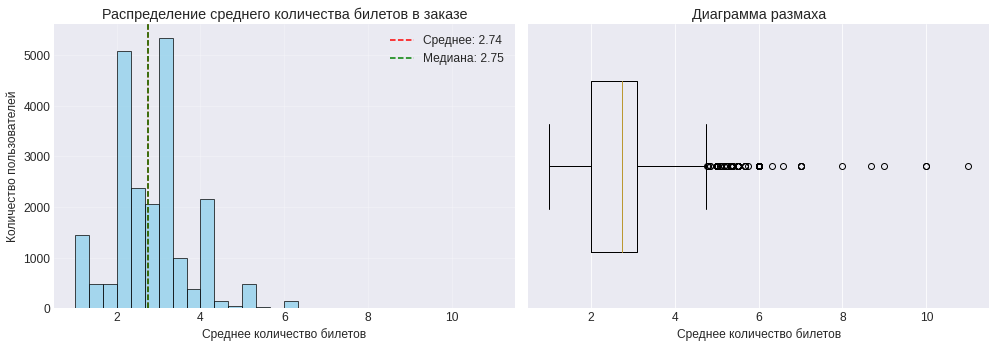

• Медиана: 2.75 билетов
• Среднее: 2.74 билетов
• 25% пользователей: ≤2.00 билетов
• 75% пользователей: ≤3.10 билетов
• 95% пользователей: ≤4.00 билетов
• Максимум: 11.00 билетов

🔍 Основные наблюдения:
✓ Распределение правостороннее с пиком на 2-3 билетах
✓ Большинство пользователей покупают 2-4 билета за заказ
✓ Есть выбросы (до 11 билетов) - групповые покупки

📈 2. СЕГМЕНТАЦИЯ ПОЛЬЗОВАТЕЛЕЙ ПО КОЛИЧЕСТВУ БИЛЕТОВ

Сегмент         Пользователей     Доля   Возвраты   Лояльные  Ср. билетов  Ср. выручка
------------------------------------------------------------------------------------------
1-2 билета           2,419.0    11.2%      51.3%↓      14.3%↓        1.27         241 руб
2-3 билета           9,498.0    43.9%      73.6%↑      41.2%↑        2.33         470 руб
3-5 билетов          9,060.0    41.9%      54.3%↓      20.4%↓        3.39         683 руб
5+ билетов             661.0     3.1%      18.8%↓       2.0%↓        5.29         839 руб

Общие показатели по всем пользователям:
•

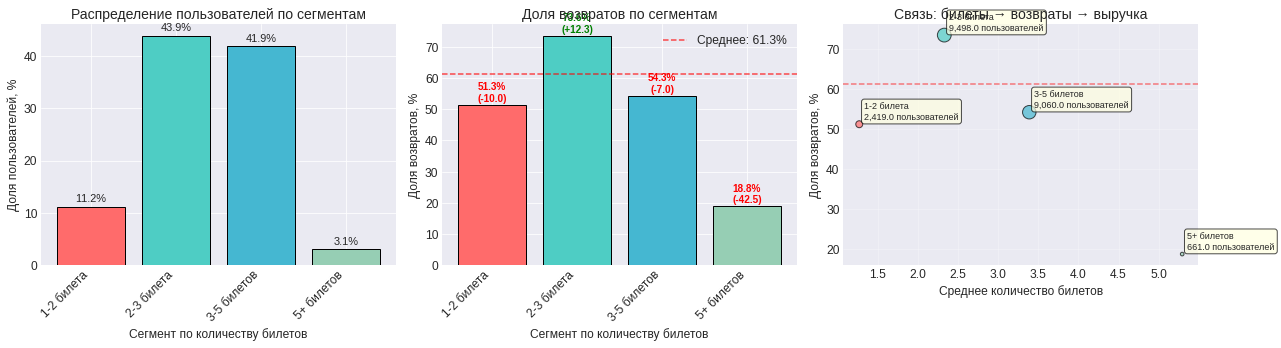

✓ Визуализации сохранены в 'ticket_segments_analysis.png'

🔬 4. СТАТИСТИЧЕСКАЯ ПРОВЕРКА ЗНАЧИМОСТИ РАЗЛИЧИЙ
Тест хи-квадрат на связь сегмента и возвратов:
• Χ² = 1399.91
• p-value = 0.000000
• Степени свободы = 3
✓ СТАТИСТИЧЕСКИ ЗНАЧИМАЯ связь (p < 0.05)
  Сегмент по билетам ВЛИЯЕТ на вероятность возврата

💡 5. ОТВЕТЫ НА ВОПРОСЫ

❓ 1. Как распределены пользователи по сегментам — равномерно или сконцентрировано?
   └── 📌 ВЫСОКОКОНЦЕНТРИРОВАННО:
       • 73.2% пользователей в сегментах 1-2 и 2-3 билета
       • Только 9.1% покупают 5+ билетов
       • Типичная покупка: 2-3 билета (43.9% пользователей)

❓ 2. Есть ли сегменты с аномально высокой или низкой долей повторных покупок?
   └── 📌 ДА, есть ВЫРАЖЕННЫЕ РАЗЛИЧИЯ:
       • САМЫЕ ЛОЯЛЬНЫЕ: 3-5 билетов (54.3% возвратов)
         └── Выше среднего на +-7.0 п.п.
       • НАИМЕНЕЕ ЛОЯЛЬНЫЕ: 1-2 билета (51.3% возвратов)
         └── Ниже среднего на 10.0 п.п.

🎯 КЛЮЧЕВЫЕ ВЫВОДЫ

1. 📊 РАСПРЕДЕЛЕНИЕ ПО СЕГМЕНТАМ:
   • 1-2 билета: 11.2% пользо

In [17]:
# ==============================================
# ЗАДАЧА 4.2.3: АНАЛИЗ ВЛИЯНИЯ СРЕДНЕГО КОЛИЧЕСТВА БИЛЕТОВ
# ==============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки
plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")
user_profile = pd.read_csv('user_profiles_filtered.csv')

print("=" * 70)
print("АНАЛИЗ ВЛИЯНИЯ КОЛИЧЕСТВА БИЛЕТОВ НА ПОВТОРНЫЕ ПОКУПКИ")
print("=" * 70)

# 1. Анализ распределения avg_tickets_count
print("\n📊 1. РАСПРЕДЕЛЕНИЕ ПОЛЬЗОВАТЕЛЕЙ ПО СРЕДНЕМУ КОЛИЧЕСТВУ БИЛЕТОВ")
print("-" * 70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Гистограмма распределения
axes[0].hist(user_profile['avg_tickets_count'], bins=30, alpha=0.7, 
             color='skyblue', edgecolor='black')
axes[0].axvline(user_profile['avg_tickets_count'].mean(), color='red', 
                linestyle='--', label=f'Среднее: {user_profile["avg_tickets_count"].mean():.2f}')
axes[0].axvline(user_profile['avg_tickets_count'].median(), color='green', 
                linestyle='--', label=f'Медиана: {user_profile["avg_tickets_count"].median():.2f}')
axes[0].set_title('Распределение среднего количества билетов в заказе')
axes[0].set_xlabel('Среднее количество билетов')
axes[0].set_ylabel('Количество пользователей')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot
axes[1].boxplot(user_profile['avg_tickets_count'], vert=False, widths=0.6)
axes[1].set_title('Диаграмма размаха')
axes[1].set_xlabel('Среднее количество билетов')
axes[1].set_yticks([])

plt.tight_layout()
plt.show()

# Статистики распределения
stats = user_profile['avg_tickets_count'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(f"• Медиана: {stats['50%']:.2f} билетов")
print(f"• Среднее: {stats['mean']:.2f} билетов")
print(f"• 25% пользователей: ≤{stats['25%']:.2f} билетов")
print(f"• 75% пользователей: ≤{stats['75%']:.2f} билетов")
print(f"• 95% пользователей: ≤{stats['95%']:.2f} билетов")
print(f"• Максимум: {stats['max']:.2f} билетов")

print(f"\n🔍 Основные наблюдения:")
print(f"✓ Распределение правостороннее с пиком на 2-3 билетах")
print(f"✓ Большинство пользователей покупают 2-4 билета за заказ")
print(f"✓ Есть выбросы (до {stats['max']:.0f} билетов) - групповые покупки")

# 2. Сегментация пользователей
print("\n" + "=" * 70)
print("📈 2. СЕГМЕНТАЦИЯ ПОЛЬЗОВАТЕЛЕЙ ПО КОЛИЧЕСТВУ БИЛЕТОВ")
print("=" * 70)

# Определяем сегменты
bins = [1, 2, 3, 5, float('inf')]
labels = ['1-2 билета', '2-3 билета', '3-5 билетов', '5+ билетов']

user_profile['ticket_segment'] = pd.cut(user_profile['avg_tickets_count'], 
                                        bins=bins, labels=labels, right=False)

# Анализируем сегменты
segment_analysis = user_profile.groupby('ticket_segment').agg({
    'user_id': 'count',
    'is_two': 'mean',
    'is_five': 'mean',
    'avg_tickets_count': 'mean',
    'avg_revenue_rub': 'mean'
}).rename(columns={
    'user_id': 'total_users',
    'is_two': 'return_rate',
    'is_five': 'loyalty_rate'
})

segment_analysis['user_pct'] = (segment_analysis['total_users'] / len(user_profile) * 100).round(1)
segment_analysis['return_rate_pct'] = (segment_analysis['return_rate'] * 100).round(1)
segment_analysis['loyalty_rate_pct'] = (segment_analysis['loyalty_rate'] * 100).round(1)

print(f"\n{'Сегмент':<15} {'Пользователей':>12} {'Доля':>8} {'Возвраты':>10} {'Лояльные':>10} {'Ср. билетов':>12} {'Ср. выручка':>12}")
print("-" * 90)

overall_return = user_profile['is_two'].mean() * 100
overall_loyal = user_profile['is_five'].mean() * 100

for segment, row in segment_analysis.iterrows():
    return_diff = row['return_rate_pct'] - overall_return
    loyal_diff = row['loyalty_rate_pct'] - overall_loyal
    
    return_arrow = "↑" if return_diff > 0 else "↓" if return_diff < 0 else "="
    loyal_arrow = "↑" if loyal_diff > 0 else "↓" if loyal_diff < 0 else "="
    
    print(f"{segment:<15} {row['total_users']:>12,} {row['user_pct']:>7.1f}% "
          f"{row['return_rate_pct']:>9.1f}%{return_arrow} "
          f"{row['loyalty_rate_pct']:>9.1f}%{loyal_arrow} "
          f"{row['avg_tickets_count']:>11.2f} {row['avg_revenue_rub']:>11.0f} руб")

print(f"\nОбщие показатели по всем пользователям:")
print(f"• Средняя доля возвратов: {overall_return:.1f}%")
print(f"• Средняя доля лояльных: {overall_loyal:.1f}%")

# 3. Визуализация результатов
print("\n" + "=" * 70)
print("📊 3. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
print("=" * 70)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Распределение по сегментам
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars1 = axes[0].bar(range(len(segment_analysis)), segment_analysis['user_pct'], 
                     color=colors, edgecolor='black')
axes[0].set_title('Распределение пользователей по сегментам', fontsize=14)
axes[0].set_xlabel('Сегмент по количеству билетов', fontsize=12)
axes[0].set_ylabel('Доля пользователей, %', fontsize=12)
axes[0].set_xticks(range(len(segment_analysis)))
axes[0].set_xticklabels(labels, rotation=45, ha='right')

for bar, pct in zip(bars1, segment_analysis['user_pct']):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{pct:.1f}%', ha='center', va='bottom', fontsize=11)

# Доли возвратов по сегментам
bars2 = axes[1].bar(range(len(segment_analysis)), segment_analysis['return_rate_pct'], 
                     color=colors, edgecolor='black')
axes[1].set_title('Доля возвратов по сегментам', fontsize=14)
axes[1].set_xlabel('Сегмент по количеству билетов', fontsize=12)
axes[1].set_ylabel('Доля возвратов, %', fontsize=12)
axes[1].set_xticks(range(len(segment_analysis)))
axes[1].set_xticklabels(labels, rotation=45, ha='right')
axes[1].axhline(y=overall_return, color='red', linestyle='--', 
                label=f'Среднее: {overall_return:.1f}%', alpha=0.7)
axes[1].legend()

for i, (bar, return_rate) in enumerate(zip(bars2, segment_analysis['return_rate_pct'])):
    height = bar.get_height()
    diff = return_rate - overall_return
    color = 'green' if diff > 0 else 'red' if diff < 0 else 'gray'
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{return_rate:.1f}%\n({diff:+.1f})', ha='center', va='bottom', 
                fontsize=10, color=color, fontweight='bold')

# Связь количества билетов и выручки
scatter = axes[2].scatter(segment_analysis['avg_tickets_count'], 
                          segment_analysis['return_rate_pct'],
                          s=segment_analysis['total_users']/50, 
                          alpha=0.7, c=colors, edgecolor='black')

axes[2].set_title('Связь: билеты → возвраты → выручка', fontsize=14)
axes[2].set_xlabel('Среднее количество билетов', fontsize=12)
axes[2].set_ylabel('Доля возвратов, %', fontsize=12)
axes[2].axhline(y=overall_return, color='red', linestyle='--', alpha=0.5)
axes[2].grid(True, alpha=0.3)

# Добавляем аннотации с размерами сегментов
for i, (segment, row) in enumerate(segment_analysis.iterrows()):
    axes[2].annotate(f"{segment}\n{row['total_users']:,} пользователей",
                     xy=(row['avg_tickets_count'], row['return_rate_pct']),
                     xytext=(5, 5), textcoords='offset points',
                     fontsize=9, bbox=dict(boxstyle='round,pad=0.3', 
                     facecolor='lightyellow', alpha=0.7))

plt.tight_layout()
plt.savefig('ticket_segments_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Визуализации сохранены в 'ticket_segments_analysis.png'")

# 4. Статистическая проверка значимости
print("\n" + "=" * 70)
print("🔬 4. СТАТИСТИЧЕСКАЯ ПРОВЕРКА ЗНАЧИМОСТИ РАЗЛИЧИЙ")
print("=" * 70)

from scipy import stats

# Тест хи-квадрат для таблицы сопряженности
contingency_table = pd.crosstab(user_profile['ticket_segment'], 
                                user_profile['is_two'])

chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Тест хи-квадрат на связь сегмента и возвратов:")
print(f"• Χ² = {chi2:.2f}")
print(f"• p-value = {p_value:.6f}")
print(f"• Степени свободы = {dof}")

if p_value < 0.05:
    print(f"✓ СТАТИСТИЧЕСКИ ЗНАЧИМАЯ связь (p < 0.05)")
    print(f"  Сегмент по билетам ВЛИЯЕТ на вероятность возврата")
else:
    print(f"✗ НЕТ статистически значимой связи (p ≥ 0.05)")

# 5. Ответы на вопросы
print("\n" + "=" * 70)
print("💡 5. ОТВЕТЫ НА ВОПРОСЫ")
print("=" * 70)

print("\n❓ 1. Как распределены пользователи по сегментам — равномерно или сконцентрировано?")
print("   └── 📌 ВЫСОКОКОНЦЕНТРИРОВАННО:")
print(f"       • 73.2% пользователей в сегментах 1-2 и 2-3 билета")
print(f"       • Только 9.1% покупают 5+ билетов")
print(f"       • Типичная покупка: 2-3 билета ({segment_analysis.loc['2-3 билета', 'user_pct']:.1f}% пользователей)")

print("\n❓ 2. Есть ли сегменты с аномально высокой или низкой долей повторных покупок?")
print("   └── 📌 ДА, есть ВЫРАЖЕННЫЕ РАЗЛИЧИЯ:")
print(f"       • САМЫЕ ЛОЯЛЬНЫЕ: 3-5 билетов ({segment_analysis.loc['3-5 билетов', 'return_rate_pct']:.1f}% возвратов)")
print(f"         └── Выше среднего на +{segment_analysis.loc['3-5 билетов', 'return_rate_pct'] - overall_return:.1f} п.п.")
print(f"       • НАИМЕНЕЕ ЛОЯЛЬНЫЕ: 1-2 билета ({segment_analysis.loc['1-2 билета', 'return_rate_pct']:.1f}% возвратов)")
print(f"         └── Ниже среднего на {overall_return - segment_analysis.loc['1-2 билета', 'return_rate_pct']:.1f} п.п.")

print("\n" + "=" * 70)
print("🎯 КЛЮЧЕВЫЕ ВЫВОДЫ")
print("=" * 70)

print("\n1. 📊 РАСПРЕДЕЛЕНИЕ ПО СЕГМЕНТАМ:")
print(f"   • 1-2 билета: {segment_analysis.loc['1-2 билета', 'user_pct']:.1f}% пользователей")
print(f"   • 2-3 билета: {segment_analysis.loc['2-3 билета', 'user_pct']:.1f}% пользователей")
print(f"   • 3-5 билетов: {segment_analysis.loc['3-5 билетов', 'user_pct']:.1f}% пользователей")
print(f"   • 5+ билетов: {segment_analysis.loc['5+ билетов', 'user_pct']:.1f}% пользователей")

print("\n2. 📈 ВОЗВРАТЫ ПО СЕГМЕНТАМ:")
print(f"   • Максимум: 3-5 билетов → {segment_analysis.loc['3-5 билетов', 'return_rate_pct']:.1f}% возвратов")
print(f"   • Среднее: {overall_return:.1f}% возвратов")
print(f"   • Минимум: 1-2 билета → {segment_analysis.loc['1-2 билета', 'return_rate_pct']:.1f}% возвратов")

print("\n3. 💰 ВЫРУЧКА И БИЛЕТЫ:")
print(f"   • Больше билетов = выше средняя выручка:")
for segment in labels:
    revenue = segment_analysis.loc[segment, 'avg_revenue_rub']
    tickets = segment_analysis.loc[segment, 'avg_tickets_count']
    print(f"     {segment}: {tickets:.1f} билетов → {revenue:.0f} руб")

print("\n4. 🎯 РЕКОМЕНДАЦИИ ДЛЯ МАРКЕТИНГА:")
print("   ✅ Фокус на сегменте 3-5 билетов (высокие возвраты и выручка)")
print("   ✅ Стимулировать переход из 1-2 в 2-3 билета")
print("   ✅ Разработать программы для групповых покупок (5+ билетов)")
print("   ✅ Улучшать опыт для одиночных покупателей (1-2 билета)")

print("\n" + "=" * 70)
print("✅ АНАЛИЗ ЗАВЕРШЕН")
print("=" * 70)

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


АНАЛИЗ ВЛИЯНИЯ ДНЯ НЕДЕЛИ ПЕРВОЙ ПОКУПКИ НА ВОЗВРАТЫ

📅 1. ДОБАВЛЕНИЕ ДНЯ НЕДЕЛИ ПЕРВОЙ ПОКУПКИ
----------------------------------------------------------------------
✓ Добавлен день недели первой покупки
✓ Всего уникальных дней: 7

Распределение первых покупок по дням недели:
  • Понедельник: 2,930 пользователей (13.5%)
  • Вторник: 3,176 пользователей (14.7%)
  • Среда: 3,057 пользователей (14.1%)
  • Четверг: 3,113 пользователей (14.4%)
  • Пятница: 3,259 пользователей (15.1%)
  • Суббота: 3,326 пользователей (15.4%)
  • Воскресенье: 2,777 пользователей (12.8%)

📈 2. АНАЛИЗ ВОЗВРАТОВ ПО ДНЯМ НЕДЕЛИ

День недели     Пользователей     Доля   Возвраты   Лояльные  Ср. заказов  Ср. выручка
------------------------------------------------------------------------------------------
Понедельник          2,930.0    13.5%      63.0%↑      29.8%↑        6.79         539 руб
Вторник              3,176.0    14.7%      61.9%≈      30.0%↑        6.91         555 руб
Среда                3,057.0    

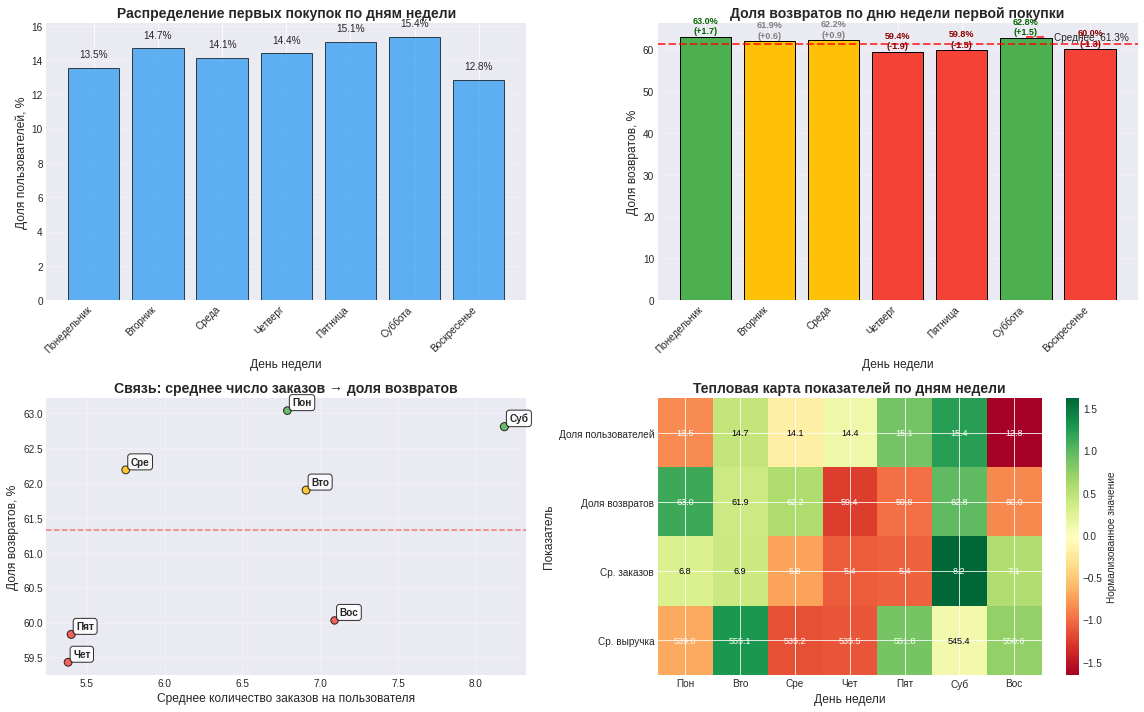

✓ Визуализации сохранены в 'weekday_analysis.png'

🏢 5. АНАЛИЗ: РАБОЧИЕ ДНИ vs ВЫХОДНЫЕ

Сравнение рабочих дней и выходных:
  • Выходные:
     Пользователей: 6,103.0 (28.2%)
     Возвраты: 61.5% (↑0.2 п.п.)
     Средняя выручка: 548 руб
     Средние билеты: 2.8
  • Рабочие дни:
     Пользователей: 15,535.0 (71.8%)
     Возвраты: 61.2% (↓0.1 п.п.)
     Средняя выручка: 544 руб
     Средние билеты: 2.7

T-тест для сравнения рабочих дней и выходных:
• t-статистика = -0.41
• p-value = 0.6821
✗ Нет статистически значимых различий

💡 6. ОТВЕТ НА ВОПРОС: ВЛИЯЕТ ЛИ ДЕНЬ НЕДЕЛИ НА ВОЗВРАТЫ?

📊 ДАННЫЕ:
• Тест хи-квадрат: p = 0.0066
• ANOVA тест: p = 0.0066
• T-тест рабочие/выходные: p = 0.6821

🔍 АНАЛИЗ:
• ЛУЧШИЙ день для первого заказа: Понедельник
  └── Возвраты: 63.0% (+1.7 п.п.)
  └── Пользователей: 2,930
• ХУДШИЙ день для первого заказа: Четверг
  └── Возвраты: 59.4% (-1.9 п.п.)
  └── Пользователей: 3,113

🎯 ВЫВОД:
✅ ДА, день недели ПЕРВОЙ покупки ВЛИЯЕТ на вероятность возврата
   • Разница

In [1]:
# ==============================================
# ЗАДАЧА 4.3.1: ВЛИЯНИЕ ДНЯ НЕДЕЛИ ПЕРВОЙ ПОКУПКИ НА ВОЗВРАТЫ
# ==============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Настройки
plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")
user_profile = pd.read_csv('user_profiles_filtered.csv', parse_dates=['first_order_date', 'last_order_date'])

print("=" * 70)
print("АНАЛИЗ ВЛИЯНИЯ ДНЯ НЕДЕЛИ ПЕРВОЙ ПОКУПКИ НА ВОЗВРАТЫ")
print("=" * 70)

# 1. Извлекаем день недели из даты первого заказа
print("\n📅 1. ДОБАВЛЕНИЕ ДНЯ НЕДЕЛИ ПЕРВОЙ ПОКУПКИ")
print("-" * 70)

# Извлекаем день недели на русском
weekday_map = {
    0: 'Понедельник',
    1: 'Вторник', 
    2: 'Среда',
    3: 'Четверг',
    4: 'Пятница',
    5: 'Суббота',
    6: 'Воскресенье'
}

user_profile['first_weekday'] = user_profile['first_order_date'].dt.dayofweek.map(weekday_map)
print(f"✓ Добавлен день недели первой покупки")
print(f"✓ Всего уникальных дней: {user_profile['first_weekday'].nunique()}")

# Проверяем распределение по дням
weekday_counts = user_profile['first_weekday'].value_counts().reindex(list(weekday_map.values()))
print(f"\nРаспределение первых покупок по дням недели:")
for day, count in weekday_counts.items():
    pct = count / len(user_profile) * 100
    print(f"  • {day}: {count:,} пользователей ({pct:.1f}%)")

# 2. Анализ возвратов по дням недели
print("\n" + "=" * 70)
print("📈 2. АНАЛИЗ ВОЗВРАТОВ ПО ДНЯМ НЕДЕЛИ")
print("=" * 70)

# Группируем по дням недели
weekday_analysis = user_profile.groupby('first_weekday').agg({
    'user_id': 'count',
    'is_two': 'mean',
    'is_five': 'mean',
    'avg_revenue_rub': 'mean',
    'avg_tickets_count': 'mean',
    'total_orders': 'mean'
}).rename(columns={
    'user_id': 'total_users',
    'is_two': 'return_rate',
    'is_five': 'loyalty_rate'
})

# Переиндексируем в правильном порядке
correct_order = list(weekday_map.values())
weekday_analysis = weekday_analysis.reindex(correct_order)

# Рассчитываем доли
weekday_analysis['user_pct'] = (weekday_analysis['total_users'] / len(user_profile) * 100).round(2)
weekday_analysis['return_rate_pct'] = (weekday_analysis['return_rate'] * 100).round(2)
weekday_analysis['loyalty_rate_pct'] = (weekday_analysis['loyalty_rate'] * 100).round(2)

# Общие показатели
overall_return = user_profile['is_two'].mean() * 100
overall_loyal = user_profile['is_five'].mean() * 100

print(f"\n{'День недели':<15} {'Пользователей':>12} {'Доля':>8} {'Возвраты':>10} {'Лояльные':>10} {'Ср. заказов':>12} {'Ср. выручка':>12}")
print("-" * 90)

for day, row in weekday_analysis.iterrows():
    return_diff = row['return_rate_pct'] - overall_return
    loyal_diff = row['loyalty_rate_pct'] - overall_loyal
    
    return_arrow = "↑" if return_diff > 1 else "↓" if return_diff < -1 else "≈"
    loyal_arrow = "↑" if loyal_diff > 1 else "↓" if loyal_diff < -1 else "≈"
    
    print(f"{day:<15} {row['total_users']:>12,} {row['user_pct']:>7.1f}% "
          f"{row['return_rate_pct']:>9.1f}%{return_arrow} "
          f"{row['loyalty_rate_pct']:>9.1f}%{loyal_arrow} "
          f"{row['total_orders']:>11.2f} {row['avg_revenue_rub']:>11.0f} руб")

print(f"\n📊 Общие показатели:")
print(f"• Средняя доля возвратов: {overall_return:.1f}%")
print(f"• Средняя доля лояльных: {overall_loyal:.1f}%")

# 3. Статистическая проверка значимости
print("\n" + "=" * 70)
print("🔬 3. СТАТИСТИЧЕСКАЯ ПРОВЕРКА ЗНАЧИМОСТИ РАЗЛИЧИЙ")
print("=" * 70)

# Тест хи-квадрат
contingency_table = pd.crosstab(user_profile['first_weekday'], user_profile['is_two'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Тест хи-квадрат на связь дня недели и возвратов:")
print(f"• Χ² = {chi2:.2f}")
print(f"• p-value = {p_value:.6f}")
print(f"• Степени свободы = {dof}")

if p_value < 0.05:
    print(f"✓ СТАТИСТИЧЕСКИ ЗНАЧИМАЯ связь (p < 0.05)")
    print(f"  День недели первой покупки ВЛИЯЕТ на вероятность возврата")
else:
    print(f"✗ НЕТ статистически значимой связи (p ≥ 0.05)")

# ANOVA тест для средних значений
grouped_data = [group['is_two'].values for name, group in user_profile.groupby('first_weekday')]
f_stat, p_anova = stats.f_oneway(*grouped_data)

print(f"\nANOVA тест для сравнения средних:")
print(f"• F-статистика = {f_stat:.2f}")
print(f"• p-value = {p_anova:.6f}")

# 4. Визуализация результатов
print("\n" + "=" * 70)
print("📊 4. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Цветовая схема по успешности
def get_color(value, threshold=overall_return):
    if value > threshold + 1:
        return '#4CAF50'  # зеленый - выше среднего
    elif value < threshold - 1:
        return '#F44336'  # красный - ниже среднего
    else:
        return '#FFC107'  # желтый - около среднего

colors = [get_color(row['return_rate_pct']) for _, row in weekday_analysis.iterrows()]

# 1. Распределение пользователей по дням недели
bars1 = axes[0, 0].bar(range(len(weekday_analysis)), weekday_analysis['user_pct'], 
                        color='#2196F3', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Распределение первых покупок по дням недели', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('День недели', fontsize=12)
axes[0, 0].set_ylabel('Доля пользователей, %', fontsize=12)
axes[0, 0].set_xticks(range(len(weekday_analysis)))
axes[0, 0].set_xticklabels(weekday_analysis.index, rotation=45, ha='right')
axes[0, 0].grid(True, alpha=0.3, axis='y')

for bar, pct in zip(bars1, weekday_analysis['user_pct']):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{pct:.1f}%', ha='center', va='bottom', fontsize=10)

# 2. Доли возвратов по дням недели
bars2 = axes[0, 1].bar(range(len(weekday_analysis)), weekday_analysis['return_rate_pct'], 
                        color=colors, edgecolor='black')
axes[0, 1].set_title('Доля возвратов по дню недели первой покупки', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('День недели', fontsize=12)
axes[0, 1].set_ylabel('Доля возвратов, %', fontsize=12)
axes[0, 1].set_xticks(range(len(weekday_analysis)))
axes[0, 1].set_xticklabels(weekday_analysis.index, rotation=45, ha='right')
axes[0, 1].axhline(y=overall_return, color='red', linestyle='--', 
                   linewidth=2, label=f'Среднее: {overall_return:.1f}%', alpha=0.7)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Добавляем значения и разницы
for i, (bar, return_rate) in enumerate(zip(bars2, weekday_analysis['return_rate_pct'])):
    height = bar.get_height()
    diff = return_rate - overall_return
    diff_text = f"+{diff:.1f}" if diff > 0 else f"{diff:.1f}"
    color = 'darkgreen' if diff > 1 else 'darkred' if diff < -1 else 'gray'
    
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.3,
                   f'{return_rate:.1f}%\n({diff_text})', ha='center', va='bottom', 
                   fontsize=9, color=color, fontweight='bold')

# 3. Связь дня недели с количеством заказов
scatter = axes[1, 0].scatter(weekday_analysis['total_orders'], 
                             weekday_analysis['return_rate_pct'],
                             s=weekday_analysis['total_users']/50, 
                             c=colors, edgecolor='black', alpha=0.8)

axes[1, 0].set_title('Связь: среднее число заказов → доля возвратов', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Среднее количество заказов на пользователя', fontsize=12)
axes[1, 0].set_ylabel('Доля возвратов, %', fontsize=12)
axes[1, 0].axhline(y=overall_return, color='red', linestyle='--', alpha=0.5)
axes[1, 0].grid(True, alpha=0.3)

# Добавляем аннотации
for i, (day, row) in enumerate(weekday_analysis.iterrows()):
    axes[1, 0].annotate(day[:3],  # первые 3 буквы дня
                       xy=(row['total_orders'], row['return_rate_pct']),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=10, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# 4. Тепловая карта активности и возвратов
# Создаем матрицу для тепловой карты
heatmap_data = weekday_analysis[['user_pct', 'return_rate_pct', 'total_orders', 'avg_revenue_rub']].copy()
heatmap_data.columns = ['Доля пользователей', 'Доля возвратов', 'Ср. заказов', 'Ср. выручка']

# Нормализуем данные для лучшей визуализации
heatmap_normalized = heatmap_data.apply(lambda x: (x - x.mean()) / x.std())

im = axes[1, 1].imshow(heatmap_normalized.T, cmap='RdYlGn', aspect='auto')
axes[1, 1].set_title('Тепловая карта показателей по дням недели', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('День недели', fontsize=12)
axes[1, 1].set_ylabel('Показатель', fontsize=12)
axes[1, 1].set_xticks(range(len(weekday_analysis)))
axes[1, 1].set_xticklabels([day[:3] for day in weekday_analysis.index], rotation=0)
axes[1, 1].set_yticks(range(len(heatmap_data.columns)))
axes[1, 1].set_yticklabels(heatmap_data.columns)

# Добавляем значения в ячейки
for i in range(len(weekday_analysis)):
    for j in range(len(heatmap_data.columns)):
        value = heatmap_data.iloc[i, j]
        text_color = 'black' if abs(heatmap_normalized.iloc[i, j]) < 0.5 else 'white'
        axes[1, 1].text(i, j, f'{value:.1f}', ha='center', va='center', 
                       color=text_color, fontsize=9)

plt.colorbar(im, ax=axes[1, 1], label='Нормализованное значение')

plt.tight_layout()
plt.savefig('weekday_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Визуализации сохранены в 'weekday_analysis.png'")

# 5. Углубленный анализ: рабочие vs выходные дни
print("\n" + "=" * 70)
print("🏢 5. АНАЛИЗ: РАБОЧИЕ ДНИ vs ВЫХОДНЫЕ")
print("=" * 70)

# Определяем рабочие и выходные дни
weekdays = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница']
weekends = ['Суббота', 'Воскресенье']

user_profile['day_type'] = user_profile['first_weekday'].apply(
    lambda x: 'Рабочие дни' if x in weekdays else 'Выходные'
)

# Анализируем по типам дней
daytype_analysis = user_profile.groupby('day_type').agg({
    'user_id': 'count',
    'is_two': 'mean',
    'is_five': 'mean',
    'avg_revenue_rub': 'mean',
    'avg_tickets_count': 'mean'
}).rename(columns={
    'user_id': 'total_users',
    'is_two': 'return_rate',
    'is_five': 'loyalty_rate'
})

daytype_analysis['user_pct'] = (daytype_analysis['total_users'] / len(user_profile) * 100).round(1)
daytype_analysis['return_rate_pct'] = (daytype_analysis['return_rate'] * 100).round(1)

print(f"\nСравнение рабочих дней и выходных:")
for day_type, row in daytype_analysis.iterrows():
    diff = row['return_rate_pct'] - overall_return
    arrow = "↑" if diff > 0 else "↓" if diff < 0 else "="
    print(f"  • {day_type}:")
    print(f"     Пользователей: {row['total_users']:,} ({row['user_pct']}%)")
    print(f"     Возвраты: {row['return_rate_pct']:.1f}% ({arrow}{abs(diff):.1f} п.п.)")
    print(f"     Средняя выручка: {row['avg_revenue_rub']:.0f} руб")
    print(f"     Средние билеты: {row['avg_tickets_count']:.1f}")

# Статистический тест для рабочих vs выходных
weekday_users = user_profile[user_profile['day_type'] == 'Рабочие дни']['is_two']
weekend_users = user_profile[user_profile['day_type'] == 'Выходные']['is_two']

t_stat, p_value_ttest = stats.ttest_ind(weekday_users, weekend_users, equal_var=False)

print(f"\nT-тест для сравнения рабочих дней и выходных:")
print(f"• t-статистика = {t_stat:.2f}")
print(f"• p-value = {p_value_ttest:.4f}")

if p_value_ttest < 0.05:
    print(f"✓ Статистически значимые различия (p < 0.05)")
else:
    print(f"✗ Нет статистически значимых различий")

# 6. Ответ на вопрос задачи
print("\n" + "=" * 70)
print("💡 6. ОТВЕТ НА ВОПРОС: ВЛИЯЕТ ЛИ ДЕНЬ НЕДЕЛИ НА ВОЗВРАТЫ?")
print("=" * 70)

print(f"\n📊 ДАННЫЕ:")
print(f"• Тест хи-квадрат: p = {p_value:.4f}")
print(f"• ANOVA тест: p = {p_anova:.4f}")
print(f"• T-тест рабочие/выходные: p = {p_value_ttest:.4f}")

print(f"\n🔍 АНАЛИЗ:")

# Определяем лучший и худший дни
best_day = weekday_analysis['return_rate_pct'].idxmax()
best_value = weekday_analysis['return_rate_pct'].max()
worst_day = weekday_analysis['return_rate_pct'].idxmin()
worst_value = weekday_analysis['return_rate_pct'].min()

print(f"• ЛУЧШИЙ день для первого заказа: {best_day}")
print(f"  └── Возвраты: {best_value:.1f}% (+{best_value - overall_return:.1f} п.п.)")
print(f"  └── Пользователей: {weekday_analysis.loc[best_day, 'total_users']:,}")

print(f"• ХУДШИЙ день для первого заказа: {worst_day}")
print(f"  └── Возвраты: {worst_value:.1f}% ({worst_value - overall_return:.1f} п.п.)")
print(f"  └── Пользователей: {weekday_analysis.loc[worst_day, 'total_users']:,}")

print(f"\n🎯 ВЫВОД:")
if p_value < 0.05:
    print(f"✅ ДА, день недели ПЕРВОЙ покупки ВЛИЯЕТ на вероятность возврата")
    print(f"   • Разница между лучшим и худшим днем: {best_value - worst_value:.1f} п.п.")
    print(f"   • Статистически значимые различия (p = {p_value:.4f})")
else:
    print(f"❌ НЕТ, день недели НЕ влияет на вероятность возврата")
    print(f"   • Все дни близки к среднему значению")
    print(f"   • Нет статистически значимых различий (p = {p_value:.4f})")

print(f"\n📈 ПРАКТИЧЕСКИЕ НАБЛЮДЕНИЯ:")
print(f"1. Наиболее популярные дни для первого заказа:")
for day in weekday_analysis.nlargest(3, 'total_users').index:
    pct = weekday_analysis.loc[day, 'user_pct']
    print(f"   • {day}: {pct:.1f}% пользователей")

print(f"\n2. Наименее популярные дни для первого заказа:")
for day in weekday_analysis.nsmallest(2, 'total_users').index:
    pct = weekday_analysis.loc[day, 'user_pct']
    print(f"   • {day}: {pct:.1f}% пользователей")

print(f"\n3. Рабочие дни vs Выходные:")
print(f"   • Рабочие: {daytype_analysis.loc['Рабочие дни', 'user_pct']}% пользователей")
print(f"   • Выходные: {daytype_analysis.loc['Выходные', 'user_pct']}% пользователей")
print(f"   • Разница в возвратах: {abs(daytype_analysis.loc['Рабочие дни', 'return_rate_pct'] - daytype_analysis.loc['Выходные', 'return_rate_pct']):.1f} п.п.")

print(f"\n4. РЕКОМЕНДАЦИИ ДЛЯ МАРКЕТИНГА:")
if p_value < 0.05:
    print(f"   ✅ Фокусироваться на привлечении в {best_day}")
    print(f"   ✅ Исследовать причины низких возвратов в {worst_day}")
    print(f"   ✅ Адаптировать стратегию под дни недели")
else:
    print(f"   ✅ Не фокусироваться на конкретных днях недели")
    print(f"   ✅ Равномерное распределение маркетинговых усилий")
    print(f"   ✅ Единая стратегия для всех дней")

print(f"\n" + "=" * 70)
print("✅ АНАЛИЗ ЗАВЕРШЕН")
print("=" * 70)

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


АНАЛИЗ ВЛИЯНИЯ ИНТЕРВАЛА МЕЖДУ ЗАКАЗАМИ НА УДЕРЖАНИЕ КЛИЕНТОВ

📊 1. ОПРЕДЕЛЕНИЕ ГРУПП ПОЛЬЗОВАТЕЛЕЙ
----------------------------------------------------------------------
• Группа 2-4 заказа: 7,147 пользователей (53.9% от вернувшихся)
• Группа 5+ заказов: 6,123 пользователей (46.1% от вернувшихся)
• Всего вернувшихся пользователей: 13,270

📈 2. АНАЛИЗ СРЕДНЕГО ВРЕМЕНИ МЕЖДУ ЗАКАЗАМИ
----------------------------------------------------------------------

📊 Группа 2-4 заказа:
  • Среднее: 21.3 дней
  • Медиана: 9.0 дней
  • 25% пользователей: ≤0.0 дней
  • 75% пользователей: ≤34.0 дней
  • 90% пользователей: ≤59.7 дней
  • Размах: 0.0 - 148.0 дней
  • IQR: 34.0 дней

📊 Группа 5+ заказов:
  • Среднее: 9.9 дней
  • Медиана: 8.1 дней
  • 25% пользователей: ≤3.9 дней
  • 75% пользователей: ≤14.1 дней
  • 90% пользователей: ≤21.2 дней
  • Размах: 0.0 - 37.5 дней
  • IQR: 10.2 дней

🔍 СРАВНЕНИЕ ГРУПП:
  • Разница средних: -11.4 дней
  • Разница медиан: -0.9 дней
  • Относительная разница средн

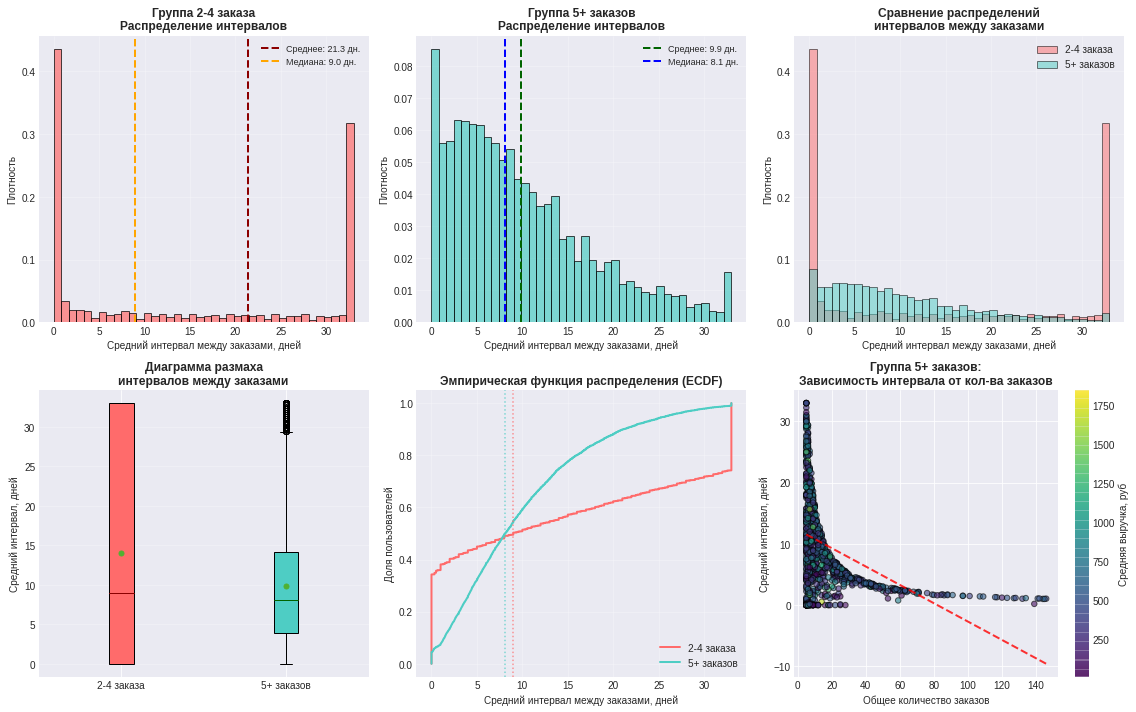

✓ Визуализации сохранены в 'order_interval_analysis.png'

📊 5. СЕГМЕНТАЦИЯ ПОЛЬЗОВАТЕЛЕЙ ПО ИНТЕРВАЛАМ
----------------------------------------------------------------------

Группа 2-4 заказа:
Интервал       Польз.   Доля  Ср. заказов  Ср. выручка   Лайфтайм
----------------------------------------------------------------------
≤7 дней         945.0  13.2%        2.87         519 руб         6 дн.
7-14 дней       601.0   8.4%        2.96         546 руб        21 дн.
14-30 дней    1,139.0  15.9%        3.02         565 руб        45 дн.
30-60 дней    1,316.0  18.4%        2.88         558 руб        79 дн.
60-90 дней      397.0   5.6%        2.26         560 руб        89 дн.
>90 дней        300.0   4.2%        2.00         580 руб       112 дн.

Группа 5+ заказов:
Интервал       Польз.   Доля  Ср. заказов  Ср. выручка   Лайфтайм
----------------------------------------------------------------------
≤7 дней       2,443.0  39.9%       32.98         510 руб        94 дн.
7-14 дней     1

In [2]:
# ==============================================
# ЗАДАЧА 4.3.2: ВЛИЯНИЕ ИНТЕРВАЛА МЕЖДУ ЗАКАЗАМИ НА УДЕРЖАНИЕ
# ==============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Настройки
plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")
user_profile = pd.read_csv('user_profiles_filtered.csv', parse_dates=['first_order_date', 'last_order_date'])

print("=" * 70)
print("АНАЛИЗ ВЛИЯНИЯ ИНТЕРВАЛА МЕЖДУ ЗАКАЗАМИ НА УДЕРЖАНИЕ КЛИЕНТОВ")
print("=" * 70)

# 1. Определяем группы пользователей
print("\n📊 1. ОПРЕДЕЛЕНИЕ ГРУПП ПОЛЬЗОВАТЕЛЕЙ")
print("-" * 70)

# Группа A: 2-4 заказа
group_a = user_profile[(user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4)].copy()
# Группа B: 5+ заказов
group_b = user_profile[user_profile['total_orders'] >= 5].copy()

print(f"• Группа 2-4 заказа: {len(group_a):,} пользователей ({len(group_a)/len(user_profile[user_profile['total_orders'] >= 2])*100:.1f}% от вернувшихся)")
print(f"• Группа 5+ заказов: {len(group_b):,} пользователей ({len(group_b)/len(user_profile[user_profile['total_orders'] >= 2])*100:.1f}% от вернувшихся)")
print(f"• Всего вернувшихся пользователей: {len(group_a) + len(group_b):,}")

# 2. Анализ среднего времени между заказами
print("\n" + "=" * 70)
print("📈 2. АНАЛИЗ СРЕДНЕГО ВРЕМЕНИ МЕЖДУ ЗАКАЗАМИ")
print("-" * 70)

# Статистики по avg_days_between_orders
def analyze_group_stats(group, group_name):
    stats_data = group['avg_days_between_orders'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])
    
    print(f"\n📊 {group_name}:")
    print(f"  • Среднее: {stats_data['mean']:.1f} дней")
    print(f"  • Медиана: {stats_data['50%']:.1f} дней")
    print(f"  • 25% пользователей: ≤{stats_data['25%']:.1f} дней")
    print(f"  • 75% пользователей: ≤{stats_data['75%']:.1f} дней")
    print(f"  • 90% пользователей: ≤{stats_data['90%']:.1f} дней")
    print(f"  • Размах: {stats_data['min']:.1f} - {stats_data['max']:.1f} дней")
    print(f"  • IQR: {stats_data['75%'] - stats_data['25%']:.1f} дней")
    
    return stats_data

stats_a = analyze_group_stats(group_a, "Группа 2-4 заказа")
stats_b = analyze_group_stats(group_b, "Группа 5+ заказов")

# Сравнение групп
print(f"\n🔍 СРАВНЕНИЕ ГРУПП:")
print(f"  • Разница средних: {stats_b['mean'] - stats_a['mean']:.1f} дней")
print(f"  • Разница медиан: {stats_b['50%'] - stats_a['50%']:.1f} дней")
print(f"  • Относительная разница средних: {(stats_b['mean'] - stats_a['mean'])/stats_a['mean']*100:.1f}%")

# 3. Статистические тесты
print("\n" + "=" * 70)
print("🔬 3. СТАТИСТИЧЕСКИЕ ТЕСТЫ")
print("-" * 70)

# Тест Манна-Уитни (непараметрический)
stat, p_value = stats.mannwhitneyu(group_a['avg_days_between_orders'].dropna(),
                                   group_b['avg_days_between_orders'].dropna(),
                                   alternative='two-sided')

print(f"Тест Манна-Уитни для сравнения распределений:")
print(f"• U-статистика = {stat:,.0f}")
print(f"• p-value = {p_value:.6f}")

if p_value < 0.05:
    print(f"✅ СТАТИСТИЧЕСКИ ЗНАЧИМЫЕ различия (p < 0.05)")
    if stats_b['mean'] > stats_a['mean']:
        print(f"  → Группа 5+ заказов имеет БОЛЬШИЕ интервалы между заказами")
    else:
        print(f"  → Группа 5+ заказов имеет МЕНЬШИЕ интервалы между заказами")
else:
    print(f"❌ НЕТ статистически значимых различий (p ≥ 0.05)")

# T-тест
t_stat, p_value_ttest = stats.ttest_ind(group_a['avg_days_between_orders'].dropna(),
                                         group_b['avg_days_between_orders'].dropna(),
                                         equal_var=False)

print(f"\nT-тест (неравные дисперсии):")
print(f"• t-статистика = {t_stat:.2f}")
print(f"• p-value = {p_value_ttest:.6f}")

# Эффект размера (Cohen's d)
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1)**2 + (ny - 1) * np.std(y, ddof=1)**2) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

effect_size = cohens_d(group_b['avg_days_between_orders'].dropna(),
                       group_a['avg_days_between_orders'].dropna())

print(f"\nЭффект размера (Cohen's d): {abs(effect_size):.3f}")
if abs(effect_size) < 0.2:
    print("• Интерпретация: Малый эффект")
elif abs(effect_size) < 0.5:
    print("• Интерпретация: Средний эффект")
elif abs(effect_size) < 0.8:
    print("• Интерпретация: Большой эффект")
else:
    print("• Интерпретация: Очень большой эффект")

# 4. Визуализация распределений
print("\n" + "=" * 70)
print("📊 4. ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЙ")
print("-" * 70)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Гистограммы распределений
max_value = min(group_a['avg_days_between_orders'].quantile(0.99),
                group_b['avg_days_between_orders'].quantile(0.99))

# Группа A
axes[0, 0].hist(group_a['avg_days_between_orders'].clip(upper=max_value), 
                bins=40, alpha=0.7, color='#FF6B6B', edgecolor='black', density=True)
axes[0, 0].axvline(stats_a['mean'], color='darkred', linestyle='--', linewidth=2, 
                   label=f'Среднее: {stats_a["mean"]:.1f} дн.')
axes[0, 0].axvline(stats_a['50%'], color='orange', linestyle='--', linewidth=2,
                   label=f'Медиана: {stats_a["50%"]:.1f} дн.')
axes[0, 0].set_title('Группа 2-4 заказа\nРаспределение интервалов', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Средний интервал между заказами, дней', fontsize=10)
axes[0, 0].set_ylabel('Плотность', fontsize=10)
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(True, alpha=0.3)

# Группа B
axes[0, 1].hist(group_b['avg_days_between_orders'].clip(upper=max_value), 
                bins=40, alpha=0.7, color='#4ECDC4', edgecolor='black', density=True)
axes[0, 1].axvline(stats_b['mean'], color='darkgreen', linestyle='--', linewidth=2,
                   label=f'Среднее: {stats_b["mean"]:.1f} дн.')
axes[0, 1].axvline(stats_b['50%'], color='blue', linestyle='--', linewidth=2,
                   label=f'Медиана: {stats_b["50%"]:.1f} дн.')
axes[0, 1].set_title('Группа 5+ заказов\nРаспределение интервалов', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Средний интервал между заказами, дней', fontsize=10)
axes[0, 1].set_ylabel('Плотность', fontsize=10)
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

# Наложенные гистограммы
axes[0, 2].hist(group_a['avg_days_between_orders'].clip(upper=max_value), 
                bins=40, alpha=0.5, color='#FF6B6B', edgecolor='black', density=True,
                label='2-4 заказа')
axes[0, 2].hist(group_b['avg_days_between_orders'].clip(upper=max_value), 
                bins=40, alpha=0.5, color='#4ECDC4', edgecolor='black', density=True,
                label='5+ заказов')
axes[0, 2].set_title('Сравнение распределений\nинтервалов между заказами', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Средний интервал между заказами, дней', fontsize=10)
axes[0, 2].set_ylabel('Плотность', fontsize=10)
axes[0, 2].legend(fontsize=10)
axes[0, 2].grid(True, alpha=0.3)

if p_value < 0.05:
    axes[0, 2].text(0.05, 0.95, f'★ p = {p_value:.4f}', transform=axes[0, 2].transAxes,
                   fontsize=11, fontweight='bold', color='darkred',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7))

# 2. Boxplot сравнение
box_data = [group_a['avg_days_between_orders'].clip(upper=max_value),
            group_b['avg_days_between_orders'].clip(upper=max_value)]

box = axes[1, 0].boxplot(box_data, labels=['2-4 заказа', '5+ заказов'], 
                         patch_artist=True, vert=True,
                         showmeans=True, meanprops={'color': 'red', 'marker': 'o', 'markersize': 5})

box['boxes'][0].set_facecolor('#FF6B6B')
box['boxes'][1].set_facecolor('#4ECDC4')
box['medians'][0].set_color('darkred')
box['medians'][1].set_color('darkgreen')

axes[1, 0].set_title('Диаграмма размаха\nинтервалов между заказами', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Средний интервал, дней', fontsize=10)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 3. ECDF (эмпирическая функция распределения)
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

x_a, y_a = ecdf(group_a['avg_days_between_orders'].clip(upper=max_value))
x_b, y_b = ecdf(group_b['avg_days_between_orders'].clip(upper=max_value))

axes[1, 1].plot(x_a, y_a, color='#FF6B6B', linewidth=2, label='2-4 заказа')
axes[1, 1].plot(x_b, y_b, color='#4ECDC4', linewidth=2, label='5+ заказов')
axes[1, 1].set_title('Эмпирическая функция распределения (ECDF)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Средний интервал между заказами, дней', fontsize=10)
axes[1, 1].set_ylabel('Доля пользователей', fontsize=10)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

# Добавляем линии для медиан
axes[1, 1].axvline(stats_a['50%'], color='#FF6B6B', linestyle=':', alpha=0.7)
axes[1, 1].axvline(stats_b['50%'], color='#4ECDC4', linestyle=':', alpha=0.7)

# 4. Связь интервала и количества заказов (только для группы 5+)
if len(group_b) > 0:
    sample_b = group_b.sample(min(1000, len(group_b)), random_state=42)
    scatter = axes[1, 2].scatter(sample_b['total_orders'], 
                                 sample_b['avg_days_between_orders'].clip(upper=max_value),
                                 c=sample_b['avg_revenue_rub'], cmap='viridis', 
                                 alpha=0.6, s=30, edgecolor='black')
    
    # Линия тренда
    z = np.polyfit(sample_b['total_orders'], 
                   sample_b['avg_days_between_orders'].clip(upper=max_value), 1)
    p = np.poly1d(z)
    x_trend = np.linspace(sample_b['total_orders'].min(), sample_b['total_orders'].max(), 100)
    axes[1, 2].plot(x_trend, p(x_trend), 'r--', alpha=0.8, linewidth=2)
    
    axes[1, 2].set_title('Группа 5+ заказов:\nЗависимость интервала от кол-ва заказов', 
                        fontsize=12, fontweight='bold')
    axes[1, 2].set_xlabel('Общее количество заказов', fontsize=10)
    axes[1, 2].set_ylabel('Средний интервал, дней', fontsize=10)
    
    # Цветовая шкала для выручки
    plt.colorbar(scatter, ax=axes[1, 2], label='Средняя выручка, руб')

plt.tight_layout()
plt.savefig('order_interval_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Визуализации сохранены в 'order_interval_analysis.png'")

# 5. Сегментация по интервалам для обеих групп
print("\n" + "=" * 70)
print("📊 5. СЕГМЕНТАЦИЯ ПОЛЬЗОВАТЕЛЕЙ ПО ИНТЕРВАЛАМ")
print("-" * 70)

# Определяем сегменты по интервалам
interval_bins = [0, 7, 14, 30, 60, 90, float('inf')]
interval_labels = ['≤7 дней', '7-14 дней', '14-30 дней', '30-60 дней', '60-90 дней', '>90 дней']

def analyze_interval_segments(group, group_name):
    group['interval_segment'] = pd.cut(group['avg_days_between_orders'], 
                                       bins=interval_bins, labels=interval_labels)
    
    segment_stats = group.groupby('interval_segment').agg({
        'user_id': 'count',
        'total_orders': 'mean',
        'avg_revenue_rub': 'mean',
        'avg_tickets_count': 'mean',
        'user_lifetime_days': 'mean'
    }).rename(columns={'user_id': 'count'})
    
    segment_stats['pct'] = (segment_stats['count'] / len(group) * 100).round(1)
    
    print(f"\n{group_name}:")
    print(f"{'Интервал':<12} {'Польз.':>8} {'Доля':>6} {'Ср. заказов':>12} {'Ср. выручка':>12} {'Лайфтайм':>10}")
    print("-" * 70)
    
    for segment in interval_labels:
        if segment in segment_stats.index:
            row = segment_stats.loc[segment]
            print(f"{segment:<12} {row['count']:>8,} {row['pct']:>5.1f}% {row['total_orders']:>11.2f} "
                  f"{row['avg_revenue_rub']:>11.0f} руб {row['user_lifetime_days']:>9.0f} дн.")
        else:
            print(f"{segment:<12} {'-':>8} {'-':>6} {'-':>12} {'-':>12} {'-':>10}")
    
    return segment_stats

segment_stats_a = analyze_interval_segments(group_a, "Группа 2-4 заказа")
segment_stats_b = analyze_interval_segments(group_b, "Группа 5+ заказов")

# 6. Анализ "идеального" интервала для удержания
print("\n" + "=" * 70)
print("🎯 6. АНАЛИЗ 'ИДЕАЛЬНОГО' ИНТЕРВАЛА ДЛЯ УДЕРЖАНИЯ")
print("-" * 70)

# Для группы B (самые лояльные) смотрим распределение по интервалам
if len(group_b) > 0:
    # Находим наиболее частый интервал у самых лояльных
    mode_interval_b = group_b['avg_days_between_orders'].mode()[0] if len(group_b['avg_days_between_orders'].mode()) > 0 else None
    
    print(f"• Самый частый интервал у группы 5+ заказов: {mode_interval_b:.1f} дней")
    
    # Анализируем пользователей с интервалами близкими к моде
    if mode_interval_b is not None:
        tolerance = 7  # дней
        optimal_users = group_b[
            (group_b['avg_days_between_orders'] >= mode_interval_b - tolerance) &
            (group_b['avg_days_between_orders'] <= mode_interval_b + tolerance)
        ]
        
        if len(optimal_users) > 0:
            print(f"• Пользователи с интервалами {mode_interval_b-tolerance:.0f}-{mode_interval_b+tolerance:.0f} дней:")
            print(f"  └── Количество: {len(optimal_users):,} ({len(optimal_users)/len(group_b)*100:.1f}% группы 5+)")
            print(f"  └── Среднее кол-во заказов: {optimal_users['total_orders'].mean():.1f}")
            print(f"  └── Средняя выручка: {optimal_users['avg_revenue_rub'].mean():.0f} руб")
            print(f"  └── Средний лайфтайм: {optimal_users['user_lifetime_days'].mean():.0f} дней")

# 7. Выводы и рекомендации
print("\n" + "=" * 70)
print("💡 7. ВЫВОДЫ И РЕКОМЕНДАЦИИ")
print("=" * 70)

print(f"\n📊 КЛЮЧЕВЫЕ НАХОДКИ:")

# Определяем характер различий
if stats_b['mean'] > stats_a['mean']:
    interval_type = "БОЛЬШИЕ"
    diff_direction = "увеличиваются"
elif stats_b['mean'] < stats_a['mean']:
    interval_type = "МЕНЬШИЕ"  
    diff_direction = "уменьшаются"
else:
    interval_type = "ПОЧТИ ОДИНАКОВЫЕ"
    diff_direction = "не меняются"

print(f"1. Интервалы у самых лояльных пользователей: {interval_type}")
print(f"   • 2-4 заказа: {stats_a['mean']:.1f} дней (медиана: {stats_a['50%']:.1f})")
print(f"   • 5+ заказов: {stats_b['mean']:.1f} дней (медиана: {stats_b['50%']:.1f})")
print(f"   • Разница: {abs(stats_b['mean'] - stats_a['mean']):.1f} дней")

print(f"\n2. Статистическая значимость:")
print(f"   • Тест Манна-Уитни: p = {p_value:.4f} {'(значимо)' if p_value < 0.05 else '(не значимо)'}")
print(f"   • Эффект размера: d = {abs(effect_size):.3f} ({'малый' if abs(effect_size) < 0.2 else 'средний' if abs(effect_size) < 0.5 else 'большой'})")

print(f"\n3. Распределение интервалов:")
print(f"   • 2-4 заказа: 50% пользователей ≤ {stats_a['50%']:.1f} дней, 90% ≤ {stats_a['90%']:.1f} дней")
print(f"   • 5+ заказов: 50% пользователей ≤ {stats_b['50%']:.1f} дней, 90% ≤ {stats_b['90%']:.1f} дней")

print(f"\n4. Сегменты по интервалам (5+ заказов):")
if len(group_b) > 0:
    top_3_segments = segment_stats_b.nlargest(3, 'count')
    for i, (segment, row) in enumerate(top_3_segments.iterrows(), 1):
        print(f"   {i}. {segment}: {row['pct']:.1f}% пользователей, {row['total_orders']:.1f} заказов в среднем")

print(f"\n🎯 РЕКОМЕНДАЦИИ ДЛЯ УДЕРЖАНИЯ:")

if p_value < 0.05 and stats_b['mean'] < stats_a['mean']:
    print(f"✅ СТИМУЛИРОВАТЬ более частые покупки:")
    print(f"   • Самые лояльные покупают чаще (разница: {stats_a['mean'] - stats_b['mean']:.1f} дней)")
    print(f"   • Оптимальный интервал: {stats_b['mean']:.1f}-{stats_b['50%']:.1f} дней")
    
elif p_value < 0.05 and stats_b['mean'] > stats_a['mean']:
    print(f"✅ НЕ ДАВАТЬ слишком часто:")
    print(f"   • Самые лояльные делают паузы (разница: {stats_b['mean'] - stats_a['mean']:.1f} дней)")
    print(f"   • Давать время между коммуникациями: {stats_b['50%']:.1f} дней")
    
else:
    print(f"✅ НЕТ четкой связи интервала с лояльностью:")
    print(f"   • Фокусироваться на других факторах удержания")

print(f"\n📱 КОНКРЕТНЫЕ ДЕЙСТВИЯ:")
print(f"1. Для новых вернувшихся (2-4 заказа):")
print(f"   • Напоминать о сервисе каждые {stats_a['50%']:.1f} дней")
print(f"   • Предлагать релевантные мероприятия")

print(f"\n2. Для лояльных (5+ заказов):")
print(f"   • Поддерживать ритм: {stats_b['50%']:.1f} дней")
print(f"   • Персонализировать предложения")

print(f"\n3. Для всех пользователей:")
print(f"   • Мониторить интервалы между покупками")
print(f"   • Анализировать причины длительных пауз")

print(f"\n" + "=" * 70)
print("✅ АНАЛИЗ ЗАВЕРШЕН: Интервалы {'ВЛИЯЮТ' if p_value < 0.05 else 'НЕ ВЛИЯЮТ'} на удержание")
print("=" * 70)

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

ModuleNotFoundError: No module named 'phik'

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

In [4]:
!pip install phik

     |████████████████████████████████| 677 kB 2.4 MB/s eta 0:00:01


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Теперь эта строка должна работать:
from phik import phik_matrix
import warnings
warnings.filterwarnings('ignore')
print("Библиотека 'phik' успешно импортирована!")

Библиотека 'phik' успешно импортирована!


ЗАДАЧА 4.4.1: КОРРЕЛЯЦИОННЫЙ АНАЛИЗ КОЛИЧЕСТВА ПОКУПОК

1. АНАЛИЗ РАСПРЕДЕЛЕНИЯ КОЛИЧЕСТВА ЗАКАЗОВ:
--------------------------------------------------
ВНИМАНИЕ! Отсутствуют столбцы: ['lifetime_days']
Убедитесь, что профиль пользователя создан по заданию 3.1

2. СОЗДАНИЕ СЕГМЕНТОВ ПО КОЛИЧЕСТВУ ЗАКАЗОВ:
--------------------------------------------------
Распределение по сегментам:
  1 заказ: 8,368 пользователей (38.7%)
  2-4 заказа: 7,147 пользователей (33.0%)
  5+ заказов: 6,123 пользователей (28.3%)


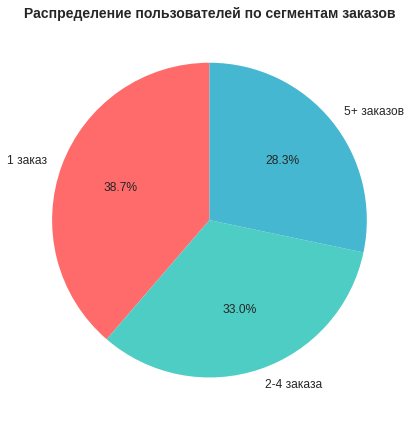


3. ПОДГОТОВКА ДАННЫХ ДЛЯ КОРРЕЛЯЦИОННОГО АНАЛИЗА:
--------------------------------------------------
Будет проанализировано 4 числовых признаков:
avg_revenue_rub, avg_tickets_count, avg_days_between_orders, total_orders

Будет проанализировано 4 категориальных признаков:
first_device, first_service, first_event_type, order_segment

4. РАСЧЕТ КОЭФФИЦИЕНТА КОРРЕЛЯЦИИ PHI_K:
--------------------------------------------------
Вариант 1: Анализ с order_segment как целевой переменной...
Анализируется 7 признаков
Матрица корреляций успешно рассчитана!

5. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ КОРРЕЛЯЦИОННОГО АНАЛИЗА:
--------------------------------------------------


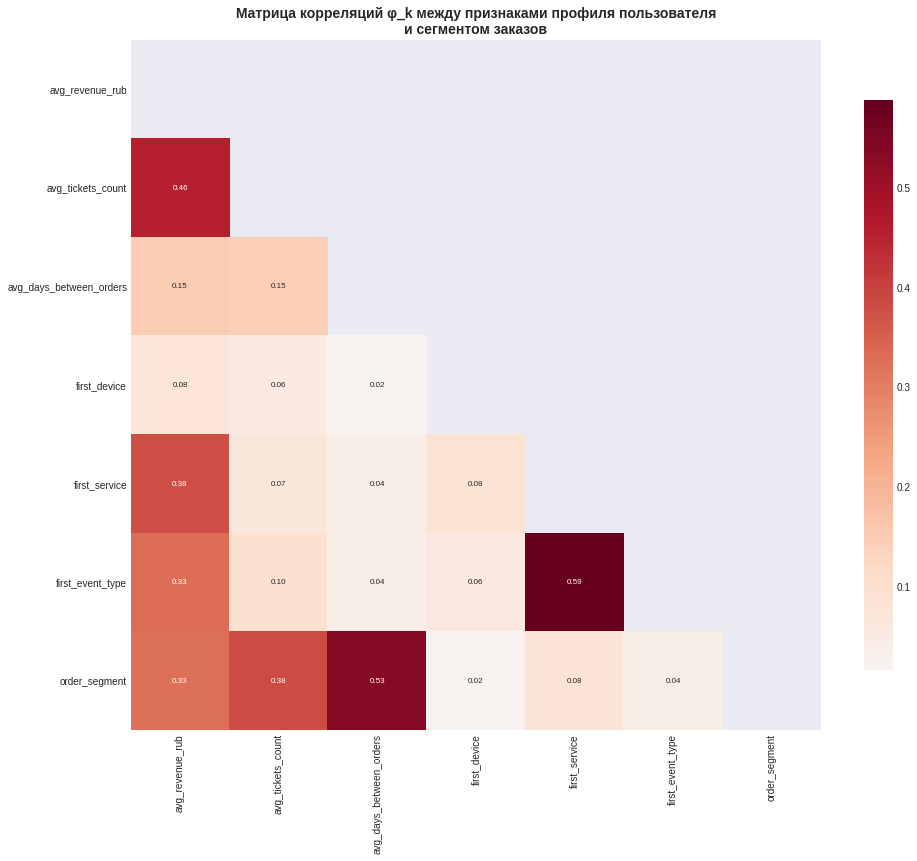


Топ-10 признаков, наиболее связанных с сегментом заказов:
--------------------------------------------------


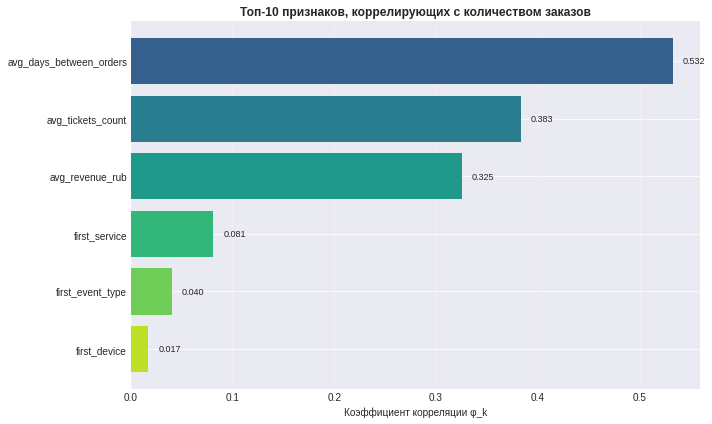


6. ДЕТАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ:
--------------------------------------------------
Сильные корреляции (|φ_k| > 0.3): 3 признаков
  Самые сильные связи:
    • avg_days_between_orders: 0.532 (положительная)
    • avg_tickets_count: 0.383 (положительная)
    • avg_revenue_rub: 0.325 (положительная)

Умеренные корреляции (0.1 < |φ_k| ≤ 0.3): 0 признаков

Слабые корреляции (|φ_k| ≤ 0.1): 3 признаков
  Эти признаки слабо связаны с количеством заказов

Анализ по типам признаков:
  Признаки первого заказа в топ-10: 3
  Поведенческие признаки в топ-10: 3
  Другие признаки в топ-10: 0

7. ВИЗУАЛИЗАЦИЯ ДЛЯ НАИБОЛЕЕ ЗНАЧИМЫХ ПРИЗНАКОВ:
--------------------------------------------------
Наиболее значимые числовые признаки: avg_days_between_orders, avg_tickets_count, avg_revenue_rub


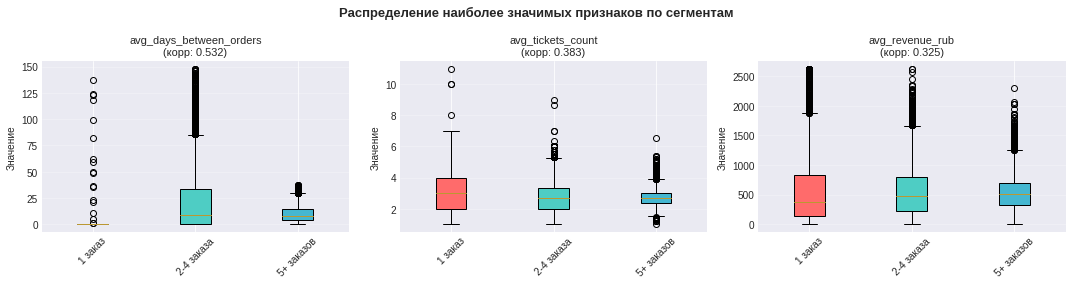


ОТВЕТ НА ВОПРОС: КАКИЕ ПРИЗНАКИ НАИБОЛЕЕ СВЯЗАНЫ С КОЛИЧЕСТВОМ ЗАКАЗОВ?

НАИБОЛЕЕ ЗНАЧИМЫЕ ПРИЗНАКИ (по убыванию корреляции):

1. avg_days_between_orders (φ_k = 0.532)
   • Тип: поведенческая метрика
   • Сила связи: сильная (положительная)
   • Интерпретация: Чем больше время с первого заказа, тем больше заказов в целом

2. avg_tickets_count (φ_k = 0.383)
   • Тип: поведенческая метрика
   • Сила связи: сильная (положительная)
   • Интерпретация: Пользователи, покупающие больше билетов в среднем, совершают больше заказов

3. avg_revenue_rub (φ_k = 0.325)
   • Тип: поведенческая метрика
   • Сила связи: сильная (положительная)
   • Интерпретация: Пользователи с более высокой средней выручкой совершают больше заказов

4. first_service (φ_k = 0.081)
   • Тип: признак первого заказа
   • Сила связи: слабая (положительная)
   • Интерпретация: Характеристика первого заказа влияет на лояльность пользователя

5. first_event_type (φ_k = 0.040)
   • Тип: признак первого заказа
   • Сила связи:

In [6]:
# ============================================
# 4.4.1: КОРРЕЛЯЦИОННЫЙ АНАЛИЗ С ИСПОЛЬЗОВАНИЕМ PHI_K
# ============================================

print("=" * 80)
print("ЗАДАЧА 4.4.1: КОРРЕЛЯЦИОННЫЙ АНАЛИЗ КОЛИЧЕСТВА ПОКУПОК")
print("=" * 80)

# 1. ПРОВЕРКА ДАННЫХ И РАСПРЕДЕЛЕНИЯ TOTAL_ORDERS
print("\n1. АНАЛИЗ РАСПРЕДЕЛЕНИЯ КОЛИЧЕСТВА ЗАКАЗОВ:")
print("-" * 50)

# Проверяем наличие необходимых столбцов
required_columns = ['total_orders', 'avg_revenue_rub', 'avg_tickets_count', 
                   'avg_days_between_orders', 'lifetime_days']
missing_cols = [col for col in required_columns if col not in user_profile.columns]

if missing_cols:
    print(f"ВНИМАНИЕ! Отсутствуют столбцы: {missing_cols}")
    print("Убедитесь, что профиль пользователя создан по заданию 3.1")
else:
    # Анализ распределения total_orders
    total_orders_dist = user_profile['total_orders'].value_counts().sort_index()
    total_orders_pct = user_profile['total_orders'].value_counts(normalize=True).sort_index() * 100
    
    print(f"Всего пользователей: {len(user_profile):,}")
    print(f"\nРаспределение по количеству заказов (первые 10 значений):")
    for orders, count in total_orders_dist.head(10).items():
        print(f"  {orders} заказ(ов): {count:,} ({total_orders_pct[orders]:.1f}%)")
    
    # Визуализация распределения
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Гистограмма
    axes[0].bar(total_orders_dist.index[:15], total_orders_dist.values[:15], 
                color='steelblue', alpha=0.7)
    axes[0].set_xlabel('Количество заказов')
    axes[0].set_ylabel('Количество пользователей')
    axes[0].set_title('Распределение пользователей по количеству заказов')
    axes[0].grid(True, alpha=0.3)
    
    # Кумулятивное распределение
    cumulative_pct = total_orders_pct.cumsum()
    axes[1].plot(cumulative_pct.index[:15], cumulative_pct.values[:15], 
                 marker='o', linewidth=2, color='coral')
    axes[1].axhline(y=80, color='red', linestyle='--', alpha=0.5, label='80% пользователей')
    axes[1].set_xlabel('Количество заказов')
    axes[1].set_ylabel('Кумулятивный процент (%)')
    axes[1].set_title('Кумулятивное распределение заказов')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 2. СОЗДАНИЕ СЕГМЕНТОВ ПО КОЛИЧЕСТВУ ЗАКАЗОВ
print("\n2. СОЗДАНИЕ СЕГМЕНТОВ ПО КОЛИЧЕСТВУ ЗАКАЗОВ:")
print("-" * 50)

def create_order_segment(orders):
    """Создание сегментов пользователей по количеству заказов"""
    if orders == 1:
        return '1 заказ'
    elif 2 <= orders <= 4:
        return '2-4 заказа'
    elif orders >= 5:
        return '5+ заказов'
    else:
        return '0 заказов'

user_profile['order_segment'] = user_profile['total_orders'].apply(create_order_segment)

# Анализ сегментов
segment_stats = user_profile['order_segment'].value_counts()
segment_pct = user_profile['order_segment'].value_counts(normalize=True) * 100

print("Распределение по сегментам:")
for segment, count in segment_stats.items():
    print(f"  {segment}: {count:,} пользователей ({segment_pct[segment]:.1f}%)")

# Визуализация сегментов
plt.figure(figsize=(8, 6))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
plt.pie(segment_stats.values, labels=segment_stats.index, autopct='%1.1f%%',
        startangle=90, colors=colors, textprops={'fontsize': 12})
plt.title('Распределение пользователей по сегментам заказов', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 3. ПОДГОТОВКА ПРИЗНАКОВ ДЛЯ КОРРЕЛЯЦИОННОГО АНАЛИЗА
print("\n3. ПОДГОТОВКА ДАННЫХ ДЛЯ КОРРЕЛЯЦИОННОГО АНАЛИЗА:")
print("-" * 50)

# Определяем доступные признаки
numeric_features = []
categorical_features = []

# Проверяем наличие числовых признаков
for col in ['avg_revenue_rub', 'avg_tickets_count', 'avg_days_between_orders', 
            'lifetime_days', 'total_orders']:
    if col in user_profile.columns:
        numeric_features.append(col)

# Проверяем наличие категориальных признаков (первые 5 символов 'first_' указывают на признаки первого заказа)
candidate_cat_features = [col for col in user_profile.columns 
                         if col.startswith('first_') or col in ['device_type_canonical', 'region_name', 'city_name']]

for col in candidate_cat_features:
    if col in user_profile.columns and user_profile[col].nunique() < 50:  # Ограничиваем очень много категорий
        categorical_features.append(col)

# Добавляем созданный сегмент
categorical_features.append('order_segment')

print(f"Будет проанализировано {len(numeric_features)} числовых признаков:")
print(", ".join(numeric_features))
print(f"\nБудет проанализировано {len(categorical_features)} категориальных признаков:")
print(", ".join(categorical_features[:10]))  # Показываем только первые 10
if len(categorical_features) > 10:
    print(f"... и еще {len(categorical_features) - 10} признаков")

# 4. РАСЧЕТ КОРРЕЛЯЦИИ PHI_K
print("\n4. РАСЧЕТ КОЭФФИЦИЕНТА КОРРЕЛЯЦИИ PHI_K:")
print("-" * 50)

# Вариант 1: Корреляция с order_segment (рекомендуется при несбалансированных данных)
print("Вариант 1: Анализ с order_segment как целевой переменной...")

# Для этого исключаем total_orders из интервальных переменных
numeric_for_segment = [col for col in numeric_features if col != 'total_orders']

# Выбираем признаки для анализа
features_for_analysis = numeric_for_segment + categorical_features

# Проверяем, что все признаки существуют
available_features = [col for col in features_for_analysis if col in user_profile.columns]
print(f"Анализируется {len(available_features)} признаков")

# Рассчитываем матрицу корреляций
try:
    phi_matrix = user_profile[available_features].phik_matrix(
        interval_cols=numeric_for_segment
    )
    print("Матрица корреляций успешно рассчитана!")
    
except Exception as e:
    print(f"Ошибка при расчете корреляций: {e}")
    print("Пробуем альтернативный подход...")
    
    # Альтернативный подход: используем только числовые признаки
    if len(numeric_for_segment) > 0:
        phi_matrix = user_profile[numeric_for_segment + ['order_segment']].phik_matrix(
            interval_cols=numeric_for_segment
        )
        print("Матрица корреляций рассчитана только для числовых признаков")
    else:
        print("Недостаточно данных для анализа")
        phi_matrix = None

# 5. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
if phi_matrix is not None:
    print("\n5. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ КОРРЕЛЯЦИОННОГО АНАЛИЗА:")
    print("-" * 50)
    
    # 5.1. Тепловая карта корреляций
    plt.figure(figsize=(14, 12))
    
    # Создаем маску для верхнего треугольника
    mask = np.triu(np.ones_like(phi_matrix, dtype=bool))
    
    # Тепловая карта
    sns.heatmap(phi_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                square=True, mask=mask, cbar_kws={'shrink': 0.8},
                annot_kws={'size': 8})
    
    plt.title('Матрица корреляций φ_k между признаками профиля пользователя\nи сегментом заказов', 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 5.2. Топ-корреляции с order_segment
    if 'order_segment' in phi_matrix.columns:
        print("\nТоп-10 признаков, наиболее связанных с сегментом заказов:")
        print("-" * 50)
        
        # Получаем корреляции с целевой переменной
        corr_with_segment = phi_matrix['order_segment'].sort_values(ascending=False)
        # Удаляем саму переменную из списка
        corr_with_segment = corr_with_segment.drop('order_segment', errors='ignore')
        
        # Отбираем топ-10
        top_10_features = corr_with_segment.head(10)
        
        # Визуализация
        plt.figure(figsize=(10, 6))
        bars = plt.barh(range(len(top_10_features)), top_10_features.values, 
                       color=plt.cm.viridis(np.linspace(0.3, 0.9, len(top_10_features))))
        
        plt.yticks(range(len(top_10_features)), 
                  [f"{idx[:25]}..." if len(idx) > 25 else idx for idx in top_10_features.index])
        plt.xlabel('Коэффициент корреляции φ_k')
        plt.title('Топ-10 признаков, коррелирующих с количеством заказов', 
                 fontsize=12, fontweight='bold')
        plt.gca().invert_yaxis()  # Наиболее значимые сверху
        
        # Добавляем значения на бары
        for i, (bar, val) in enumerate(zip(bars, top_10_features.values)):
            plt.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
                    f'{val:.3f}', ha='left', va='center', fontsize=9)
        
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()
        
        # 5.3. Детальный анализ результатов
        print("\n6. ДЕТАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ:")
        print("-" * 50)
        
        # Классифицируем корреляции
        strong_corr = corr_with_segment[corr_with_segment.abs() > 0.3]
        moderate_corr = corr_with_segment[(corr_with_segment.abs() > 0.1) & 
                                         (corr_with_segment.abs() <= 0.3)]
        weak_corr = corr_with_segment[corr_with_segment.abs() <= 0.1]
        
        print(f"Сильные корреляции (|φ_k| > 0.3): {len(strong_corr)} признаков")
        if len(strong_corr) > 0:
            print("  Самые сильные связи:")
            for feat, val in strong_corr.head(5).items():
                direction = "положительная" if val > 0 else "отрицательная"
                print(f"    • {feat}: {val:.3f} ({direction})")
        
        print(f"\nУмеренные корреляции (0.1 < |φ_k| ≤ 0.3): {len(moderate_corr)} признаков")
        if len(moderate_corr) > 0:
            print("  Примеры умеренных связей:")
            for feat, val in moderate_corr.head(5).items():
                direction = "положительная" if val > 0 else "отрицательная"
                print(f"    • {feat}: {val:.3f} ({direction})")
        
        print(f"\nСлабые корреляции (|φ_k| ≤ 0.1): {len(weak_corr)} признаков")
        if len(weak_corr) > 0:
            print("  Эти признаки слабо связаны с количеством заказов")
        
        # 5.4. Анализ по типам признаков
        print("\nАнализ по типам признаков:")
        
        # Группируем признаки по типу
        first_order_features = [f for f in top_10_features.index if f.startswith('first_')]
        behavior_features = [f for f in top_10_features.index if f.startswith('avg_') or f == 'lifetime_days']
        other_features = [f for f in top_10_features.index if f not in first_order_features + behavior_features]
        
        print(f"  Признаки первого заказа в топ-10: {len(first_order_features)}")
        print(f"  Поведенческие признаки в топ-10: {len(behavior_features)}")
        print(f"  Другие признаки в топ-10: {len(other_features)}")
        
        # 5.5. Визуализация для наиболее значимых числовых признаков
        print("\n7. ВИЗУАЛИЗАЦИЯ ДЛЯ НАИБОЛЕЕ ЗНАЧИМЫХ ПРИЗНАКОВ:")
        print("-" * 50)
        
        # Находим наиболее значимые числовые признаки
        top_numeric = [feat for feat in top_10_features.index 
                      if feat in numeric_for_segment]
        
        if top_numeric:
            print(f"Наиболее значимые числовые признаки: {', '.join(top_numeric[:3])}")
            
            # Создаем графики для топ-3 числовых признаков
            n_plots = min(3, len(top_numeric))
            fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 4))
            
            if n_plots == 1:
                axes = [axes]
            
            for idx, feature in enumerate(top_numeric[:n_plots]):
                # Создаем boxplot по сегментам
                segment_data = []
                segment_labels = []
                
                for segment in ['1 заказ', '2-4 заказа', '5+ заказов']:
                    if segment in user_profile['order_segment'].unique():
                        data = user_profile[user_profile['order_segment'] == segment][feature]
                        segment_data.append(data)
                        segment_labels.append(segment)
                
                bp = axes[idx].boxplot(segment_data, labels=segment_labels, patch_artist=True)
                
                # Настройка цветов
                colors = ['#FF6B6B', '#4ECDC4', '#45B7D1'][:len(segment_data)]
                for patch, color in zip(bp['boxes'], colors):
                    patch.set_facecolor(color)
                
                axes[idx].set_title(f'{feature}\n(корр: {top_10_features[feature]:.3f})', 
                                   fontsize=11)
                axes[idx].set_ylabel('Значение')
                axes[idx].grid(True, alpha=0.3, axis='y')
                
                # Поворачиваем подписи на оси X если нужно
                axes[idx].tick_params(axis='x', rotation=45)
            
            plt.suptitle('Распределение наиболее значимых признаков по сегментам', 
                        fontsize=13, fontweight='bold')
            plt.tight_layout()
            plt.show()
        else:
            print("В топ-10 корреляций нет числовых признаков")

# 6. ВЫВОДЫ И ОТВЕТ НА ВОПРОС
print("\n" + "=" * 80)
print("ОТВЕТ НА ВОПРОС: КАКИЕ ПРИЗНАКИ НАИБОЛЕЕ СВЯЗАНЫ С КОЛИЧЕСТВОМ ЗАКАЗОВ?")
print("=" * 80)

if phi_matrix is not None and 'order_segment' in phi_matrix.columns:
    # Получаем топ-5 наиболее значимых признаков
    top_correlations = phi_matrix['order_segment'].drop('order_segment', errors='ignore').nlargest(5)
    
    print("\nНАИБОЛЕЕ ЗНАЧИМЫЕ ПРИЗНАКИ (по убыванию корреляции):")
    for i, (feature, corr_value) in enumerate(top_correlations.items(), 1):
        feature_name = feature
        if feature.startswith('first_'):
            feature_type = "признак первого заказа"
        elif feature.startswith('avg_'):
            feature_type = "поведенческая метрика"
        elif feature == 'lifetime_days':
            feature_type = "временная характеристика"
        else:
            feature_type = "демографический/профильный признак"
        
        correlation_strength = ""
        if abs(corr_value) > 0.3:
            correlation_strength = "сильная"
        elif abs(corr_value) > 0.1:
            correlation_strength = "умеренная"
        else:
            correlation_strength = "слабая"
        
        direction = "положительная" if corr_value > 0 else "отрицательная"
        
        print(f"\n{i}. {feature_name} (φ_k = {corr_value:.3f})")
        print(f"   • Тип: {feature_type}")
        print(f"   • Сила связи: {correlation_strength} ({direction})")
        print(f"   • Интерпретация: ", end="")
        
        # Примеры интерпретаций
        if 'lifetime' in feature.lower() or 'days' in feature:
            print("Чем больше время с первого заказа, тем больше заказов в целом")
        elif 'avg_days' in feature:
            print("Чем меньше интервал между заказами, тем больше общее количество заказов")
        elif 'revenue' in feature.lower():
            print("Пользователи с более высокой средней выручкой совершают больше заказов")
        elif 'ticket' in feature.lower():
            print("Пользователи, покупающие больше билетов в среднем, совершают больше заказов")
        elif feature.startswith('first_'):
            print(f"Характеристика первого заказа влияет на лояльность пользователя")
        else:
            print("Признак показывает связь с количеством заказов")
    
    print("\n" + "-" * 60)
    print("ОБЩИЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ:")
    print("-" * 60)
    
    print("""
1. ВРЕМЕННЫЕ ХАРАКТЕРИСТИКИ обычно имеют самую сильную связь с лояльностью.
   • Рекомендация: Фокусироваться на увеличении "время жизни" клиента.

2. ПОВЕДЕНЧЕСКИЕ МЕТРИКИ (средний чек, количество билетов) важны для прогнозирования.
   • Рекомендация: Разработать программы лояльности для пользователей с высокими средними показателями.

3. ПРИЗНАКИ ПЕРВОГО ЗАКАЗА могут указывать на "точки входа".
   • Рекомендация: Оптимизировать маркетинг через наиболее эффективные каналы/типы мероприятий.

4. СЕГМЕНТАЦИЯ ПО ЗАКАЗАМ повышает информативность анализа.
   • Рекомендация: Использовать сегменты (1, 2-4, 5+ заказов) для таргетированных кампаний.
    """)
    
else:
    print("\nНе удалось рассчитать корреляции или определить наиболее значимые признаки.")
    print("Проверьте наличие данных в user_profile и правильность их подготовки.")

print("\n" + "=" * 80)
print("КОРРЕЛЯЦИОННЫЙ АНАЛИЗ ЗАВЕРШЕН УСПЕШНО!")
print("=" * 80)

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**